# Compute the camera calibration matrix and distortion coefficients

In [1]:
# First, compute the camera calibration matrix and distortion coefficients given a set of chessboard images 
# (in the camera_cal folder in the repository).

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
nx = 9
ny = 6

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

In [5]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
len(images)

20

In [6]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    print(fname)
    st = datetime.now()
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found/'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
    print('runtime: {}'.format(datetime.now()-st))        

camera_cal/calibration1.jpg
runtime: 0:00:00.238282
camera_cal/calibration10.jpg
runtime: 0:00:00.329151
camera_cal/calibration11.jpg
runtime: 0:00:00.472801
camera_cal/calibration12.jpg
runtime: 0:00:00.221688
camera_cal/calibration13.jpg
runtime: 0:00:00.234519
camera_cal/calibration14.jpg
runtime: 0:00:00.225441
camera_cal/calibration15.jpg
runtime: 0:00:00.252336
camera_cal/calibration16.jpg
runtime: 0:00:00.233509
camera_cal/calibration17.jpg
runtime: 0:00:00.184184
camera_cal/calibration18.jpg
runtime: 0:00:00.170032
camera_cal/calibration19.jpg
runtime: 0:00:00.273395
camera_cal/calibration2.jpg
runtime: 0:00:00.065163
camera_cal/calibration20.jpg
runtime: 0:00:00.470802
camera_cal/calibration3.jpg
runtime: 0:00:00.065896
camera_cal/calibration4.jpg
runtime: 0:00:00.342194
camera_cal/calibration5.jpg
runtime: 0:00:00.265978
camera_cal/calibration6.jpg
runtime: 0:00:00.337428
camera_cal/calibration7.jpg
runtime: 0:00:00.268875
camera_cal/calibration8.jpg
runtime: 0:00:00.270615
c

In [7]:
import pickle
%matplotlib inline

In [8]:
# Test undistortion on an image
testfname = 'camera_cal/calibration3.jpg'
img = cv2.imread(testfname)
img_size = (img.shape[1], img.shape[0])
img_size

(1280, 720)

In [9]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [10]:
ret, mtx

(1.1868973603423718,
 array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
        [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]))

In [11]:
# k1, k2, p1, p2, k3. 
# k for radial distortion (curved lenses), p for tangential distortion (image plane not alingned with lens)
dist

array([[ -2.41017956e-01,  -5.30721173e-02,  -1.15810355e-03,
         -1.28318856e-04,   2.67125290e-02]])

In [12]:
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

True

In [13]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_pickle.p", "wb" ) )

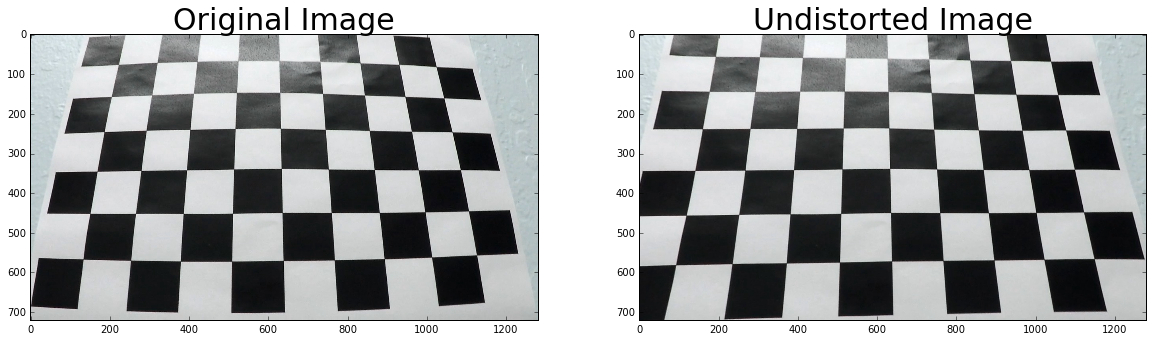

In [14]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Original Image', fontsize=30);
ax2.imshow(dst);
ax2.set_title('Undistorted Image', fontsize=30);

In [16]:
#Next, for a series of test images (in the test_images folder in the repository):
#
#Apply the distortion correction to the raw image.
#Use color transforms, gradients, etc., to create a thresholded binary image.
#Apply a perspective transform to rectify binary image ("birds-eye view").
#Detect lane pixels and fit to find lane boundary.
#Determine curvature of the lane and vehicle position with respect to center.
#Warp the detected lane boundaries back onto the original image.
#Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


# Building blocks for pipeline on individual images

In [15]:
import matplotlib.image as mpimg

In [24]:
image = mpimg.imread('test_images/test3.jpg')

## `undistort` function

In [26]:
#Apply the distortion correction to the raw image.
# inputs:
#   img  -- input image
#   mtx  -- camera matrix from calibrateCamera
#   dist -- distortion coefficients from calibrateCamera
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [27]:
undist = undistort(image, mtx, dist)

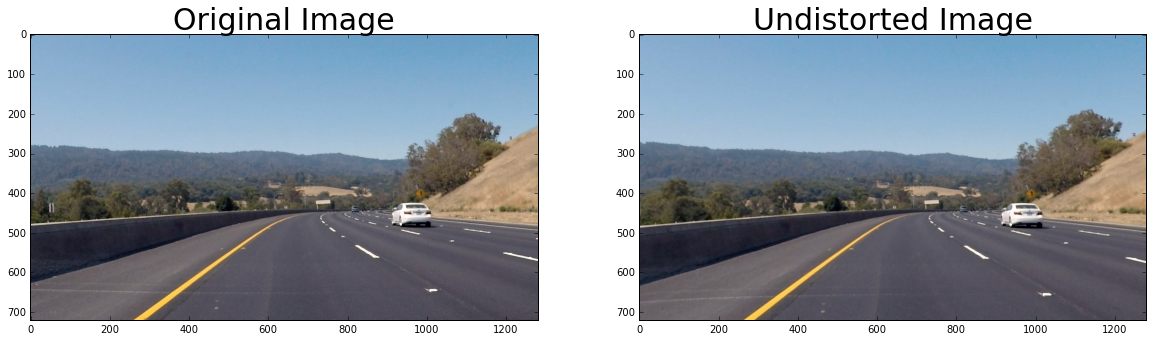

In [28]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(image);
ax1.set_title('Original Image', fontsize=30);
ax2.imshow(undist);
ax2.set_title('Undistorted Image', fontsize=30);

In [29]:
image = undist

## functions for creating thresholded images using sobel transforms, gradients and color space conversions

In [30]:
# Apply Sobel along x or y axis to img.
# Then takes an absolute value and apply thresholds.
# Returns binary image.
#   inputs
#     img          -- input image
#     orient       -- 'x' or 'y'
#     kernel_size  -- sobel operator kernel size, in px
#     thresholds   -- two values for low and high thresholds
def sobel_abs_thresholds(img, orient='x', kernel_size=3, thresholds=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresholds[0]) & (scaled_sobel <= thresholds[1])] = 1
    return binary_output

In [31]:
# Applies Sobel along x and y.
# Computes the magnitude of the gradient and applies thresholds.
# Returns binary image.
#   inputs
#     img          -- input image
#     kernel_size  -- sobel operator kernel size, in px
#     thresholds   -- two values for low and high thresholds
def sobel_magnitude_thresholds(img, kernel_size=3, thresholds=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresholds[0]) & (scaled_sobel <= thresholds[1])] = 1
    return binary_output

In [32]:
# Applies Sobel along x and y, then computes the direction of the gradient for absolute sobel values.
# Applies thresholds.
# Returns binary image.
#   inputs
#     img          -- input image
#     kernel_size  -- sobel operator kernel size, in px
#     thresholds   -- two values for low and high thresholds
def sobel_graddir_thresholds(img, kernel_size=3, thresholds=(0., np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel_grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(sobel_grad).astype(np.uint8)
    binary_output[(sobel_grad >= thresholds[0]) & (sobel_grad <= thresholds[1])] = 1
    return binary_output

In [33]:
# Converts image to HLS color space.
# Applies thresholds to the S-channel.
# Returns binary image.
#   inputs
#     img          -- input image
#     thresholds   -- two values for low and high thresholds
def hls_s_thresholds(img, thresholds=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) 
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s >= thresholds[0]) & (s <= thresholds[1])] = 1
    return binary_output

## final `thresholded_binary` function combining various transforms and producing image best suited for lane line detection

In [34]:
# Produce binary image from original color image where lane lines are as distinct as possible for later detection
#
# the final image can be described as
#
#    binary = (sx & smag) || ( (sy & sgrad) || ( (smag & sgrad) || (sx || s) ) ) 
#
# where 
#    sx is sobelx, 
#    smag is sobel gradient magnitude, 
#    sy is sobely, 
#    sgrad is sobel gradient,
#    s is S channel in HLS space
def thresholded_binary(image):
    # sobel x
    sx_kernel = 3
    sx_thresh = (20, 100)
    sx_binary = sobel_abs_thresholds(image, orient='x', kernel_size=sx_kernel, thresholds=sx_thresh)
    # sobel y
    sy_kernel = 3
    sy_thresh = (30, 100)
    sy_binary = sobel_abs_thresholds(image, orient='y', kernel_size=sy_kernel, thresholds=sy_thresh)
    # sobel magnitude
    smag_kernel = 5
    smag_thresh = (30,100)
    smag_binary = sobel_magnitude_thresholds(image, kernel_size=smag_kernel, thresholds=smag_thresh)
    # sobel gradient direction
    sgraddir_kernel = 7
    sgraddir_thresh = (0.7, 1.3)
    sgraddir_binary = sobel_graddir_thresholds(image, kernel_size=sgraddir_kernel, thresholds=sgraddir_thresh)
    # HSV's S threshold
    s_thresh = (170,255)
    s_binary = hls_s_thresholds(image, thresholds=s_thresh)
    # x gradient and S threshold
    combined = np.zeros_like(sx_binary)
    combined[(s_binary == 1) | (sx_binary == 1)] = 1
    # x gradient and magnitude
    combined0 = np.zeros_like(sx_binary)
    combined0[(sx_binary == 1) & (smag_binary == 1)] = 1   
    # y gradient and grad direction
    combined3 = np.zeros_like(sy_binary)
    combined3[(sy_binary == 1) & (sgraddir_binary == 1)] = 1    
    # use previous combined, but add pixels where gradient magnitude and direction are activated
    combined2 = np.copy(combined)
    combined2[((smag_binary == 1) & (sgraddir_binary == 1))] = 1
    # combined2 OR combined3
    combined4 = np.copy(combined2)
    combined4[combined3 == 1] = 1
    # combined4 OR combined0
    combined5 = np.copy(combined4)
    combined5[combined0 == 1] = 1
    return combined5

In [35]:
thresholded_binary_image = thresholded_binary(image)

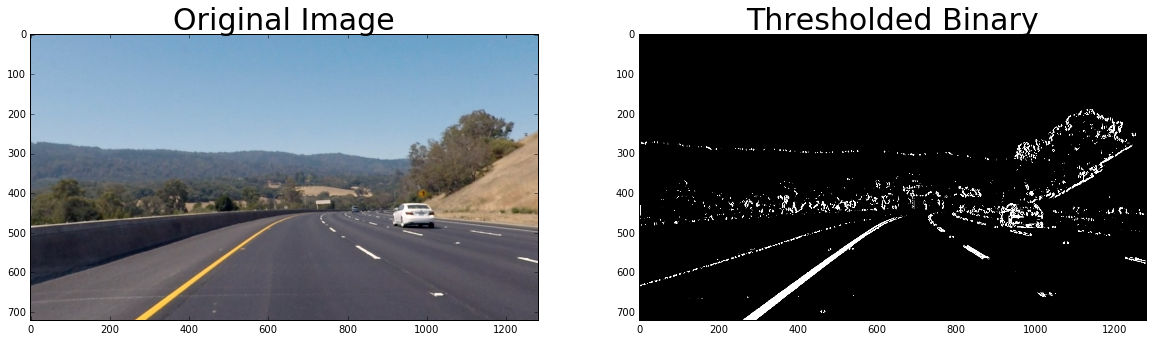

In [37]:
# Visualize result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(image);
ax1.set_title('Original Image', fontsize=30);
ax2.imshow(thresholded_binary_image, cmap='gray');
ax2.set_title('Thresholded Binary', fontsize=30);

## `perspective_transform` to apply perspective transform to get "birds-eye view" of the road in front

In [38]:
copy = np.copy(thresholded_binary_image)
color_copy = np.dstack((copy, copy, copy))
src = np.float32([[85,670], 
                  [515,480], 
                  [765,480], 
                  [1195,670]])
pts = np.array(src)
cv2.fillPoly(color_copy, np.int_([pts]), (0,255,0));
result = cv2.addWeighted(image, 1, color_copy, 0.3, 0)

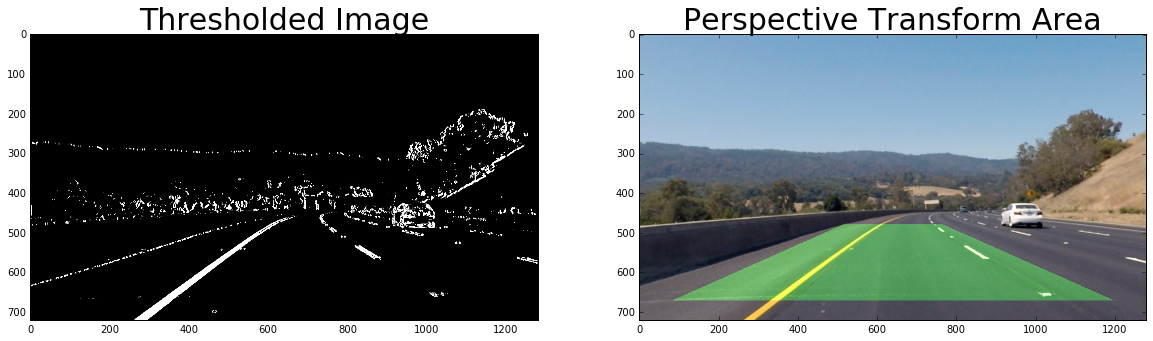

In [40]:
# Visualize transform area
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(copy, cmap='gray');
ax1.set_title('Thresholded Image', fontsize=30);
ax2.imshow(result);
ax2.set_title('Perspective Transform Area', fontsize=30);

In [41]:
# Does perspective transform for the part of the road between lanes.
# Takes undistorted image
# Returns transfromed image, the matrix used to transform it and the matrix for inverse transform
def perspective_transform(img, M=None, Minv=None):
    imshape = img.shape
    
    if (M is None):
        src = np.float32([[85,670], 
                          [515,480], 
                          [765,480], 
                          [1195,670]])
        dst = np.float32([[imshape[1]*.0, imshape[0]*1.],
                          [imshape[1]*.0, imshape[0]*.0],
                          [imshape[1]*1., imshape[0]*.0],
                          [imshape[1]*1., imshape[0]*1.]])
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [42]:
top_down_binary, M, Minv = perspective_transform(thresholded_binary_image, None, None)

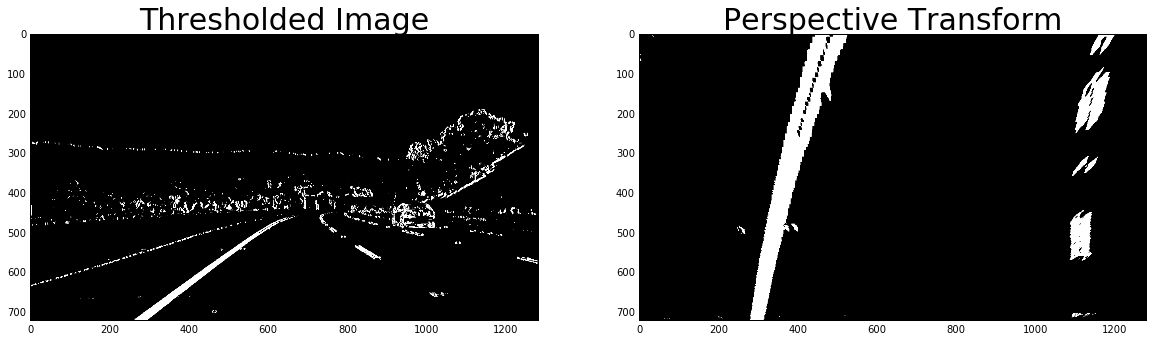

In [43]:
# Visualize
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(thresholded_binary_image, cmap='gray');
ax1.set_title('Thresholded Image', fontsize=30);
ax2.imshow(top_down_binary, cmap='gray');
ax2.set_title('Perspective Transform', fontsize=30);

## `Line` class

Defines some constants for detection and conversion between meters and pixels.

Has static method `find_left_right_x` to apply histogram method to an image and return two most probably x positions of lane lines.

Has instance method `fit_from_x_on_image` that uses sliding window method to detect line pixels from given x position at the bottom. It stores the found line details as instance variables. It reverts to some previously detected information if there are difficulties using the sliding window method.

Has instance method `use_last_good_fit` that takes a new image and applies last fitted line to it. This is called from the outside when outside detector code cannot reconcile two lines detected in the same image.

In [73]:
# Define a class to receive the characteristics of each line detection
class Line():
    # class constants that are same for all instances
    
    # pct width of total image that one lane can occupy. used to decide on histograms
    _pct_image_width_lane_width_max=0.1
    # for the sliding window method -- height of the sliding window
    _pct_image_height_slice=0.1
    # Define conversions in x and y from pixels space to meters
    _ym_per_pix = 3/130 # meters per pixel in y dimension. based on dashed line=3m
    _xm_per_pix = 3.7/840 # meteres per pixel in x dimension
    # history length for confirming detection
    _n = 5
    
    
    def __init__(self, n=Line._n):
        # making this instance variable. it takes precedence over class variable.
        # used to create an instance for individual frame detection (n=1)
        self._n = n
        # was the line detected in the last iteration?
        self._detected = False
        # number of last recent failed fits
        self._failed_fits = 0
        # x values of the last n fits of the line
        self._recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self._bestx = None
        #polynomial coefficients averaged over the last n iterations
        self._best_fit = None
        #polynomial coefficients for the most recent fit in px coordinates
        self._current_fit_px = [np.array([False])]  
        #polynomial coefficients for the most recent fit in m coordinates
        self._current_fit_m = [np.array([False])]  
        #radius of curvature of the line in pixels
        self._radius_of_curvature = None 
        #radius of curvature of the line in meters
        self._radius_of_curvature_m = None 
        #distance in px of vehicle center from the line
        self._line_pos_px = None 
        #distance in m of vehicle center from the line
        self._line_pos_m = None 
        #difference in fit coefficients between last and new fits
        self._diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line image pixels
        self._img_allx = None  
        #y values for detected line image pixels
        self._img_ally = None
        #x values for detected sliding window pixels
        self._histogram_allx = None  
        #y values for detected sliding pixels
        self._histogram_ally = None
        #x values for fitted pixels
        self._line_allx = None  
        #y values for fitted pixels
        self._line_ally = None
        #devirative of fitted line wrt y at the bottom of top-down view, in px coordinates
        self._y_deriv = None
        
    # find radius of curvature closest to the bottom of the image
    def calc_radius_of_curvature(self):
        # curvature in pixels
        a = self._current_fit_px[0]
        b = self._current_fit_px[1]
        c = self._current_fit_px[2]
        y_eval = np.max(self._line_ally)
        self._radius_of_curvature = (1.0+(2.0*a*y_eval+b)**2)**1.5 / np.abs(2*a)
        # curvature in meters
        self._current_fit_m = np.polyfit(self._line_ally*self._ym_per_pix, self._line_allx*self._xm_per_pix, 2)
        a = self._current_fit_m[0]
        b = self._current_fit_m[1]
        c = self._current_fit_m[2]
        self._radius_of_curvature_m = ((1.0 + (2.0*a*y_eval + b)**2)**1.5) / np.abs(2*a)
        # derivative of line wrt y at the bottom
        self._y_deriv = 2*a*y_eval + b

        
    # given binary top-down view of lane pixels find possible left and right x values, in pixels
    # using histogram method
    # Used as static method. Does not change Line state.
    #    inputs:
    #       image                           -- binary image with top-down (perspective-transformed) view of lane lines. 
    #                                       -- assume x and y coordinates are reversed
    #    outputs:
    #        left_lane_x_px                 -- initial estimate for left lane x coordinate or None
    #        right_lane_x_px                -- initial estimate for right lane x coordinate or None
    def find_left_right_x(self, image):
        histogram1 = np.sum(image, axis=0)
        width = len(histogram1)
        # find the most prominent peak in the histogram
        imax1 = np.argmax(histogram1)
        max1 = histogram1[imax1]
        # remove the peak and pct_image_width_lane_width_max elements around it.
        histogram2 = np.copy(histogram1)
        nx = width*self._pct_image_width_lane_width_max
        histogram2[imax1-int(nx/2.0) : imax1+int(nx/2.0)] = 0
        # find second highest peak
        imax2 = np.argmax(histogram2)
        max2 = histogram2[imax2]
        # remove the second peak and pct_image_width_lane_width_max elements around it.
        histogram3 = np.copy(histogram2)
        histogram3[imax2-int(nx/2.0) : imax2+int(nx/2.0)] = 0
        # find third highest peak
        imax3 = np.argmax(histogram3)
        max3 = histogram3[imax3]

        l = min(imax1, imax2)
        r = max(imax1, imax2)

        # decide what kind of situation we have
        if max1/max3<1.5:
            # inconsequential difference between topmost peak and the 'background'
            return None, None
        if max2/max3<1.5:
            # inconsequential difference between second peak and the 'background'
            return None if imax2==l else l, None if imax2==r else r
        return l, r

    # use sliding window to find the potential line pixels.
    # then fit second order polynomial to represent the line
    #    inputs:
    #       image                           -- binary image with top-down (perspective-transformed) view of lane lines. 
    #                                       -- assume x and y coordinates are reversed
    #       initial_x                       -- x from which to start finding the line
    def fit_from_x_on_image(self, image, initial_x):
        (height, width) = image.shape # in the image operations x and y will be reversed
        # sliding window points
        nx = int(width*self._pct_image_width_lane_width_max)
        ny = int(height*self._pct_image_height_slice)
        y_points = np.arange(ny,height+1,ny)
        x_points = np.zeros_like(y_points)
        x_points[-1] = initial_x
        imgcopy = np.zeros_like(image)
        # sliding window loop
        failed_window_points = 0
        for i in range(len(y_points)-1,0,-1):
            slice_y_bottom = y_points[i]
            slice_y_top = slice_y_bottom - ny
            slice_x_bottom = x_points[i]
            imgslice = image[slice_y_top:slice_y_bottom,:]
            ones = np.zeros_like(imgslice)
            ones[:,slice_x_bottom-int(nx/2):slice_x_bottom+int(nx/2)] = 1
            imgslice2 = np.bitwise_and(imgslice, ones)
            imgcopy[slice_y_top:slice_y_bottom,:] = imgslice2
            (y,x) = np.nonzero(imgslice2) # x and y are here in the 'opposite' order
            if (len(set(y))>int(ny*.30)):
                # looks like 'vertical' line segment
                slice_x_top = np.mean(x)
            else:
                failed_window_points += 1
                if self._detected:
                    # if we fitted line successfully previously, use last fit for best estimate of top x in window
                    slice_x_top = np.polyval(self._current_fit_px, slice_y_top)
                else:
                    slice_x_top = slice_x_bottom
            x_points[i-1] = slice_x_top
        # fit polymonial to x,y found in sliding window loop
        last = self._current_fit_px
        self._current_fit_px = np.polyfit(y_points, x_points, 2)
        self._diff = self._current_fit_px - last
        self._line_ally = np.array(range(0,height))
        self._line_allx = np.polyval(self._current_fit_px, self._line_ally)
        # save/calculate additional data and y derivative at bottom (to test for parallel lines outside)
        self._img_ally, self._img_allx = np.nonzero(imgcopy)
        self.calc_radius_of_curvature() # also does y_deriv
        self._line_pos_px = -(int(width/2) - self._line_allx[-1]) #distance in px of the line vs vehicle center
        self._line_pos_m = self._line_pos_px * self._xm_per_pix   #distance in m of the line vs vehicle center 
        # remember sliding window points
        self._histogram_allx = x_points 
        self._histogram_ally = y_points
        
        # estimate confidence by looking at number of sliding window points that detect something like a line segment
        # or whether line derivative wrt y is too big
        if (failed_window_points > len(y_points)*0.70 or abs(self._y_deriv)>10.0 ):
            self._failed_fits += 1
        else:
            self._failed_fits = 0

        # draw extra annotations on temp result
        imgcopy = cv2.cvtColor(imgcopy*255, cv2.COLOR_GRAY2BGR)
        # plot points estimated from sliding histogram window
        for p in zip(self._histogram_allx, self._histogram_ally):
            cv2.circle(imgcopy, p, radius=6, color=(255,0,0), thickness=-1)
        # plot fitted lines
        cv2.polylines(imgcopy, 
                      np.int32([np.dstack([self._line_allx, self._line_ally])[0]]), 
                      isClosed=0, 
                      color=(0,0,255), thickness=5)
        # update historical lists
        self._recent_xfitted.append(self._line_allx[-1]) # bottom x from the fitted line
        if len(self._recent_xfitted)>self._n:
            self._recent_xfitted.pop(0)
        self._bestx = np.mean(self._recent_xfitted) # average bottom x from last few fits
        # average coefficients of the fit over last few fits
        i = len(self._recent_xfitted)
        if i==1:
            self._best_fit = np.zeros_like(self._current_fit_px)
        self._best_fit = (self._best_fit*(i-1) + self._current_fit_px) / float(i)
        if i==self._n:
            self._detected = True

        return imgcopy
    
    
    # go back to last good fit, but use it on image provided
    #    inputs:
    #       image                           -- binary image with top-down (perspective-transformed) view of lane lines. 
    #                                       -- assume x and y coordinates are reversed
    def use_last_good_fit(self, image):
        (height, width) = image.shape # in the image operations x and y will be reversed
        
        if len(self._recent_xfitted)<self._n:
            # not enough history
            return None
        
        # use last good coefficients
        self._current_fit_px = self._best_fit

        # sliding window points
        nx = int(width*self._pct_image_width_lane_width_max)
        ny = int(height*self._pct_image_height_slice)
        y_points = np.arange(ny,height+1,ny)
        x_points = np.zeros_like(y_points)
        x_points[-1] = self._bestx
        imgcopy = np.zeros_like(image)
        # sliding window loop
        for i in range(len(y_points)-1,0,-1):
            slice_y_bottom = y_points[i]
            slice_y_top = slice_y_bottom - ny
            slice_x_bottom = x_points[i]
            imgslice = image[slice_y_top:slice_y_bottom,:]
            ones = np.zeros_like(imgslice)
            ones[:,slice_x_bottom-int(nx/2):slice_x_bottom+int(nx/2)] = 1
            imgslice2 = np.bitwise_and(imgslice, ones)
            imgcopy[slice_y_top:slice_y_bottom,:] = imgslice2
            (y,x) = np.nonzero(imgslice2) # x and y are here in the 'opposite' order
            slice_x_top = np.mean(x)
            slice_x_top = np.polyval(self._current_fit_px, slice_y_top)
            x_points[i-1] = slice_x_top
        
        self._line_ally = np.array(range(0,height))
        self._line_allx = np.polyval(self._current_fit_px, self._line_ally)
        
        # save/calculate additional data and y derivative at bottom (to test for parallel lines outside)
        self._img_ally, self._img_allx = np.nonzero(imgcopy)
        self.calc_radius_of_curvature() # also does y_deriv
        self._line_pos_px = -(int(width/2) - self._line_allx[-1]) #distance in px of the line vs vehicle center
        self._line_pos_m = self._line_pos_px * self._xm_per_pix   #distance in m of the line vs vehicle center 
        # remember sliding window points
        self._histogram_allx = x_points 
        self._histogram_ally = y_points
        
        # just marking it to the outside as not 'great' fit
        self._failed_fits += 1

        # draw extra annotations on temp result
        imgcopy = cv2.cvtColor(imgcopy*255, cv2.COLOR_GRAY2BGR)
        # plot points estimated from sliding histogram window
        for p in zip(self._histogram_allx, self._histogram_ally):
            cv2.circle(imgcopy, p, radius=6, color=(255,0,0), thickness=-1)
        # plot fitted lines
        cv2.polylines(imgcopy, 
                      np.int32([np.dstack([self._line_allx, self._line_ally])[0]]), 
                      isClosed=0, 
                      color=(0,0,255), thickness=5)

        return imgcopy


In [49]:
# test historgram initial detection of probable lines positions
(height, width) = top_down_binary.shape
# only use bottom half of the image for initial x detection
# build histogram of lower half of the image, closer to the car -- lines should be more straight and easier to detect
lx, rx = Line().find_left_right_x(top_down_binary[int(height/2):,:])
lx, rx

(320, 1107)

## `LaneDetector` class

Defines some constants for detection of lane from video stream. And some constraints on lane width and lines slope.

Main instance method `process_image`. It defines two Line objects and uses them to detect two lines forming one lane. It then does some checks whether they look like a viable lane. It annotates the output image with the polygon corresponding to detected lane, and with the individual lines. If confidence in detected lines are poor they are shown in red.

In [74]:
# class to combine the lane detection pipeline and keep track of both lines and produce output images
class LaneDetector:
    # initial number of images to be processed before detecting lane, assuming video
    # can be overwrittent in instance to deal with individual frame detection
    _initial_images_number = 5
    # maximum difference of derivatives between two lines at the bottom
    _max_deriv_diff = 5.0
    # maximum lane width in meters
    _max_lane_width_m = 4.4
    # miminum lane width in meters
    _min_lane_width_m = 1.7
        
    # takes distortion matrix and coefficients calibrated for the camera
    # also takes initial_images_number to overwrite
    def __init__(self, mtx, dist, initial_images_number=LaneDetector._initial_images_number):
        # making this instance variable. it takes precedence over class variable
        self._initial_images_number = initial_images_number
        # undistortion matrix and coefficients
        self._mtx = np.copy(mtx)
        self._dist = np.copy(dist)
        # objects to track left and right lines
        self._lline = Line(n=self._initial_images_number)
        self._rline = Line(n=self._initial_images_number)
        # original image
        self._original_image = None
        # un-distorted image
        self._undistorted_image = None
        # thresholded binary combining different edge/contrast detection techniques
        self._thresholded_binary_image = None
        # road in front, perspective-transformed
        self._top_down_binary_image = None
        # perspective transform matrix and inverse
        self._M, self._Minv = None, None
        # binary image of road ahead with annotated fitted lines
        self._top_down_binary_with_lines_image = None
        # original undistorted image annotated with fitted lines
        self._original_annotated_image = None
        # image counter
        self._image_number = 0
        # number of bad sequential frames we encountered
        self._bad_frames = 0
        self._last_bad_frame = 0
        
    # put text on top-down binary view
    def annotate_top_down_binary(self):
        font = cv2.FONT_HERSHEY_SIMPLEX
        # curvature
        if self._lline._detected:
            lc = '{:,.2f}'.format(self._lline._radius_of_curvature)
        else:
            lc = 'NAN'
        if self._rline._detected:
            rc = '{:,.2f}'.format(self._rline._radius_of_curvature)
        else:
            rc = 'NAN'
        s = 'curvature: Left {} px, Right {} px'.format(lc, rc)
        cv2.putText(self._top_down_binary_with_lines_image, s, (350,100), font, fontScale=0.7, color=(0,255,0))
        # line distance from car center
        if self._lline._detected:
            ld = '{:,.2f}'.format(self._lline._line_pos_px)
        else:
            ld = 'NAN'
        if self._rline._detected:
            rd = '{:,.2f}'.format(self._rline._line_pos_px)
        else:
            rd = 'NAN'
        s2 = 'lane dist from center: Left {} px, Right {} px'.format(ld, rd)
        cv2.putText(self._top_down_binary_with_lines_image, s2, (350,150), font, fontScale=0.7, color=(0,255,0))
        s2 = 'derivs: Left {} px, Right {} px'.format(self._lline._y_deriv, self._rline._y_deriv)
        cv2.putText(self._top_down_binary_with_lines_image, s2, (350,200), font, fontScale=0.7, color=(0,255,0))

    # apply the lines and info text to the original undistorted image
    def annotate_undistorted_image(self):
        # draw area if both line detected
        _color_warp = np.zeros_like(self._original_image)
        if self._lline._detected and self._rline._detected:
            # Recast the x and y points into usable format for cv2.fillPoly()
            _pts_left = np.array([np.transpose(np.vstack([self._lline._line_allx, self._lline._line_ally]))])
            _pts_right = np.array([np.flipud(np.transpose(np.vstack([self._rline._line_allx, self._rline._line_ally])))])
            _pts = np.hstack((_pts_left, _pts_right))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(_color_warp, np.int_([_pts]), (0,255, 0))
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        _newwarp = cv2.warpPerspective(_color_warp, self._Minv, (width,height)) 
        # Combine the result with the original image
        self._original_annotated_image = cv2.addWeighted(self._undistorted_image, 1, _newwarp, 0.3, 0)

        # draw left line if detected
        _color_warp = np.zeros_like(self._original_image)
        if (self._lline._detected):
            if (self._lline._failed_fits > 0):
                color = (255,0,0)
            else:
                color = (0,128,128)
            cv2.polylines(_color_warp, 
                          np.int32([np.dstack([self._lline._line_allx, self._lline._line_ally])[0]]), 
                          isClosed=0, 
                          color=color, thickness=60)
        # draw right line if detected
        if (self._rline._detected):
            if (self._rline._failed_fits > 0):
                color = (255,0,0)
            else:
                color = (0,128,128)
            cv2.polylines(_color_warp, 
                          np.int32([np.dstack([self._rline._line_allx, self._rline._line_ally])[0]]), 
                          isClosed=0, 
                          color=color, thickness=60)
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        _newwarp = cv2.warpPerspective(_color_warp, self._Minv, (width,height)) 
        # Combine the result with the original image
        self._original_annotated_image = cv2.addWeighted(self._original_annotated_image, 1, _newwarp, 1.0, 0)
        
        
        # add text details
        _overlay = np.zeros_like(self._original_image)
        cv2.rectangle(_overlay, (250,60), (1100,200), (255,255,255), -1)
        self._original_annotated_image = cv2.addWeighted(self._original_annotated_image, 1, _overlay, 0.8, 0)
        font = cv2.FONT_HERSHEY_TRIPLEX
        
        # curvature
        if self._lline._detected:
            if abs(self._lline._radius_of_curvature_m) < 10000:
                lc = '{:,.0f}m'.format(self._lline._radius_of_curvature_m)
            else:
                lc = 'STRAIGHT'
        else:
            lc = 'NAN'
        if self._rline._detected:
            if abs(self._rline._radius_of_curvature_m) < 10000:
                rc = '{:,.0f}m'.format(self._rline._radius_of_curvature_m)
            else:
                rc = 'STRAIGHT'
        else:
            rc = 'NAN'
        s = 'curvature: Left {}, Right {}'.format(lc, rc)
        cv2.putText(self._original_annotated_image, s, (300,100), 
                    font, fontScale=0.7, color=(0,0,0), lineType=cv2.LINE_AA)
        
        # line distance from car center
        if self._lline._detected:
            ld = '{:,.2f}m'.format(self._lline._line_pos_m)
        else:
            ld = 'NAN'
        if self._rline._detected:
            rd = '{:,.2f}m'.format(self._rline._line_pos_m)
        else:
            rd = 'NAN'
        s2 = 'lane distance from car center: Left {}, Right {}'.format(ld, rd)
        cv2.putText(self._original_annotated_image, s2, (300,130), 
                    font, fontScale=0.7, color=(0,0,0), lineType=cv2.LINE_AA)

        if self._lline._detected and self._rline._detected:
            s3 = 'car off center by: {:,.2f}m'.format(self._lline._line_pos_m+self._rline._line_pos_m)
        else:
            s3 = 'car off center by: UNDEFINED'
        cv2.putText(self._original_annotated_image, s3, (300,160), 
                    font, fontScale=0.7, color=(0,0,0), lineType=cv2.LINE_AA)
        
    # create 'diagnostic' view combining undistorted image with all final annotations
    # plus intermediate images used in the pipeline
    def create_diagnostic_view(self):
        (height, width, _) = self._original_image.shape
        self._diagnostic_view = np.zeros((height*2, width, 3), dtype=np.uint8)
        self._diagnostic_view[0:height, 0:width] = self._original_annotated_image
        rh = int(height/2)
        rw = int(width/2)
        # distorted original image
        self._diagnostic_view[height:(height+rh), 0:(rw)] = cv2.resize(self._original_image, (rw,rh), interpolation=cv2.INTER_AREA) 
        # thresholded binary
        img = cv2.cvtColor(self._thresholded_binary_image*255, cv2.COLOR_GRAY2BGR)
        self._diagnostic_view[height:(height+rh), rw:(2*rw)] = cv2.resize(img, (rw,rh), interpolation=cv2.INTER_AREA) 
        # perspective-transformed binary
        img = cv2.cvtColor(self._top_down_binary_image*255, cv2.COLOR_GRAY2BGR)
        self._diagnostic_view[(height+rh):(height+2*rh), 0:(rw)] = cv2.resize(img, (rw,rh), interpolation=cv2.INTER_AREA) 
        # annotated binary
        self._diagnostic_view[(height+rh):(height+2*rh), rw:(2*rw)] = cv2.resize(self._top_down_binary_with_lines_image, (rw,rh), interpolation=cv2.INTER_AREA) 
        
    # main method that takes images from stream of video, undistorts them, applies individual image pipeline
    # to create thresholded binary view of the road in front,
    # detects lines, checks if the detection is valid
    # then creates final annotated view, projecting detected lines and lane polygon on the original undistorted image
    def process_image(self, image, initial_images_number=1, return_diagnostic_views=True):
        self._original_image = np.copy(image)
        self._image_number += 1
        (height, width, _) = self._original_image.shape
        # un-distort image
        self._undistorted_image = undistort(self._original_image, self._mtx, self._dist)
        # produce thresholded binary
        self._thresholded_binary_image = thresholded_binary(self._undistorted_image)
        # perspective transform of the road in front
        self._top_down_binary_image, self._M, self._Minv = perspective_transform(self._thresholded_binary_image, 
                                                                                 self._M, self._Minv)

        # initial detection or detection after unsuccessful fits in preceding frames
        lx, rx = None, None
        if (self._image_number < self._initial_images_number or self._bad_frames > 5):
            # only use bottom half of the image for initial x detection using histogram method
            # build histogram of lower half of the image, closer to the car -- lines should be more straight
            lx, rx = Line().find_left_right_x(self._top_down_binary_image[int(height/2):,:])
            self._bad_frames = 0
        else:
            _rx = None
            if (not self._lline._detected or self._lline._failed_fits>0):
                # problems with left line detection in previous iterations. let's use histogram method to find it afresh
                lx, _rx = Line().find_left_right_x(self._top_down_binary_image[int(height/2):,:])
            if (not self._rline._detected or self._rline._failed_fits>0):
                # problems with right line detection in previous iterations. let's use histogram method to find it afresh
                if _rx is not None:
                    rx = _rx
                else:
                    lx_, rx = Line().find_left_right_x(self._top_down_binary_image[int(height/2):,:])
        # if initial detections or trying to detect the lines after unseccessful attempts
        # did not result in some estimate of x for left or right lines, use the best x estimates found so far
        if lx is None and self._lline._detected:
            lx = self._lline._bestx
        if rx is None and self._rline._detected:
            rx = self._rline._bestx
            
        # fit the lines from best x we found so far
        if lx is not None:
            l_imgcopy = self._lline.fit_from_x_on_image(self._top_down_binary_image, lx)
        if rx is not None:
            r_imgcopy = self._rline.fit_from_x_on_image(self._top_down_binary_image, rx)

        # test if detected lines are parallel
        if self._lline._detected and self._rline._detected \
                and abs(self._lline._y_deriv - self._rline._y_deriv) > self._max_deriv_diff:
            # high chance of wrong fit of either line or both
            print('frame {}: NOT PARALLEL'.format(self._image_number))
            if self._last_bad_frame+1 == self._image_number:
                self._bad_frames += 1
                self._last_bad_frame = self._image_number
            else:
                self._last_bad_frame = 0
                self._bad_frames = 0
            l_imgcopy = self._lline.use_last_good_fit(self._top_down_binary_image)
            r_imgcopy = self._rline.use_last_good_fit(self._top_down_binary_image)

        # test if lines are about the right distance, left is left and right is right
        if self._lline._detected and self._rline._detected \
                and (abs(detector._rline._line_pos_m - detector._lline._line_pos_m) > self._max_lane_width_m
                     or abs(detector._rline._line_pos_m - detector._lline._line_pos_m) < self._min_lane_width_m
                     or detector._rline._line_pos_m < detector._lline._line_pos_m
                    ):
            # high chance of wrong fit of either line or both
            print('frame {}: WRONG DISTANCE {}, {}, {}, {}'.format(self._image_number, lx, rx, detector._lline._line_pos_m, detector._rline._line_pos_m))
            if self._last_bad_frame+1 == self._image_number:
                self._bad_frames += 1
                self._last_bad_frame = self._image_number
            else:
                self._last_bad_frame = 0
                self._bad_frames = 0
            l_imgcopy = self._lline.use_last_good_fit(self._top_down_binary_image)
            r_imgcopy = self._rline.use_last_good_fit(self._top_down_binary_image)

        # combine both lines info in the top-down image
        if self._lline._detected and self._rline._detected:
            self._top_down_binary_with_lines_image = np.bitwise_or(l_imgcopy, r_imgcopy)
        elif not self._lline._detected and self._rline._detected:
            self._top_down_binary_with_lines_image = r_imgcopy
        elif self._lline._detected and not self._rline._detected:
            self._top_down_binary_with_lines_image = l_imgcopy
        else:
            self._top_down_binary_with_lines_image = cv2.cvtColor(self._top_down_binary_image*255, cv2.COLOR_GRAY2BGR)
        
        self.annotate_top_down_binary()

        self.annotate_undistorted_image()
                
        if (not return_diagnostic_views):
            return self._original_annotated_image
        else:
            self.create_diagnostic_view()
            return self._diagnostic_view

## test `LaneDetector` on individual test images

In [77]:
with open("calibration_pickle.p", mode='rb') as f:
    dist_pickle = pickle.load(f)

In [78]:
detector = LaneDetector(dist_pickle['mtx'], dist_pickle['dist'], initial_images_number=1)

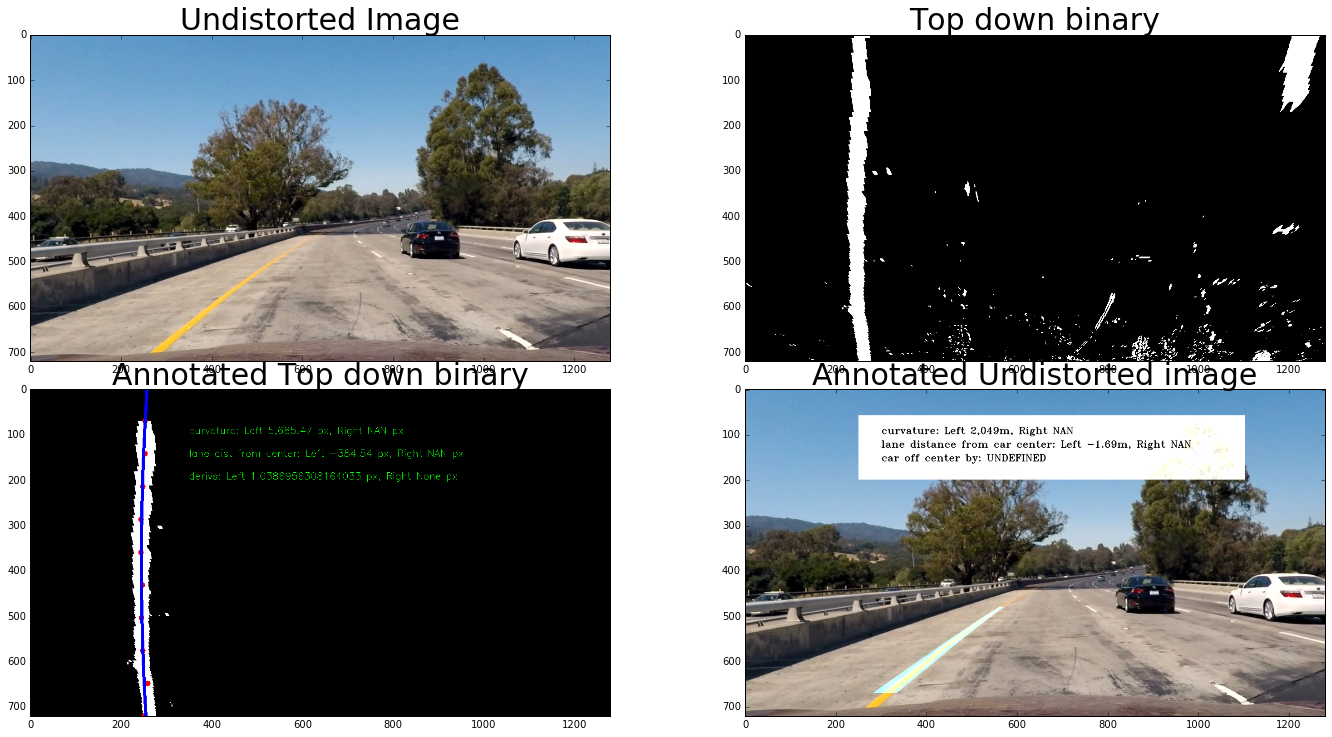

In [79]:
image = mpimg.imread('test_images/test1.jpg')

detector.process_image(image)

# Visualize
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10));
plt.tight_layout()
ax1.imshow(detector._undistorted_image);
ax1.set_title('Undistorted Image', fontsize=30);
ax2.imshow(detector._top_down_binary_image, cmap='gray');
ax2.set_title('Top down binary', fontsize=30);
ax3.imshow(detector._top_down_binary_with_lines_image);
ax3.set_title('Annotated Top down binary', fontsize=30);
ax4.imshow(detector._original_annotated_image);
ax4.set_title('Annotated Undistorted image', fontsize=30);

In [80]:
detector = LaneDetector(dist_pickle['mtx'], dist_pickle['dist'], initial_images_number=1)

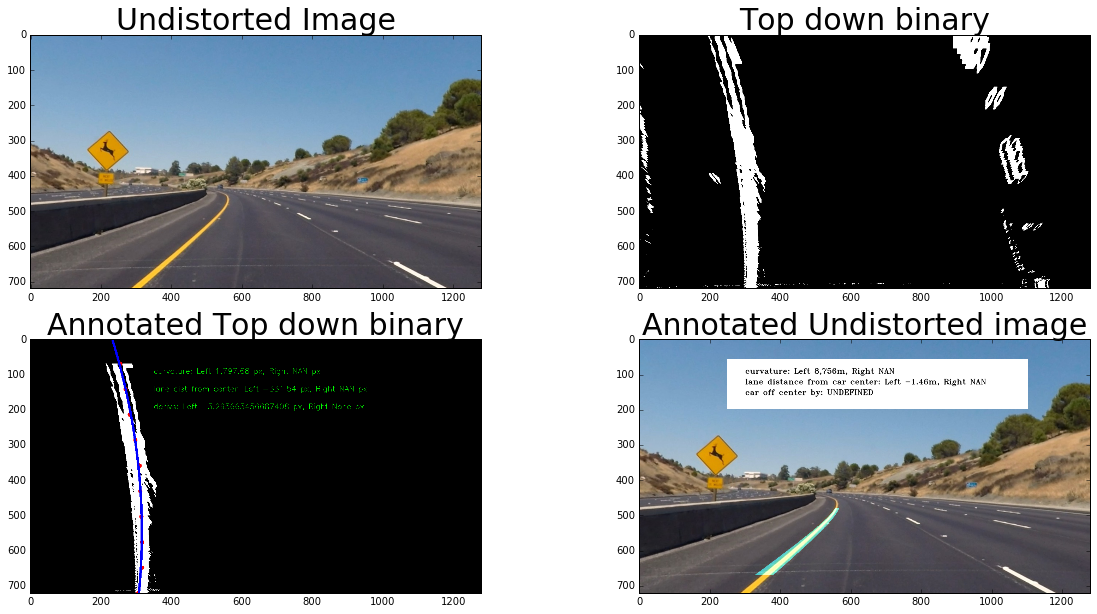

In [81]:
image = mpimg.imread('test_images/test2.jpg')

detector.process_image(image)

# Visualize
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10));
ax1.imshow(detector._undistorted_image);
ax1.set_title('Undistorted Image', fontsize=30);
ax2.imshow(detector._top_down_binary_image, cmap='gray');
ax2.set_title('Top down binary', fontsize=30);
ax3.imshow(detector._top_down_binary_with_lines_image);
ax3.set_title('Annotated Top down binary', fontsize=30);
ax4.imshow(detector._original_annotated_image);
ax4.set_title('Annotated Undistorted image', fontsize=30);

In [82]:
detector = LaneDetector(dist_pickle['mtx'], dist_pickle['dist'], initial_images_number=1)

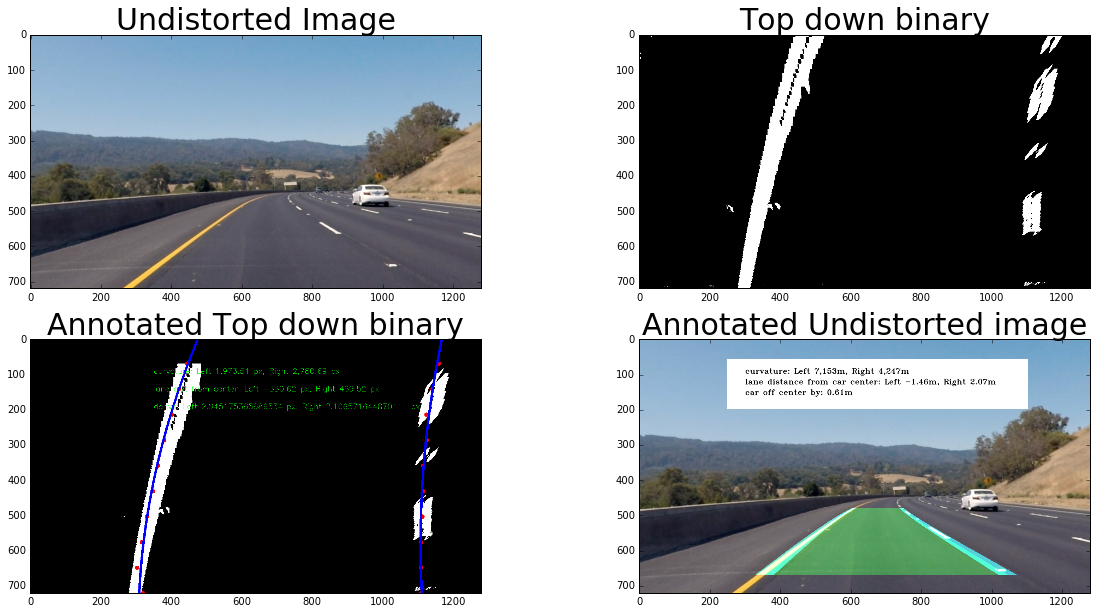

In [83]:
image = mpimg.imread('test_images/test3.jpg')

detector.process_image(image)

# Visualize
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10));
ax1.imshow(detector._undistorted_image);
ax1.set_title('Undistorted Image', fontsize=30);
ax2.imshow(detector._top_down_binary_image, cmap='gray');
ax2.set_title('Top down binary', fontsize=30);
ax3.imshow(detector._top_down_binary_with_lines_image);
ax3.set_title('Annotated Top down binary', fontsize=30);
ax4.imshow(detector._original_annotated_image);
ax4.set_title('Annotated Undistorted image', fontsize=30);

In [84]:
detector = LaneDetector(dist_pickle['mtx'], dist_pickle['dist'], initial_images_number=1)

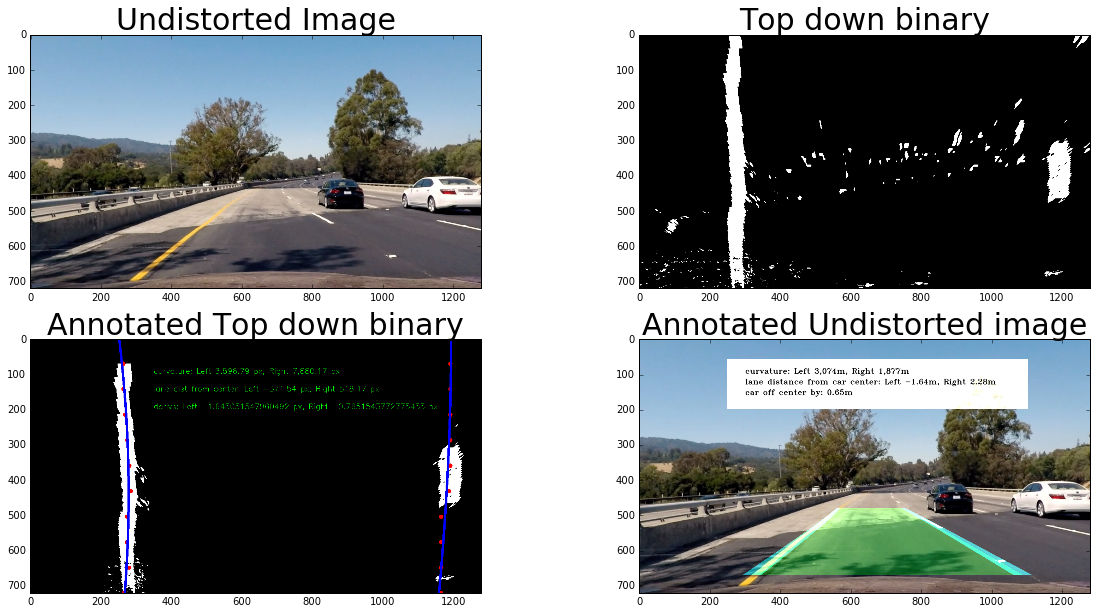

In [85]:
image = mpimg.imread('test_images/test4.jpg')

detector.process_image(image)

# Visualize
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10));
ax1.imshow(detector._undistorted_image);
ax1.set_title('Undistorted Image', fontsize=30);
ax2.imshow(detector._top_down_binary_image, cmap='gray');
ax2.set_title('Top down binary', fontsize=30);
ax3.imshow(detector._top_down_binary_with_lines_image);
ax3.set_title('Annotated Top down binary', fontsize=30);
ax4.imshow(detector._original_annotated_image);
ax4.set_title('Annotated Undistorted image', fontsize=30);

In [86]:
detector = LaneDetector(dist_pickle['mtx'], dist_pickle['dist'], initial_images_number=1)

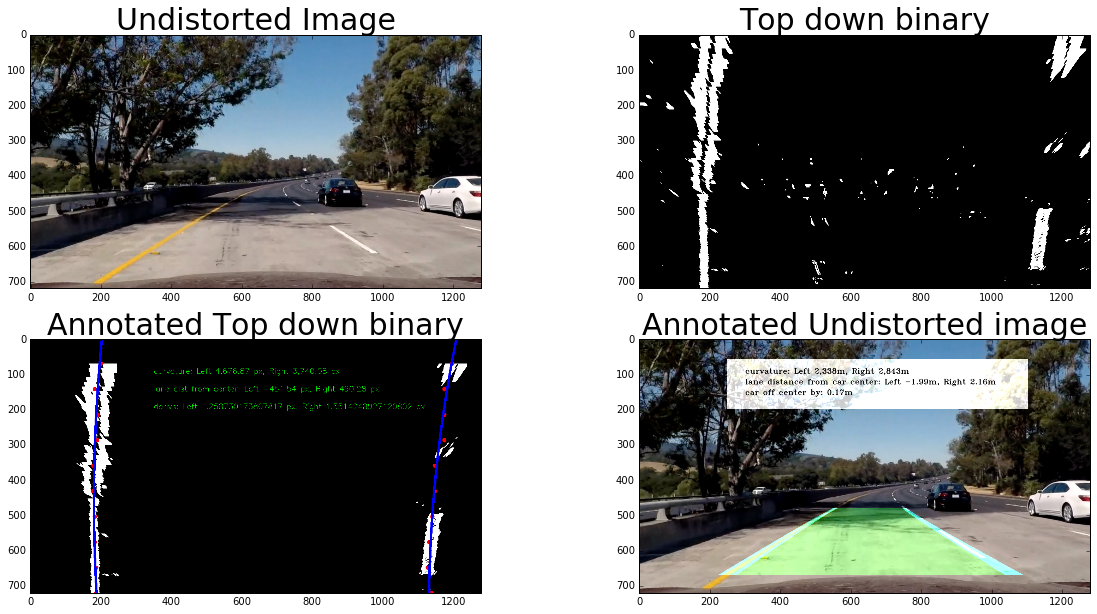

In [87]:
image = mpimg.imread('test_images/test5.jpg')

detector.process_image(image)

# Visualize
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10));
ax1.imshow(detector._undistorted_image);
ax1.set_title('Undistorted Image', fontsize=30);
ax2.imshow(detector._top_down_binary_image, cmap='gray');
ax2.set_title('Top down binary', fontsize=30);
ax3.imshow(detector._top_down_binary_with_lines_image);
ax3.set_title('Annotated Top down binary', fontsize=30);
ax4.imshow(detector._original_annotated_image);
ax4.set_title('Annotated Undistorted image', fontsize=30);

In [88]:
detector = LaneDetector(dist_pickle['mtx'], dist_pickle['dist'], initial_images_number=1)

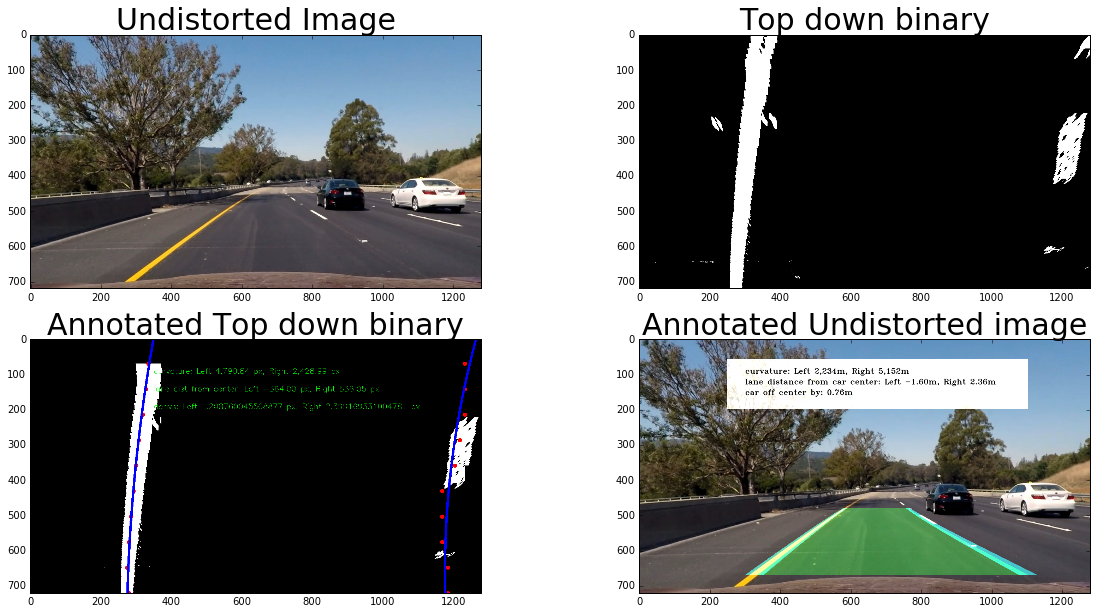

In [89]:
image = mpimg.imread('test_images/test6.jpg')

detector.process_image(image)

# Visualize
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10));
ax1.imshow(detector._undistorted_image);
ax1.set_title('Undistorted Image', fontsize=30);
ax2.imshow(detector._top_down_binary_image, cmap='gray');
ax2.set_title('Top down binary', fontsize=30);
ax3.imshow(detector._top_down_binary_with_lines_image);
ax3.set_title('Annotated Top down binary', fontsize=30);
ax4.imshow(detector._original_annotated_image);
ax4.set_title('Annotated Undistorted image', fontsize=30);

## test `LaneDetector` on video

In [90]:
# Once you have implemented a successful pipeline on the test images,
# you will run your algorithm on a video. 
# In the case of the video, you must search for the lane lines in the first few frames, and, 
# once you have a high-confidence detection, 
# use that information to track the position and curvature of the lines from frame to frame.

In [91]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [92]:
detector = LaneDetector(dist_pickle['mtx'], dist_pickle['dist'])
input_clip = VideoFileClip("project_video.mp4")
annotated_output = 'project_video_annotated.mp4'

In [93]:
annotated_clip = input_clip.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time annotated_clip.write_videofile(annotated_output, audio=False)

[MoviePy] >>>> Building video project_video_annotated.mp4
[MoviePy] Writing video project_video_annotated.mp4


 45%|████▍     | 562/1261 [02:50<03:49,  3.04it/s]

frame 563: NOT PARALLEL


 82%|████████▏ | 1040/1261 [05:25<01:15,  2.92it/s]

frame 1041: NOT PARALLEL


 83%|████████▎ | 1047/1261 [05:28<01:11,  2.98it/s]

frame 1048: NOT PARALLEL


 83%|████████▎ | 1048/1261 [05:28<01:12,  2.92it/s]

frame 1049: NOT PARALLEL


 83%|████████▎ | 1049/1261 [05:28<01:14,  2.86it/s]

frame 1050: NOT PARALLEL


100%|█████████▉| 1260/1261 [06:37<00:00,  3.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_annotated.mp4 

CPU times: user 23min 16s, sys: 3min 8s, total: 26min 24s
Wall time: 6min 39s


In [94]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(annotated_output))

## test `LaneDetector` on 'challenge' video

In [95]:
input_clip = VideoFileClip("challenge_video.mp4")
annotated_output = 'challenge_video_annotated.mp4'

In [96]:
detector = LaneDetector(dist_pickle['mtx'], dist_pickle['dist'])
annotated_clip = input_clip.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time annotated_clip.write_videofile(annotated_output, audio=False)

[MoviePy] >>>> Building video challenge_video_annotated.mp4
[MoviePy] Writing video challenge_video_annotated.mp4


  1%|          | 6/485 [00:01<01:52,  4.24it/s]

frame 7: NOT PARALLEL


  1%|▏         | 7/485 [00:01<01:56,  4.10it/s]

frame 8: NOT PARALLEL


  7%|▋         | 33/485 [00:08<01:51,  4.04it/s]

frame 34: NOT PARALLEL


  7%|▋         | 35/485 [00:08<01:52,  4.01it/s]

frame 36: NOT PARALLEL


  8%|▊         | 37/485 [00:09<01:51,  4.01it/s]

frame 38: NOT PARALLEL


  8%|▊         | 39/485 [00:09<01:52,  3.97it/s]

frame 40: NOT PARALLEL


  8%|▊         | 41/485 [00:10<01:52,  3.95it/s]

frame 42: NOT PARALLEL


  9%|▊         | 42/485 [00:10<01:53,  3.90it/s]

frame 43: NOT PARALLEL


  9%|▉         | 43/485 [00:10<02:00,  3.67it/s]

frame 44: NOT PARALLEL


  9%|▉         | 45/485 [00:11<01:56,  3.77it/s]

frame 46: NOT PARALLEL


 10%|▉         | 47/485 [00:11<01:54,  3.81it/s]

frame 48: NOT PARALLEL


 10%|▉         | 48/485 [00:12<02:06,  3.46it/s]

frame 49: NOT PARALLEL


 10%|█         | 49/485 [00:12<02:14,  3.23it/s]

frame 50: NOT PARALLEL


 10%|█         | 50/485 [00:12<02:17,  3.17it/s]

frame 51: NOT PARALLEL


 11%|█         | 51/485 [00:12<02:12,  3.29it/s]

frame 52: NOT PARALLEL


 11%|█         | 52/485 [00:13<02:12,  3.27it/s]

frame 53: NOT PARALLEL


 11%|█         | 53/485 [00:13<02:08,  3.35it/s]

frame 54: NOT PARALLEL


 11%|█         | 54/485 [00:13<02:10,  3.31it/s]

frame 55: NOT PARALLEL


 11%|█▏        | 55/485 [00:14<02:11,  3.28it/s]

frame 56: NOT PARALLEL


 12%|█▏        | 56/485 [00:14<02:15,  3.16it/s]

frame 57: NOT PARALLEL


 12%|█▏        | 57/485 [00:14<02:17,  3.10it/s]

frame 58: NOT PARALLEL


 12%|█▏        | 58/485 [00:15<02:19,  3.06it/s]

frame 59: NOT PARALLEL


 12%|█▏        | 59/485 [00:15<02:16,  3.12it/s]

frame 60: NOT PARALLEL


 12%|█▏        | 60/485 [00:15<02:15,  3.15it/s]

frame 61: NOT PARALLEL


 13%|█▎        | 61/485 [00:16<02:16,  3.10it/s]

frame 62: NOT PARALLEL
frame 62: WRONG DISTANCE 954.6346443018128, 1279, 1.0614650355996282, 2.6814572923238438


 13%|█▎        | 62/485 [00:16<02:16,  3.09it/s]

frame 63: NOT PARALLEL
frame 63: WRONG DISTANCE 986.5527425879147, 1279, 1.1684666333898595, 2.7047561851613127


 13%|█▎        | 63/485 [00:16<02:21,  2.99it/s]

frame 64: NOT PARALLEL
frame 64: WRONG DISTANCE 1022.975561021089, 1279, 1.203715229118825, 2.7263668305702216


 13%|█▎        | 64/485 [00:17<02:26,  2.88it/s]

frame 65: NOT PARALLEL
frame 65: WRONG DISTANCE 990.3640570344633, 1279, 1.218016357472486, 2.74401588661858


 13%|█▎        | 65/485 [00:17<02:29,  2.80it/s]

frame 66: NOT PARALLEL
frame 66: WRONG DISTANCE 961.2020288533465, 1279, 1.240586077832295, 2.759057258237916


 14%|█▎        | 66/485 [00:17<02:30,  2.78it/s]

frame 67: NOT PARALLEL
frame 67: WRONG DISTANCE 1023, 1279, 1.3410105162916246, 2.771752101927691


 14%|█▍        | 67/485 [00:18<02:32,  2.75it/s]

frame 68: NOT PARALLEL
frame 68: WRONG DISTANCE 971.0043491336968, 1279, 1.35176568135975, 2.7811179436485833


 14%|█▍        | 68/485 [00:18<02:35,  2.69it/s]

frame 69: NOT PARALLEL
frame 69: WRONG DISTANCE 961.8466835309097, 1016, 1.3387139054799155, 2.6425244651140445


 14%|█▍        | 69/485 [00:19<02:30,  2.77it/s]

frame 70: NOT PARALLEL


 14%|█▍        | 70/485 [00:19<02:32,  2.72it/s]

frame 71: NOT PARALLEL
frame 71: WRONG DISTANCE 827.5941265958184, 1012, 0.7278527775306565, 2.4106902047225183


 15%|█▍        | 71/485 [00:19<02:26,  2.82it/s]

frame 72: NOT PARALLEL


 15%|█▍        | 72/485 [00:20<02:30,  2.74it/s]

frame 73: NOT PARALLEL


 15%|█▌        | 73/485 [00:20<02:27,  2.80it/s]

frame 74: NOT PARALLEL


 15%|█▌        | 74/485 [00:20<02:22,  2.88it/s]

frame 75: NOT PARALLEL


 15%|█▌        | 75/485 [00:21<02:19,  2.94it/s]

frame 76: NOT PARALLEL


 16%|█▌        | 76/485 [00:21<02:19,  2.94it/s]

frame 77: NOT PARALLEL


 16%|█▌        | 77/485 [00:21<02:26,  2.78it/s]

frame 78: NOT PARALLEL


 16%|█▌        | 78/485 [00:22<02:34,  2.63it/s]

frame 79: NOT PARALLEL


 16%|█▋        | 79/485 [00:22<02:34,  2.62it/s]

frame 80: NOT PARALLEL


 16%|█▋        | 80/485 [00:23<02:31,  2.68it/s]

frame 81: NOT PARALLEL


 17%|█▋        | 81/485 [00:23<02:29,  2.71it/s]

frame 82: NOT PARALLEL


 17%|█▋        | 82/485 [00:23<02:30,  2.68it/s]

frame 83: NOT PARALLEL


 17%|█▋        | 83/485 [00:24<02:27,  2.73it/s]

frame 84: NOT PARALLEL


 17%|█▋        | 84/485 [00:24<02:29,  2.68it/s]

frame 85: NOT PARALLEL


 18%|█▊        | 85/485 [00:24<02:30,  2.66it/s]

frame 86: NOT PARALLEL


 18%|█▊        | 86/485 [00:25<02:29,  2.67it/s]

frame 87: NOT PARALLEL


 18%|█▊        | 87/485 [00:25<02:28,  2.68it/s]

frame 88: NOT PARALLEL


 18%|█▊        | 88/485 [00:26<02:28,  2.68it/s]

frame 89: NOT PARALLEL


 18%|█▊        | 89/485 [00:26<02:33,  2.58it/s]

frame 90: NOT PARALLEL


 19%|█▊        | 90/485 [00:26<02:32,  2.60it/s]

frame 91: NOT PARALLEL


 19%|█▉        | 91/485 [00:27<02:26,  2.69it/s]

frame 92: NOT PARALLEL


 19%|█▉        | 92/485 [00:27<02:25,  2.70it/s]

frame 93: NOT PARALLEL


 19%|█▉        | 93/485 [00:27<02:23,  2.73it/s]

frame 94: NOT PARALLEL


 19%|█▉        | 94/485 [00:28<02:22,  2.74it/s]

frame 95: NOT PARALLEL


 20%|█▉        | 95/485 [00:28<02:19,  2.80it/s]

frame 96: NOT PARALLEL


 21%|██        | 102/485 [00:30<02:00,  3.18it/s]

frame 103: NOT PARALLEL


 22%|██▏       | 107/485 [00:32<01:53,  3.33it/s]

frame 108: NOT PARALLEL


 22%|██▏       | 108/485 [00:32<02:03,  3.06it/s]

frame 109: NOT PARALLEL


 22%|██▏       | 109/485 [00:33<02:03,  3.05it/s]

frame 110: NOT PARALLEL


 27%|██▋       | 132/485 [00:40<01:39,  3.56it/s]

frame 133: NOT PARALLEL


 27%|██▋       | 133/485 [00:40<01:42,  3.44it/s]

frame 134: NOT PARALLEL


 28%|██▊       | 134/485 [00:41<01:44,  3.36it/s]

frame 135: NOT PARALLEL


 28%|██▊       | 135/485 [00:41<01:45,  3.31it/s]

frame 136: NOT PARALLEL


 28%|██▊       | 136/485 [00:41<01:46,  3.28it/s]

frame 137: NOT PARALLEL


 28%|██▊       | 137/485 [00:42<01:50,  3.16it/s]

frame 138: NOT PARALLEL
frame 138: WRONG DISTANCE 506.55239048470776, 709, -0.6939783653625898, 0.9856929517430927


 28%|██▊       | 138/485 [00:42<01:53,  3.05it/s]

frame 139: NOT PARALLEL
frame 139: WRONG DISTANCE 553.0351240413388, 702, -0.6632416112512336, 0.8975853940465575


 29%|██▊       | 139/485 [00:42<01:52,  3.07it/s]

frame 140: WRONG DISTANCE 698, 842.5497925142629, 0.26372734701373385, 0.8941758091378681


 29%|██▉       | 140/485 [00:43<01:51,  3.09it/s]

frame 141: WRONG DISTANCE 742, 811.1265569175551, 0.39188446263366705, 0.8102615969863163


 29%|██▉       | 141/485 [00:43<01:53,  3.02it/s]

frame 142: NOT PARALLEL
frame 142: WRONG DISTANCE 686, 1057, -0.19865649792931114, 0.9995453919078454


 29%|██▉       | 142/485 [00:43<01:54,  2.99it/s]

frame 143: NOT PARALLEL
frame 143: WRONG DISTANCE 626.4440346754583, 1054, -0.1514163195770031, 1.1633579181757512


 29%|██▉       | 143/485 [00:44<01:53,  3.02it/s]

frame 144: WRONG DISTANCE 698, 1051, 0.20349508535044417, 1.7565772399472825


 30%|██▉       | 144/485 [00:44<01:52,  3.04it/s]

frame 145: WRONG DISTANCE 711, 946.8973702008507, 0.2426697221888181, 1.3317349829137646


 30%|██▉       | 145/485 [00:44<01:52,  3.03it/s]

frame 146: WRONG DISTANCE 689.851349548728, 966.7649218749996, 0.18621254800262185, 1.3890464397022182


 30%|███       | 146/485 [00:45<01:50,  3.07it/s]

frame 147: WRONG DISTANCE 692, 1058, 0.19195188798255708, 1.629162270526164


 30%|███       | 147/485 [00:45<01:48,  3.12it/s]

frame 148: WRONG DISTANCE 739, 1061, 0.3225378639653777, 1.654842448647349


 31%|███       | 148/485 [00:45<01:47,  3.15it/s]

frame 149: WRONG DISTANCE 736, 1058, 0.315540415540016, 1.6692320140649461


 31%|███       | 149/485 [00:45<01:46,  3.14it/s]

frame 150: WRONG DISTANCE 697.1614296027399, 988.4419054550124, 0.21324661777399595, 1.5000574752951406


 31%|███       | 150/485 [00:46<01:46,  3.13it/s]

frame 151: WRONG DISTANCE 695.8254616184993, 996.0846564604369, 0.21056610546812227, 1.5255611013094723


 31%|███       | 151/485 [00:46<01:45,  3.17it/s]

frame 152: WRONG DISTANCE 696.9312447682842, 1002.2831600144962, 0.2159219637436141, 1.5521185118692697


 31%|███▏      | 152/485 [00:46<01:45,  3.14it/s]

frame 153: WRONG DISTANCE 698.0196157758133, 998.7849569187238, 0.22298610721411344, 1.5468387949365239


 32%|███▏      | 153/485 [00:47<01:45,  3.16it/s]

frame 154: WRONG DISTANCE 693.4994279017019, 993.8810072367187, 0.20749203562159158, 1.5577353776236464


 32%|███▏      | 154/485 [00:47<01:44,  3.17it/s]

frame 155: WRONG DISTANCE 688.5934474081085, 988.8184572577622, 0.19852140335578336, 1.5531817427123384


 32%|███▏      | 155/485 [00:47<01:45,  3.12it/s]

frame 156: WRONG DISTANCE 687.9248430777681, 991.2305861567054, 0.19072451170657068, 1.617331699083399


 32%|███▏      | 156/485 [00:48<01:45,  3.11it/s]

frame 157: WRONG DISTANCE 687.0239274691354, 995.397467352927, 0.1902548520888703, 1.6138775127960592


 32%|███▏      | 157/485 [00:48<01:45,  3.11it/s]

frame 158: WRONG DISTANCE 685.8585018588659, 998.2016598274406, 0.17492258801083957, 1.6253911192746164


 33%|███▎      | 158/485 [00:48<01:45,  3.11it/s]

frame 159: WRONG DISTANCE 683.6761582842307, 1001.7683599595487, 0.15989095887153534, 1.6307575438857258


 33%|███▎      | 159/485 [00:49<01:45,  3.09it/s]

frame 160: WRONG DISTANCE 681.5148120966608, 1005.0839610222592, 0.15023530942624183, 1.6369132644337698


 33%|███▎      | 160/485 [00:49<01:43,  3.13it/s]

frame 161: WRONG DISTANCE 679.3223624263464, 1008.8858247112323, 0.1404382841483892, 1.6073396784060832


 33%|███▎      | 161/485 [00:49<01:43,  3.12it/s]

frame 162: WRONG DISTANCE 677.0390958777587, 1008.4321329615598, 0.13078420404371352, 1.606203553686806


 33%|███▎      | 162/485 [00:50<01:43,  3.12it/s]

frame 163: WRONG DISTANCE 674.3388069935462, 1008.0836937371396, 0.11648619336553272, 1.6060828895456707


 34%|███▎      | 163/485 [00:50<01:43,  3.12it/s]

frame 164: WRONG DISTANCE 671.6854788042458, 1007.206995738636, 0.10384036942674081, 1.6089438934024438


 34%|███▍      | 164/485 [00:50<01:43,  3.10it/s]

frame 165: WRONG DISTANCE 669.140479067293, 1006.2165380950707, 0.09966417960120759, 1.6074335015443186


 34%|███▍      | 165/485 [00:51<01:43,  3.09it/s]

frame 166: WRONG DISTANCE 666.8442764157778, 1004.8779975098199, 0.09104156374425385, 1.6017405729785998


 34%|███▍      | 166/485 [00:51<01:42,  3.11it/s]

frame 167: WRONG DISTANCE 664.6013983001307, 1004.6237678579776, 0.08864952044697279, 1.6115241429952087


 34%|███▍      | 167/485 [00:51<01:42,  3.09it/s]

frame 168: WRONG DISTANCE 662.6882559097921, 1004.8653513725212, 0.08500190810079088, 1.6110238046351673


 35%|███▍      | 168/485 [00:52<01:43,  3.07it/s]

frame 169: WRONG DISTANCE 661.2586991734471, 1005.0896956252336, 0.08369836730886278, 1.6144450830470418


 35%|███▍      | 169/485 [00:52<01:42,  3.07it/s]

frame 170: WRONG DISTANCE 660.3441434016083, 1005.3394793712584, 0.07966013462515685, 1.6415281338830545


 35%|███▌      | 170/485 [00:52<01:42,  3.09it/s]

frame 171: WRONG DISTANCE 659.4358516297227, 1006.8875599747469, 0.07526293941397881, 1.647301571296071


 35%|███▌      | 171/485 [00:53<01:41,  3.11it/s]

frame 172: WRONG DISTANCE 658.719416795267, 1008.9562755740268, 0.07536077151586393, 1.6480997161770063


 36%|███▌      | 173/485 [00:53<01:37,  3.19it/s]

frame 174: NOT PARALLEL


 36%|███▌      | 175/485 [00:54<01:35,  3.24it/s]

frame 176: NOT PARALLEL


 37%|███▋      | 180/485 [00:55<01:29,  3.39it/s]

frame 181: NOT PARALLEL


 37%|███▋      | 181/485 [00:56<01:31,  3.32it/s]

frame 182: NOT PARALLEL


 42%|████▏     | 202/485 [01:02<01:25,  3.31it/s]

frame 203: NOT PARALLEL


 42%|████▏     | 203/485 [01:02<01:26,  3.27it/s]

frame 204: NOT PARALLEL


 42%|████▏     | 204/485 [01:02<01:26,  3.23it/s]

frame 205: NOT PARALLEL


 42%|████▏     | 205/485 [01:03<01:28,  3.17it/s]

frame 206: NOT PARALLEL


 42%|████▏     | 206/485 [01:03<01:29,  3.12it/s]

frame 207: NOT PARALLEL


 43%|████▎     | 207/485 [01:03<01:30,  3.09it/s]

frame 208: NOT PARALLEL


 43%|████▎     | 208/485 [01:04<01:29,  3.09it/s]

frame 209: NOT PARALLEL


 43%|████▎     | 209/485 [01:04<01:31,  3.02it/s]

frame 210: NOT PARALLEL


 43%|████▎     | 210/485 [01:04<01:31,  3.00it/s]

frame 211: NOT PARALLEL


 44%|████▎     | 211/485 [01:05<01:31,  3.01it/s]

frame 212: NOT PARALLEL


 44%|████▎     | 212/485 [01:05<01:31,  2.99it/s]

frame 213: NOT PARALLEL


 44%|████▍     | 213/485 [01:05<01:30,  2.99it/s]

frame 214: NOT PARALLEL


 44%|████▍     | 214/485 [01:06<01:29,  3.03it/s]

frame 215: NOT PARALLEL


 44%|████▍     | 215/485 [01:06<01:28,  3.04it/s]

frame 216: NOT PARALLEL


 45%|████▍     | 216/485 [01:06<01:28,  3.04it/s]

frame 217: NOT PARALLEL


 45%|████▍     | 217/485 [01:07<01:29,  3.00it/s]

frame 218: NOT PARALLEL


 45%|████▍     | 218/485 [01:07<01:29,  3.00it/s]

frame 219: NOT PARALLEL


 45%|████▌     | 219/485 [01:07<01:29,  2.97it/s]

frame 220: NOT PARALLEL


 45%|████▌     | 220/485 [01:08<01:29,  2.97it/s]

frame 221: NOT PARALLEL


 46%|████▌     | 221/485 [01:08<01:28,  2.97it/s]

frame 222: NOT PARALLEL


 46%|████▌     | 222/485 [01:08<01:29,  2.95it/s]

frame 223: NOT PARALLEL


 46%|████▌     | 223/485 [01:09<01:29,  2.92it/s]

frame 224: NOT PARALLEL


 46%|████▌     | 224/485 [01:09<01:30,  2.90it/s]

frame 225: NOT PARALLEL


 46%|████▋     | 225/485 [01:09<01:28,  2.92it/s]

frame 226: NOT PARALLEL


 47%|████▋     | 226/485 [01:10<01:27,  2.96it/s]

frame 227: NOT PARALLEL


 47%|████▋     | 228/485 [01:10<01:23,  3.07it/s]

frame 229: NOT PARALLEL


 48%|████▊     | 232/485 [01:12<01:19,  3.20it/s]

frame 233: NOT PARALLEL


 48%|████▊     | 233/485 [01:12<01:20,  3.15it/s]

frame 234: NOT PARALLEL


 48%|████▊     | 234/485 [01:12<01:20,  3.13it/s]

frame 235: NOT PARALLEL


 48%|████▊     | 235/485 [01:13<01:20,  3.12it/s]

frame 236: NOT PARALLEL


 49%|████▊     | 236/485 [01:13<01:20,  3.09it/s]

frame 237: NOT PARALLEL


 49%|████▉     | 237/485 [01:13<01:20,  3.08it/s]

frame 238: NOT PARALLEL


 68%|██████▊   | 329/485 [01:43<00:53,  2.93it/s]

frame 330: NOT PARALLEL


 68%|██████▊   | 330/485 [01:44<00:52,  2.93it/s]

frame 331: NOT PARALLEL


 70%|██████▉   | 339/485 [01:46<00:49,  2.96it/s]

frame 340: NOT PARALLEL


 70%|███████   | 340/485 [01:47<00:49,  2.92it/s]

frame 341: NOT PARALLEL


 71%|███████   | 342/485 [01:47<00:47,  2.98it/s]

frame 343: NOT PARALLEL


 71%|███████   | 343/485 [01:48<00:47,  2.98it/s]

frame 344: NOT PARALLEL


 71%|███████   | 344/485 [01:48<00:47,  2.98it/s]

frame 345: NOT PARALLEL


 76%|███████▋  | 371/485 [01:57<00:35,  3.18it/s]

frame 372: NOT PARALLEL


100%|██████████| 485/485 [02:30<00:00,  3.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_annotated.mp4 

CPU times: user 8min 48s, sys: 1min 12s, total: 10min 1s
Wall time: 2min 31s


In [97]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(annotated_output))

## test `LaneDetector` on harder 'challenge' video

In [98]:
input_clip = VideoFileClip("harder_challenge_video.mp4")
annotated_output = 'harder_challenge_video_annotated.mp4'

In [99]:
detector = LaneDetector(dist_pickle['mtx'], dist_pickle['dist'])
annotated_clip = input_clip.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time annotated_clip.write_videofile(annotated_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_annotated.mp4
[MoviePy] Writing video harder_challenge_video_annotated.mp4


  2%|▏         | 24/1200 [00:06<06:02,  3.24it/s]

frame 25: NOT PARALLEL


  2%|▏         | 26/1200 [00:07<06:18,  3.10it/s]

frame 27: NOT PARALLEL


  2%|▏         | 28/1200 [00:07<06:14,  3.13it/s]

frame 29: NOT PARALLEL


  2%|▎         | 30/1200 [00:08<06:13,  3.13it/s]

frame 31: NOT PARALLEL


  3%|▎         | 32/1200 [00:08<06:10,  3.15it/s]

frame 33: NOT PARALLEL


  3%|▎         | 34/1200 [00:09<06:18,  3.08it/s]

frame 35: NOT PARALLEL


  7%|▋         | 81/1200 [00:24<05:39,  3.29it/s]

frame 82: NOT PARALLEL


  7%|▋         | 82/1200 [00:24<05:51,  3.18it/s]

frame 83: NOT PARALLEL


  7%|▋         | 83/1200 [00:24<06:04,  3.07it/s]

frame 84: NOT PARALLEL


  7%|▋         | 84/1200 [00:25<06:01,  3.09it/s]

frame 85: NOT PARALLEL


  7%|▋         | 85/1200 [00:25<05:56,  3.12it/s]

frame 86: NOT PARALLEL


  7%|▋         | 86/1200 [00:25<05:55,  3.14it/s]

frame 87: NOT PARALLEL


  7%|▋         | 87/1200 [00:26<05:48,  3.20it/s]

frame 88: NOT PARALLEL


  7%|▋         | 88/1200 [00:26<05:46,  3.20it/s]

frame 89: NOT PARALLEL


  7%|▋         | 89/1200 [00:26<05:42,  3.25it/s]

frame 90: NOT PARALLEL


  9%|▉         | 106/1200 [00:32<06:58,  2.62it/s]

frame 107: NOT PARALLEL


  9%|▉         | 107/1200 [00:32<06:41,  2.72it/s]

frame 108: NOT PARALLEL


  9%|▉         | 108/1200 [00:33<06:29,  2.80it/s]

frame 109: NOT PARALLEL


  9%|▉         | 109/1200 [00:33<06:18,  2.88it/s]

frame 110: NOT PARALLEL


  9%|▉         | 110/1200 [00:33<06:13,  2.92it/s]

frame 111: NOT PARALLEL


  9%|▉         | 111/1200 [00:34<06:04,  2.99it/s]

frame 112: NOT PARALLEL


  9%|▉         | 112/1200 [00:34<06:02,  3.01it/s]

frame 113: NOT PARALLEL


  9%|▉         | 113/1200 [00:34<05:52,  3.09it/s]

frame 114: NOT PARALLEL


 10%|▉         | 114/1200 [00:35<05:53,  3.07it/s]

frame 115: NOT PARALLEL


 10%|▉         | 115/1200 [00:35<05:54,  3.06it/s]

frame 116: NOT PARALLEL


 10%|▉         | 116/1200 [00:35<05:56,  3.04it/s]

frame 117: NOT PARALLEL


 10%|▉         | 118/1200 [00:36<05:39,  3.19it/s]

frame 119: NOT PARALLEL


 10%|█         | 120/1200 [00:36<05:37,  3.20it/s]

frame 121: NOT PARALLEL


 10%|█         | 126/1200 [00:38<06:04,  2.95it/s]

frame 127: NOT PARALLEL


 11%|█         | 128/1200 [00:39<05:51,  3.05it/s]

frame 129: NOT PARALLEL


 11%|█         | 129/1200 [00:39<05:57,  3.00it/s]

frame 130: NOT PARALLEL


 11%|█         | 130/1200 [00:40<05:56,  3.00it/s]

frame 131: NOT PARALLEL


 11%|█         | 131/1200 [00:40<05:59,  2.98it/s]

frame 132: NOT PARALLEL


 11%|█         | 133/1200 [00:41<05:44,  3.10it/s]

frame 134: NOT PARALLEL


 11%|█         | 134/1200 [00:41<05:44,  3.09it/s]

frame 135: NOT PARALLEL


 11%|█▏        | 135/1200 [00:41<05:48,  3.06it/s]

frame 136: NOT PARALLEL


 11%|█▏        | 136/1200 [00:42<05:41,  3.11it/s]

frame 137: NOT PARALLEL


 11%|█▏        | 137/1200 [00:42<05:40,  3.12it/s]

frame 138: NOT PARALLEL


 12%|█▏        | 138/1200 [00:42<05:35,  3.17it/s]

frame 139: NOT PARALLEL


 12%|█▏        | 139/1200 [00:43<05:35,  3.16it/s]

frame 140: NOT PARALLEL


 12%|█▏        | 140/1200 [00:43<05:32,  3.18it/s]

frame 141: NOT PARALLEL


 12%|█▏        | 141/1200 [00:43<05:35,  3.16it/s]

frame 142: NOT PARALLEL


 12%|█▏        | 142/1200 [00:44<05:33,  3.17it/s]

frame 143: NOT PARALLEL


 12%|█▏        | 143/1200 [00:44<05:51,  3.00it/s]

frame 144: NOT PARALLEL
frame 144: WRONG DISTANCE 256.18497378296826, 303, -1.683411266160221, -0.1416124511100641


 12%|█▏        | 144/1200 [00:44<05:56,  2.96it/s]

frame 145: NOT PARALLEL
frame 145: WRONG DISTANCE 246.6785585309107, 306, -1.7031356941201952, -0.3906268950687885


 12%|█▏        | 145/1200 [00:45<06:01,  2.92it/s]

frame 146: NOT PARALLEL
frame 146: WRONG DISTANCE 302, 357.367012222922, -1.6891630564084703, -0.5571815324196248


 12%|█▏        | 146/1200 [00:45<06:04,  2.89it/s]

frame 147: NOT PARALLEL
frame 147: WRONG DISTANCE 301, 354.04420664983, -1.6815550020036913, -0.6975543648404549


 12%|█▏        | 147/1200 [00:45<06:01,  2.91it/s]

frame 148: NOT PARALLEL
frame 148: WRONG DISTANCE 295, 350.4566229716127, -1.6798711750612467, -0.8146243927051252


 12%|█▏        | 148/1200 [00:46<06:01,  2.91it/s]

frame 149: NOT PARALLEL
frame 149: WRONG DISTANCE 294, 347.71756552796325, -1.6738979384972976, -0.9335895533622992


 12%|█▏        | 149/1200 [00:46<06:05,  2.87it/s]

frame 150: NOT PARALLEL
frame 150: WRONG DISTANCE 293, 342.0731068205184, -1.6713022067773031, -1.0334887566166693


 12%|█▎        | 150/1200 [00:46<06:06,  2.86it/s]

frame 151: NOT PARALLEL
frame 151: WRONG DISTANCE 282, 339.9662552024864, -1.6796823621999468, -1.0979812917488865


 13%|█▎        | 151/1200 [00:47<06:04,  2.88it/s]

frame 152: NOT PARALLEL
frame 152: WRONG DISTANCE 282, 398, -1.686716234097012, -1.0537120887645477


 13%|█▎        | 152/1200 [00:47<06:00,  2.91it/s]

frame 153: NOT PARALLEL
frame 153: WRONG DISTANCE 258.0445151456694, 351.3112074448174, -1.7088074660698869, -1.1041317732085136


 13%|█▎        | 153/1200 [00:47<06:00,  2.91it/s]

frame 154: NOT PARALLEL
frame 154: WRONG DISTANCE 252.41258636714343, 350.27115091891017, -1.7240597212163882, -1.1587410747037992


 13%|█▎        | 154/1200 [00:48<05:59,  2.91it/s]

frame 155: NOT PARALLEL
frame 155: WRONG DISTANCE 246.27996206275697, 351.7364703165907, -1.7402026549700387, -1.1916416445409328


 13%|█▎        | 155/1200 [00:48<05:59,  2.91it/s]

frame 156: NOT PARALLEL
frame 156: WRONG DISTANCE 239.7481624696032, 356.72387477202466, -1.7575007900716488, -1.2126561395711233


 13%|█▎        | 156/1200 [00:48<06:04,  2.87it/s]

frame 157: NOT PARALLEL
frame 157: WRONG DISTANCE 234.5950872731947, 359.41356896511303, -1.775274584151982, -1.2273648496793745


 13%|█▎        | 157/1200 [00:49<06:08,  2.83it/s]

frame 158: NOT PARALLEL
frame 158: WRONG DISTANCE 228.6234574039, 340.817130740272, -1.7938056631582031, -1.257424245627038


 13%|█▎        | 158/1200 [00:49<06:07,  2.84it/s]

frame 159: NOT PARALLEL
frame 159: WRONG DISTANCE 225.41068056140097, 337.5546924978946, -1.811007061768629, -1.284010123843668


 13%|█▎        | 159/1200 [00:50<06:06,  2.84it/s]

frame 160: NOT PARALLEL
frame 160: WRONG DISTANCE 221.10879471801346, 336.95646011620744, -1.8233531206411648, -1.3066938304308768


 13%|█▎        | 160/1200 [00:50<06:05,  2.84it/s]

frame 161: NOT PARALLEL
frame 161: WRONG DISTANCE 218.02290868757012, 333.58807224443416, -1.8349456423528063, -1.3270321661644033


 13%|█▎        | 161/1200 [00:50<06:02,  2.87it/s]

frame 162: NOT PARALLEL
frame 162: WRONG DISTANCE 215.54275652941456, 328.51758753624097, -1.8465116695922332, -1.3451544110438032


 14%|█▎        | 162/1200 [00:51<05:57,  2.91it/s]

frame 163: NOT PARALLEL
frame 163: WRONG DISTANCE 213.4356724653947, 322.54933302936666, -1.857543179850925, -1.3642075413553914


 14%|█▎        | 163/1200 [00:51<06:17,  2.74it/s]

frame 164: NOT PARALLEL
frame 164: WRONG DISTANCE 211.9037285178171, 319.69977000911774, -1.8684493646141151, -1.3826059042315775


 14%|█▎        | 164/1200 [00:51<06:31,  2.64it/s]

frame 165: NOT PARALLEL
frame 165: WRONG DISTANCE 210.4388844170876, 316.71001844252606, -1.8761811046845123, -1.4172328927372375


 14%|█▍        | 165/1200 [00:52<06:45,  2.55it/s]

frame 166: NOT PARALLEL
frame 166: WRONG DISTANCE 208.8782684483727, 309.5217892758594, -1.8864944352000477, -1.4356137552011214


 14%|█▍        | 166/1200 [00:52<06:49,  2.52it/s]

frame 167: NOT PARALLEL
frame 167: WRONG DISTANCE 206.77000339038537, 304.94711767559755, -1.8967281370838889, -1.4552445185994032


 14%|█▍        | 167/1200 [00:53<07:10,  2.40it/s]

frame 168: NOT PARALLEL
frame 168: WRONG DISTANCE 204.73188341750847, 299.6744521312656, -1.906576803722357, -1.4831566007614077


 14%|█▍        | 168/1200 [00:53<06:55,  2.48it/s]

frame 169: NOT PARALLEL
frame 169: WRONG DISTANCE 202.72032182355977, 292.66454466540324, -1.909268632310169, -1.517415070159586


 14%|█▍        | 169/1200 [00:53<06:51,  2.51it/s]

frame 170: NOT PARALLEL
frame 170: WRONG DISTANCE 202.3588111146184, 283.66294156846163, -1.9177785995358667, -1.5398916592653895


 14%|█▍        | 170/1200 [00:54<06:43,  2.55it/s]

frame 171: NOT PARALLEL
frame 171: WRONG DISTANCE 200.32871711910775, 280.30034579007594, -1.9268427505957215, -1.559460250867265


 14%|█▍        | 171/1200 [00:54<06:39,  2.57it/s]

frame 172: NOT PARALLEL
frame 172: WRONG DISTANCE 198.72356349957911, 274.4613281542267, -1.9340923141425859, -1.5749029787787578


 14%|█▍        | 172/1200 [00:55<06:31,  2.63it/s]

frame 173: NOT PARALLEL
frame 173: WRONG DISTANCE 197.56901193649452, 269.7888250561158, -1.939813387232808, -1.5926388029159677


 14%|█▍        | 173/1200 [00:55<06:27,  2.65it/s]

frame 174: NOT PARALLEL
frame 174: WRONG DISTANCE 196.80955162153936, 266.6659697671148, -1.944539800261101, -1.6010165009645072


 14%|█▍        | 174/1200 [00:55<06:21,  2.69it/s]

frame 175: NOT PARALLEL
frame 175: WRONG DISTANCE 194.8385254161989, 267.57052057028534, -1.939085436463396, -1.5929183582804753


 15%|█▍        | 175/1200 [00:56<06:16,  2.72it/s]

frame 176: NOT PARALLEL
frame 176: WRONG DISTANCE 196.40730429292915, 270.7158541725113, -1.931369758167402, -1.5909075225641078


 15%|█▍        | 176/1200 [00:56<06:07,  2.78it/s]

frame 177: NOT PARALLEL
frame 177: WRONG DISTANCE 199.24933349700692, 273.2072686354275, -1.9207372004770742, -1.5902734230112436


 15%|█▍        | 177/1200 [00:56<06:01,  2.83it/s]

frame 178: NOT PARALLEL
frame 178: WRONG DISTANCE 203.10350770435818, 275.4292668583979, -1.9069294438364404, -1.5830735492071226


 15%|█▍        | 178/1200 [00:57<05:59,  2.84it/s]

frame 179: NOT PARALLEL
frame 179: WRONG DISTANCE 208.14347420968926, 280.392442977225, -1.8893238660604588, -1.569909787062603


 15%|█▍        | 179/1200 [00:57<05:56,  2.86it/s]

frame 180: NOT PARALLEL
frame 180: WRONG DISTANCE 214.70654847081897, 285.71725086513186, -1.8719741178851663, -1.5549788675241405


 15%|█▌        | 180/1200 [00:57<05:56,  2.86it/s]

frame 181: NOT PARALLEL
frame 181: WRONG DISTANCE 219.91422409862474, 288.68088883627854, -1.8537098910222156, -1.5416020506470143


 15%|█▌        | 181/1200 [00:58<05:58,  2.84it/s]

frame 182: NOT PARALLEL
frame 182: WRONG DISTANCE 225.3562463465671, 292.9839317071165, -1.8324930731234308, -1.5290349018080416


 15%|█▌        | 182/1200 [00:58<06:00,  2.82it/s]

frame 183: NOT PARALLEL
frame 183: WRONG DISTANCE 231.28533722643056, 297.93179135100905, -1.810718015201548, -1.513997580681393


 15%|█▌        | 183/1200 [00:58<06:08,  2.76it/s]

frame 184: NOT PARALLEL
frame 184: WRONG DISTANCE 237.10089032687952, 302.4916635977823, -1.7890339810610778, -1.4978674591428232


 15%|█▌        | 184/1200 [00:59<06:08,  2.75it/s]

frame 185: NOT PARALLEL
frame 185: WRONG DISTANCE 242.39532907196934, 306.30152970678904, -1.7673594257362972, -1.4819719240928313


 15%|█▌        | 185/1200 [00:59<06:12,  2.72it/s]

frame 186: NOT PARALLEL
frame 186: WRONG DISTANCE 247.93088006804118, 309.79163460414213, -1.7457039435091954, -1.4661940494209265


 16%|█▌        | 186/1200 [01:00<06:13,  2.71it/s]

frame 187: NOT PARALLEL
frame 187: WRONG DISTANCE 253.45085919963495, 313.65164948091916, -1.7286067697973695, -1.4495607028970596


 16%|█▌        | 187/1200 [01:00<06:13,  2.71it/s]

frame 188: NOT PARALLEL
frame 188: WRONG DISTANCE 257.41964246048417, 317.99871711910663, -1.716956517200953, -1.431733582256343


 16%|█▌        | 188/1200 [01:00<06:14,  2.71it/s]

frame 189: NOT PARALLEL
frame 189: WRONG DISTANCE 259.83803772680477, 322.2406352296099, -1.697092883897981, -1.413896733934952


 16%|█▌        | 189/1200 [01:01<06:17,  2.68it/s]

frame 190: NOT PARALLEL
frame 190: WRONG DISTANCE 263.6820363648051, 326.3633385358201, -1.6838907599479096, -1.3982193411045527


 16%|█▌        | 190/1200 [01:01<06:15,  2.69it/s]

frame 191: NOT PARALLEL
frame 191: WRONG DISTANCE 265.9331882482226, 330.12653917648606, -1.6793078856219794, -1.3809820840758953


 16%|█▌        | 191/1200 [01:01<06:16,  2.68it/s]

frame 192: NOT PARALLEL
frame 192: WRONG DISTANCE 265.8471734415915, 334.2606783985681, -1.6792318192175197, -1.3651141670054647


 16%|█▌        | 192/1200 [01:02<06:14,  2.69it/s]

frame 193: NOT PARALLEL
frame 193: WRONG DISTANCE 264.9976619785819, 337.9559890572382, -1.6741834984912, -1.3481775451883564


 16%|█▌        | 193/1200 [01:02<06:14,  2.69it/s]

frame 194: NOT PARALLEL
frame 194: WRONG DISTANCE 265.740734661429, 341.5881509539834, -1.6670135427558195, -1.3316067417870208


 16%|█▌        | 194/1200 [01:03<06:11,  2.71it/s]

frame 195: NOT PARALLEL
frame 195: WRONG DISTANCE 264.80105303614835, 345.0946202768415, -1.6650017505189225, -1.3149372612347907


 16%|█▋        | 195/1200 [01:03<06:03,  2.76it/s]

frame 196: NOT PARALLEL
frame 196: WRONG DISTANCE 263.62630997474736, 349.05626145716326, -1.6643795730767745, -1.2993257451329319


 16%|█▋        | 196/1200 [01:03<05:58,  2.80it/s]

frame 197: NOT PARALLEL
frame 197: WRONG DISTANCE 263.5847878670968, 352.4686309273278, -1.665028579209771, -1.28425707878685


 16%|█▋        | 197/1200 [01:04<05:57,  2.81it/s]

frame 198: NOT PARALLEL
frame 198: WRONG DISTANCE 264.0980028876729, 355.99481858515594, -1.6602751894665184, -1.2736870451167226


 16%|█▋        | 198/1200 [01:04<06:03,  2.75it/s]

frame 199: NOT PARALLEL
frame 199: WRONG DISTANCE 264.67594945403096, 490, -1.6701820207646052, -1.2121059156270315


 17%|█▋        | 199/1200 [01:04<06:09,  2.71it/s]

frame 200: NOT PARALLEL
frame 200: WRONG DISTANCE 261.43056967241864, 453, -1.6845271462697613, -1.1863256292056588


 17%|█▋        | 200/1200 [01:05<06:09,  2.71it/s]

frame 201: NOT PARALLEL
frame 201: WRONG DISTANCE 257.5732412376077, 460, -1.692103345765414, -1.159023036182791


 17%|█▋        | 201/1200 [01:05<05:58,  2.79it/s]

frame 202: WRONG DISTANCE 391, 387.8098481048904, -1.256661427122583, -1.2708399934711452


 17%|█▋        | 202/1200 [01:05<05:48,  2.87it/s]

frame 203: WRONG DISTANCE 364, 434, -1.3624511177868033, -1.112396846586737


 17%|█▋        | 203/1200 [01:06<05:55,  2.80it/s]

frame 204: NOT PARALLEL
frame 204: WRONG DISTANCE 286.1448835870276, 391, -1.5731168762108607, -1.1861549317994542


 17%|█▋        | 204/1200 [01:06<06:00,  2.76it/s]

frame 205: NOT PARALLEL
frame 205: WRONG DISTANCE 289.33387491816296, 419, -1.58657587777773, -1.1800040267900227


 17%|█▋        | 205/1200 [01:07<06:06,  2.72it/s]

frame 206: NOT PARALLEL
frame 206: WRONG DISTANCE 293.9423312406469, 389, -1.5983577455410374, -1.1922008802881334


 17%|█▋        | 206/1200 [01:07<05:55,  2.80it/s]

frame 207: WRONG DISTANCE 297.4350479330338, 364, -1.6476749147254075, -1.4083393757626987


 17%|█▋        | 207/1200 [01:07<05:51,  2.83it/s]

frame 208: WRONG DISTANCE 279.680922009446, 359.5060404975678, -1.7053817063102366, -1.4365363159886455


 17%|█▋        | 209/1200 [01:08<05:47,  2.85it/s]

frame 210: NOT PARALLEL
frame 210: WRONG DISTANCE 268.1651800411522, 518.887597853535, -1.6401497699005545, -0.27098980356605196


 18%|█▊        | 211/1200 [01:09<05:46,  2.85it/s]

frame 212: NOT PARALLEL


 18%|█▊        | 213/1200 [01:09<05:49,  2.82it/s]

frame 214: NOT PARALLEL


 18%|█▊        | 214/1200 [01:10<05:55,  2.78it/s]

frame 215: NOT PARALLEL


 18%|█▊        | 216/1200 [01:10<05:40,  2.89it/s]

frame 217: NOT PARALLEL


 18%|█▊        | 217/1200 [01:11<05:45,  2.85it/s]

frame 218: NOT PARALLEL


 18%|█▊        | 218/1200 [01:11<05:47,  2.83it/s]

frame 219: NOT PARALLEL


 18%|█▊        | 219/1200 [01:11<05:47,  2.82it/s]

frame 220: NOT PARALLEL


 18%|█▊        | 220/1200 [01:12<05:44,  2.84it/s]

frame 221: NOT PARALLEL


 18%|█▊        | 221/1200 [01:12<05:44,  2.84it/s]

frame 222: NOT PARALLEL


 18%|█▊        | 222/1200 [01:12<05:43,  2.85it/s]

frame 223: NOT PARALLEL


 19%|█▊        | 223/1200 [01:13<05:42,  2.86it/s]

frame 224: NOT PARALLEL


 19%|█▊        | 224/1200 [01:13<05:38,  2.88it/s]

frame 225: NOT PARALLEL


 19%|█▉        | 225/1200 [01:13<05:42,  2.84it/s]

frame 226: NOT PARALLEL


 19%|█▉        | 226/1200 [01:14<05:46,  2.81it/s]

frame 227: NOT PARALLEL


 19%|█▉        | 227/1200 [01:14<05:51,  2.77it/s]

frame 228: NOT PARALLEL


 19%|█▉        | 228/1200 [01:15<05:49,  2.78it/s]

frame 229: NOT PARALLEL


 19%|█▉        | 229/1200 [01:15<05:49,  2.78it/s]

frame 230: NOT PARALLEL


 19%|█▉        | 230/1200 [01:15<05:52,  2.75it/s]

frame 231: NOT PARALLEL


 19%|█▉        | 231/1200 [01:16<05:49,  2.78it/s]

frame 232: NOT PARALLEL


 19%|█▉        | 232/1200 [01:16<05:44,  2.81it/s]

frame 233: NOT PARALLEL


 19%|█▉        | 233/1200 [01:16<05:40,  2.84it/s]

frame 234: NOT PARALLEL


 20%|█▉        | 234/1200 [01:17<05:44,  2.80it/s]

frame 235: NOT PARALLEL


 20%|█▉        | 235/1200 [01:17<05:48,  2.77it/s]

frame 236: NOT PARALLEL


 20%|█▉        | 236/1200 [01:17<05:45,  2.79it/s]

frame 237: NOT PARALLEL


 20%|█▉        | 237/1200 [01:18<05:46,  2.78it/s]

frame 238: NOT PARALLEL


 20%|█▉        | 238/1200 [01:18<05:43,  2.80it/s]

frame 239: NOT PARALLEL


 20%|█▉        | 239/1200 [01:19<05:44,  2.79it/s]

frame 240: NOT PARALLEL


 20%|██        | 240/1200 [01:19<05:50,  2.74it/s]

frame 241: NOT PARALLEL


 20%|██        | 241/1200 [01:19<05:51,  2.73it/s]

frame 242: NOT PARALLEL


 20%|██        | 242/1200 [01:20<05:53,  2.71it/s]

frame 243: NOT PARALLEL


 20%|██        | 243/1200 [01:20<05:53,  2.71it/s]

frame 244: NOT PARALLEL


 20%|██        | 244/1200 [01:20<05:49,  2.74it/s]

frame 245: NOT PARALLEL


 20%|██        | 245/1200 [01:21<05:47,  2.75it/s]

frame 246: NOT PARALLEL


 20%|██        | 246/1200 [01:21<05:42,  2.79it/s]

frame 247: NOT PARALLEL


 21%|██        | 247/1200 [01:21<05:49,  2.73it/s]

frame 248: NOT PARALLEL


 21%|██        | 248/1200 [01:22<05:42,  2.78it/s]

frame 249: NOT PARALLEL


 21%|██        | 249/1200 [01:22<05:40,  2.80it/s]

frame 250: NOT PARALLEL


 21%|██        | 250/1200 [01:23<05:35,  2.83it/s]

frame 251: NOT PARALLEL


 21%|██        | 251/1200 [01:23<05:40,  2.79it/s]

frame 252: NOT PARALLEL


 21%|██        | 252/1200 [01:23<05:38,  2.80it/s]

frame 253: WRONG DISTANCE 1042, 1048.9132668408624, 1.8027995679276785, 1.8268889863137585


 21%|██        | 253/1200 [01:24<05:34,  2.83it/s]

frame 254: NOT PARALLEL


 21%|██        | 254/1200 [01:24<05:38,  2.79it/s]

frame 255: WRONG DISTANCE 1062, 1052.414687675365, 1.8615182488430075, 1.8203819735675204


 21%|██▏       | 255/1200 [01:24<05:38,  2.79it/s]

frame 256: WRONG DISTANCE 1070, 1053.691890373644, 1.8875894663504262, 1.8257627308029873


 21%|██▏       | 256/1200 [01:25<05:50,  2.70it/s]

frame 257: NOT PARALLEL
frame 257: WRONG DISTANCE 825.614815165544, 1054.6251408179012, 0.4535507968213117, 1.8161633509837602


 21%|██▏       | 257/1200 [01:25<05:53,  2.67it/s]

frame 258: NOT PARALLEL
frame 258: WRONG DISTANCE 901.8490780197808, 1055.1767456100356, 0.5393107465861205, 1.824960228416216


 22%|██▏       | 258/1200 [01:25<05:58,  2.63it/s]

frame 259: NOT PARALLEL
frame 259: WRONG DISTANCE 860.0557170080428, 1056.686872720258, 0.5906150193852311, 1.8335600961037568


 22%|██▏       | 259/1200 [01:26<05:59,  2.62it/s]

frame 260: NOT PARALLEL
frame 260: WRONG DISTANCE 915.441290216984, 1058.530208888655, 0.6661823133311279, 1.8418442578665337


 22%|██▏       | 260/1200 [01:26<06:04,  2.58it/s]

frame 261: NOT PARALLEL
frame 261: WRONG DISTANCE 874.8912319374292, 1061.0092955013092, 0.7151227984593698, 1.84974566308708


 22%|██▏       | 261/1200 [01:27<06:02,  2.59it/s]

frame 262: NOT PARALLEL
frame 262: WRONG DISTANCE 830.5435578294512, 1063.5333162937238, 0.7318197940782356, 1.8557117948202069


 22%|██▏       | 262/1200 [01:27<06:01,  2.59it/s]

frame 263: NOT PARALLEL
frame 263: WRONG DISTANCE 837.7916970339966, 1065.176934331743, 0.7494636201426388, 1.8630972627673903


 22%|██▏       | 263/1200 [01:27<06:02,  2.59it/s]

frame 264: NOT PARALLEL
frame 264: WRONG DISTANCE 834.9624126098946, 1066.6522193579308, 0.7517831211672202, 1.8759636837718847


 22%|██▏       | 264/1200 [01:28<06:07,  2.55it/s]

frame 265: NOT PARALLEL
frame 265: WRONG DISTANCE 833.3836219252705, 1069.3524697788062, 0.748711613876322, 1.8825101442143433


 22%|██▏       | 265/1200 [01:28<06:09,  2.53it/s]

frame 266: NOT PARALLEL
frame 266: WRONG DISTANCE 822.8483916713425, 1070.8833167029084, 0.7494702723851837, 1.8853234192521573


 22%|██▏       | 266/1200 [01:29<06:14,  2.49it/s]

frame 267: NOT PARALLEL
frame 267: WRONG DISTANCE 815.6570911662918, 1071.5746246901886, 0.7443331544089847, 1.877637322734907


 22%|██▏       | 267/1200 [01:29<06:14,  2.49it/s]

frame 268: NOT PARALLEL
frame 268: WRONG DISTANCE 812.2597182472871, 1070.090622340301, 0.7444832173058022, 1.8783033644413487


 22%|██▏       | 268/1200 [01:29<06:13,  2.49it/s]

frame 269: NOT PARALLEL
frame 269: WRONG DISTANCE 808.8563354026369, 1069.5606684612326, 0.7301898235101967, 1.8784973752361105


 22%|██▏       | 269/1200 [01:30<06:07,  2.53it/s]

frame 270: NOT PARALLEL
frame 270: WRONG DISTANCE 804.858622071408, 1067.374128057192, 0.7120092813512134, 1.8766340345010355


 22%|██▎       | 270/1200 [01:30<06:06,  2.54it/s]

frame 271: NOT PARALLEL
frame 271: WRONG DISTANCE 800.4480103699022, 1065.5799191860735, 0.7029518870688494, 1.8814448014662737


 23%|██▎       | 271/1200 [01:31<06:05,  2.54it/s]

frame 272: NOT PARALLEL
frame 272: WRONG DISTANCE 796.5530167999434, 1065.7665966961276, 0.6780035673190474, 1.8851032149465783


 23%|██▎       | 272/1200 [01:31<05:58,  2.59it/s]

frame 273: WRONG DISTANCE 789.9431524153567, 1068.1659968609704, 0.5368964400292869, 1.9246566621941636


 23%|██▎       | 273/1200 [01:31<05:54,  2.62it/s]

frame 274: WRONG DISTANCE 780.4903359696498, 1070.149719562523, 0.5303115357199922, 1.9081826056182956


 23%|██▎       | 274/1200 [01:32<05:48,  2.66it/s]

frame 275: WRONG DISTANCE 774.0107706404317, 1071.4623529274218, 0.5340620055340084, 1.9027220205701434


 23%|██▎       | 275/1200 [01:32<05:45,  2.68it/s]

frame 276: WRONG DISTANCE 769.232981990039, 1072.985311477038, 0.570814869146575, 1.945749341634072


 23%|██▎       | 276/1200 [01:32<05:43,  2.69it/s]

frame 277: WRONG DISTANCE 764.878265759446, 1075.0313458952949, 0.57450987197468, 1.9102251841817073


 23%|██▎       | 277/1200 [01:33<05:59,  2.57it/s]

frame 278: WRONG DISTANCE 764.7102468551251, 1075.5075721041426, 0.5338224480704584, 1.9526631869462103


 23%|██▎       | 278/1200 [01:33<06:03,  2.54it/s]

frame 279: NOT PARALLEL
frame 279: WRONG DISTANCE 764.5706710040215, 1076.7792197145059, 0.5626144892949612, 1.9181883769835293


 23%|██▎       | 279/1200 [01:34<05:54,  2.59it/s]

frame 280: WRONG DISTANCE 762.370901287177, 1077.5066846123268, 0.487077780063782, 1.8932194809648497


 23%|██▎       | 280/1200 [01:34<05:48,  2.64it/s]

frame 281: WRONG DISTANCE 760.2375634820426, 1077.0752179491676, 0.49005921439858746, 1.9161501118854989


 23%|██▎       | 281/1200 [01:34<05:45,  2.66it/s]

frame 282: WRONG DISTANCE 756.5708202394312, 1075.7312529227459, 0.472115533417147, 1.9063336166135272


 24%|██▎       | 282/1200 [01:35<05:40,  2.70it/s]

frame 283: WRONG DISTANCE 751.9215637860082, 1075.55455471965, 0.501117419214605, 1.8926829518593125


 24%|██▎       | 283/1200 [01:35<05:40,  2.69it/s]

frame 284: NOT PARALLEL
frame 284: WRONG DISTANCE 750.4365786920126, 1072.831127829218, 0.50884364742544, 1.9062810819814053


 24%|██▎       | 284/1200 [01:35<05:41,  2.68it/s]

frame 285: NOT PARALLEL
frame 285: WRONG DISTANCE 749.8509024562758, 1071.637419098391, 0.49354850719697807, 1.903927692552021


 24%|██▍       | 285/1200 [01:36<05:46,  2.64it/s]

frame 286: NOT PARALLEL
frame 286: WRONG DISTANCE 747.366780273803, 1071.6962033822015, 0.48281379129347024, 1.9050046792676976


 24%|██▍       | 286/1200 [01:36<05:44,  2.66it/s]

frame 287: NOT PARALLEL
frame 287: WRONG DISTANCE 745.0881423903389, 1071.3857445695376, 0.4720527082692638, 1.8951242591807034


 24%|██▍       | 287/1200 [01:37<05:36,  2.71it/s]

frame 288: WRONG DISTANCE 743.1308444397683, 1069.0822812324634, 0.42440936942242463, 1.8302087010948043


 24%|██▍       | 288/1200 [01:37<05:28,  2.78it/s]

frame 289: WRONG DISTANCE 739.6478843410963, 1066.245612549102, 0.4180806969816651, 1.8089065256253831


 24%|██▍       | 289/1200 [01:37<05:24,  2.81it/s]

frame 290: WRONG DISTANCE 737.3374435617752, 1062.2041857229701, 0.407984040293395, 1.8014001879290884


 24%|██▍       | 290/1200 [01:38<05:25,  2.80it/s]

frame 291: WRONG DISTANCE 736.2302824249439, 1057.9763092148332, 0.44725526946743444, 1.7564641386375313


 24%|██▍       | 291/1200 [01:38<05:18,  2.85it/s]

frame 292: WRONG DISTANCE 736.5653898358585, 1051.0361616746163, 0.4398700091676783, 1.7607558262679384


 24%|██▍       | 292/1200 [01:38<05:16,  2.87it/s]

frame 293: WRONG DISTANCE 737.0585666853719, 1046.729606423026, 0.41415327596678775, 1.8010555831302706


 24%|██▍       | 293/1200 [01:39<05:19,  2.84it/s]

frame 294: WRONG DISTANCE 736.592884604143, 1045.405897283015, 0.3895103541059852, 1.8303361955367166


 24%|██▍       | 294/1200 [01:39<05:19,  2.83it/s]

frame 295: WRONG DISTANCE 735.2956366033013, 1046.3789201330433, 0.4043873587791759, 1.8191283581481383


 25%|██▍       | 295/1200 [01:39<05:20,  2.82it/s]

frame 296: WRONG DISTANCE 735.1323278210341, 1047.183874888935, 0.4477983372776474, 1.7988935029479367


 25%|██▍       | 296/1200 [01:40<05:19,  2.83it/s]

frame 297: WRONG DISTANCE 735.1569860351194, 1049.1103973765428, 0.42099505713202784, 1.7790448471536064


 25%|██▍       | 297/1200 [01:40<05:20,  2.82it/s]

frame 298: WRONG DISTANCE 734.2999611859332, 1049.9408177843245, 0.41324111894058985, 1.7905875952188857


 25%|██▍       | 298/1200 [01:40<05:20,  2.82it/s]

frame 299: WRONG DISTANCE 734.2585443263654, 1049.465514549429, 0.4145612929407046, 1.7881495685678928


 25%|██▌       | 300/1200 [01:41<05:10,  2.90it/s]

frame 301: NOT PARALLEL


 25%|██▌       | 302/1200 [01:42<05:13,  2.86it/s]

frame 303: NOT PARALLEL


 25%|██▌       | 305/1200 [01:43<05:00,  2.98it/s]

frame 306: NOT PARALLEL


 26%|██▌       | 314/1200 [01:46<05:00,  2.95it/s]

frame 315: NOT PARALLEL


 26%|██▋       | 316/1200 [01:46<04:56,  2.98it/s]

frame 317: NOT PARALLEL


 26%|██▋       | 317/1200 [01:47<05:03,  2.91it/s]

frame 318: WRONG DISTANCE 315.4526984544517, 328, -1.4922129137982012, -1.4377536743614223


 26%|██▋       | 318/1200 [01:47<05:03,  2.90it/s]

frame 319: WRONG DISTANCE 310.7896533915542, 331, -1.4909921199984868, -1.41404205960203


 27%|██▋       | 319/1200 [01:48<05:07,  2.87it/s]

frame 320: WRONG DISTANCE 307.4212605803403, 333, -1.506874151516405, -1.4163885282951052


 27%|██▋       | 320/1200 [01:48<05:10,  2.84it/s]

frame 321: NOT PARALLEL


 27%|██▋       | 321/1200 [01:48<05:11,  2.82it/s]

frame 322: WRONG DISTANCE 300.9680856890664, 337, -1.5210961405800472, -1.4008322791440935


 27%|██▋       | 322/1200 [01:49<05:24,  2.70it/s]

frame 323: NOT PARALLEL
frame 323: WRONG DISTANCE 312, 449.39932496258854, -1.46749484082912, -0.030755230380869112


 27%|██▋       | 323/1200 [01:49<05:25,  2.70it/s]

frame 324: NOT PARALLEL
frame 324: WRONG DISTANCE 318, 492.61263324798875, -1.4664257202149538, -0.10727111697604055


 27%|██▋       | 324/1200 [01:49<05:28,  2.66it/s]

frame 325: NOT PARALLEL
frame 325: WRONG DISTANCE 348, 538.0501582666946, -1.4434429273888838, -0.14924661645997653


 27%|██▋       | 325/1200 [01:50<05:30,  2.65it/s]

frame 326: NOT PARALLEL
frame 326: WRONG DISTANCE 352, 587.9615921950988, -1.421415192327195, -0.15945976096558362


 27%|██▋       | 326/1200 [01:50<05:37,  2.59it/s]

frame 327: NOT PARALLEL
frame 327: WRONG DISTANCE 348, 512.0630099607181, -1.4061893718230323, -0.20927222029913728


 27%|██▋       | 327/1200 [01:51<05:36,  2.59it/s]

frame 328: NOT PARALLEL
frame 328: WRONG DISTANCE 348, 557.1192578563412, -1.392684590646424, -0.22849163794109387


 27%|██▋       | 328/1200 [01:51<05:35,  2.60it/s]

frame 329: NOT PARALLEL
frame 329: WRONG DISTANCE 359, 565.3223207772165, -1.3706844020117104, -0.2412025731716212


 27%|██▋       | 329/1200 [01:51<05:35,  2.60it/s]

frame 330: NOT PARALLEL
frame 330: WRONG DISTANCE 368, 570.8294674464554, -1.3476485318008449, -0.24737030547565075


 28%|██▊       | 330/1200 [01:52<05:31,  2.63it/s]

frame 331: NOT PARALLEL
frame 331: WRONG DISTANCE 353, 572.8775863086888, -1.3380941966398536, -0.2516011293328882


 28%|██▊       | 331/1200 [01:52<05:32,  2.61it/s]

frame 332: NOT PARALLEL
frame 332: WRONG DISTANCE 354, 569.78038890058, -1.3314426783326627, -0.2585326854019037


 28%|██▊       | 332/1200 [01:53<05:36,  2.58it/s]

frame 333: NOT PARALLEL
frame 333: WRONG DISTANCE 363, 575.3317966996352, -1.3190704994590934, -0.2530363413981222


 28%|██▊       | 333/1200 [01:53<05:38,  2.56it/s]

frame 334: NOT PARALLEL
frame 334: WRONG DISTANCE 357, 578.7062511983257, -1.3128848556030517, -0.25349162992067437


 28%|██▊       | 334/1200 [01:53<05:34,  2.59it/s]

frame 335: WRONG DISTANCE 348.5907154589876, 388, -1.3283552006228532, -1.1832194210485618


 28%|██▊       | 335/1200 [01:54<05:38,  2.55it/s]

frame 336: NOT PARALLEL
frame 336: WRONG DISTANCE 370, 539.001737075617, -1.305000496012465, -0.4443172946407233


 28%|██▊       | 336/1200 [01:54<05:39,  2.55it/s]

frame 337: NOT PARALLEL
frame 337: WRONG DISTANCE 366, 530.1334576961742, -1.2995516415483337, -0.45074210339964604


 28%|██▊       | 337/1200 [01:54<05:27,  2.64it/s]

frame 338: WRONG DISTANCE 351, 521.4981474174613, -1.329008671996087, -0.4739202641842268


 28%|██▊       | 338/1200 [01:55<05:34,  2.58it/s]

frame 339: NOT PARALLEL
frame 339: WRONG DISTANCE 350, 510.47056844486497, -1.3113537695495625, -0.4716250977285035


 28%|██▊       | 339/1200 [01:55<05:42,  2.51it/s]

frame 340: NOT PARALLEL
frame 340: WRONG DISTANCE 347, 497.69794788159345, -1.3195582372568642, -0.4970177185796896


 28%|██▊       | 340/1200 [01:56<05:42,  2.51it/s]

frame 341: NOT PARALLEL
frame 341: WRONG DISTANCE 343, 524.2433653958566, -1.3286486828360786, -0.5036102254510569


 28%|██▊       | 341/1200 [01:56<05:44,  2.49it/s]

frame 342: NOT PARALLEL
frame 342: WRONG DISTANCE 342, 521.2401369014216, -1.3367977530445965, -0.5089409969206782


 28%|██▊       | 342/1200 [01:57<05:49,  2.46it/s]

frame 343: NOT PARALLEL
frame 343: WRONG DISTANCE 332, 518.7962933735504, -1.3514128351439325, -0.520211519838653


 29%|██▊       | 343/1200 [01:57<05:50,  2.45it/s]

frame 344: NOT PARALLEL
frame 344: WRONG DISTANCE 329, 514.6474494949496, -1.3630982525609885, -0.5328681977915117


 29%|██▊       | 344/1200 [01:57<05:50,  2.44it/s]

frame 345: NOT PARALLEL
frame 345: WRONG DISTANCE 321, 512.5188275989059, -1.3798251090576747, -0.5327433876630066


 29%|██▉       | 345/1200 [01:58<05:47,  2.46it/s]

frame 346: NOT PARALLEL
frame 346: WRONG DISTANCE 339, 515.5312063049479, -1.381445950647571, -0.5388501718866917


 29%|██▉       | 346/1200 [01:58<05:41,  2.50it/s]

frame 347: NOT PARALLEL
frame 347: WRONG DISTANCE 320, 514.0193399855032, -1.3979111088299072, -0.5451007640340525


 29%|██▉       | 347/1200 [01:59<05:37,  2.53it/s]

frame 348: NOT PARALLEL
frame 348: WRONG DISTANCE 333, 512.2104317772635, -1.4018413169006256, -0.551186154590772


 29%|██▉       | 348/1200 [01:59<05:32,  2.56it/s]

frame 349: NOT PARALLEL
frame 349: WRONG DISTANCE 316.4485427773097, 511.7457480768332, -1.4199463357496205, -0.5569557593074047


 29%|██▉       | 349/1200 [01:59<05:31,  2.57it/s]

frame 350: NOT PARALLEL
frame 350: WRONG DISTANCE 312.70139409137636, 511.9028839903667, -1.4400024512386413, -0.5622523624659482


 29%|██▉       | 350/1200 [02:00<05:32,  2.56it/s]

frame 351: NOT PARALLEL
frame 351: WRONG DISTANCE 311, 509.57837115366635, -1.4574800665163785, -0.5666093340571489


 29%|██▉       | 351/1200 [02:00<05:31,  2.56it/s]

frame 352: NOT PARALLEL
frame 352: WRONG DISTANCE 305, 508.63575894944825, -1.4776108083707753, -0.5756659092105609


 29%|██▉       | 352/1200 [02:00<05:31,  2.56it/s]

frame 353: NOT PARALLEL
frame 353: WRONG DISTANCE 293, 506.73830895763183, -1.5022980349290056, -0.5762165682435804


 29%|██▉       | 353/1200 [02:01<05:38,  2.50it/s]

frame 354: NOT PARALLEL
frame 354: WRONG DISTANCE 297, 369, -1.5200341295720372, -0.6593145979362366


 30%|██▉       | 354/1200 [02:01<05:40,  2.48it/s]

frame 355: NOT PARALLEL
frame 355: WRONG DISTANCE 287, 487.914861286476, -1.5404290288014855, -0.6674230934479505


 30%|██▉       | 355/1200 [02:02<05:38,  2.50it/s]

frame 356: NOT PARALLEL
frame 356: WRONG DISTANCE 286, 482.62884116044717, -1.5575232381392596, -0.6868893190492075


 30%|██▉       | 356/1200 [02:02<05:37,  2.50it/s]

frame 357: NOT PARALLEL
frame 357: WRONG DISTANCE 286, 474.4233124649272, -1.5733901736891398, -0.7203744276247049


 30%|██▉       | 357/1200 [02:02<05:34,  2.52it/s]

frame 358: NOT PARALLEL
frame 358: WRONG DISTANCE 273.269981849747, 463.4160136667603, -1.595587037907808, -0.7351392930282229


 30%|██▉       | 358/1200 [02:03<05:34,  2.52it/s]

frame 359: NOT PARALLEL
frame 359: WRONG DISTANCE 287, 453.61845570870764, -1.6035318478045744, -0.754563341406466


 30%|██▉       | 359/1200 [02:03<05:31,  2.54it/s]

frame 360: NOT PARALLEL
frame 360: WRONG DISTANCE 296, 401, -1.603769116406873, -0.7956454185254666


 30%|███       | 360/1200 [02:04<05:23,  2.60it/s]

frame 361: WRONG DISTANCE 310, 396, -1.5520626612381545, -1.0625343500070445


 30%|███       | 361/1200 [02:04<05:22,  2.60it/s]

frame 362: NOT PARALLEL
frame 362: WRONG DISTANCE 271.6112186973901, 435.52669016554444, -1.6102240971719783, -0.8590380816488771


 30%|███       | 362/1200 [02:04<05:24,  2.58it/s]

frame 363: NOT PARALLEL
frame 363: WRONG DISTANCE 269.7699719124107, 392, -1.624291537404357, -0.9079690169718173


 30%|███       | 363/1200 [02:05<05:22,  2.59it/s]

frame 364: WRONG DISTANCE 338, 402, -1.4451933717270833, -0.8905106984506965


 30%|███       | 364/1200 [02:05<05:13,  2.67it/s]

frame 365: WRONG DISTANCE 311, 381, -1.5305744300749753, -1.2136772674315386


 30%|███       | 365/1200 [02:05<05:05,  2.73it/s]

frame 366: WRONG DISTANCE 312, 379, -1.5279330939952338, -1.2319072719694484


 30%|███       | 366/1200 [02:06<05:01,  2.76it/s]

frame 367: WRONG DISTANCE 283.0376238952016, 397.5857355967072, -1.5744707558040187, -1.004236830419775


 31%|███       | 367/1200 [02:06<04:59,  2.78it/s]

frame 368: WRONG DISTANCE 287.7115849759162, 392.8118457140848, -1.5224333005359512, -1.04088039505853


 31%|███       | 368/1200 [02:07<05:03,  2.74it/s]

frame 369: WRONG DISTANCE 294.8914508218757, 395.66386652988166, -1.491490728736609, -1.0116623708911778


 31%|███       | 369/1200 [02:07<05:05,  2.72it/s]

frame 370: WRONG DISTANCE 292.78930055765943, 390.1629257271787, -1.5346549776660492, -1.060031010334833


 31%|███       | 370/1200 [02:07<05:05,  2.72it/s]

frame 371: WRONG DISTANCE 292.6040216400106, 397.1392963196778, -1.5340802900240853, -1.0160294261369223


 31%|███       | 371/1200 [02:08<05:06,  2.70it/s]

frame 372: WRONG DISTANCE 352, 406.94131742774925, -1.3779074975254109, -0.9665760221538613


 31%|███       | 372/1200 [02:08<05:04,  2.72it/s]

frame 373: WRONG DISTANCE 301.24994014216173, 349, -1.565386351493051, -1.4051549699416475


 31%|███       | 373/1200 [02:08<05:02,  2.73it/s]

frame 374: WRONG DISTANCE 333, 392.1112869435086, -1.4739079330145606, -1.1833577328690932


 31%|███       | 374/1200 [02:09<05:03,  2.72it/s]

frame 375: WRONG DISTANCE 300.0979934179756, 384.3153894266735, -1.590718822181389, -1.235749679524385


 31%|███▏      | 375/1200 [02:09<05:05,  2.70it/s]

frame 376: WRONG DISTANCE 297.5523918291709, 376.33681201482364, -1.5903788005266246, -1.2399730190880383


 31%|███▏      | 376/1200 [02:10<05:04,  2.71it/s]

frame 377: WRONG DISTANCE 294.9961351360827, 366.16856238893513, -1.6206501026475357, -1.3120279977666063


 31%|███▏      | 377/1200 [02:10<05:08,  2.67it/s]

frame 378: WRONG DISTANCE 283.9743087413484, 350.48317538814024, -1.6750110548865247, -1.4065376633049531


 32%|███▏      | 378/1200 [02:10<05:07,  2.67it/s]

frame 379: WRONG DISTANCE 278.99675464132036, 350.420393635428, -1.7030791617745473, -1.4283993582693677


 32%|███▏      | 379/1200 [02:11<05:10,  2.64it/s]

frame 380: WRONG DISTANCE 311, 339.294179292929, -1.6007461729772927, -1.4914386431068296


 32%|███▏      | 380/1200 [02:11<05:15,  2.60it/s]

frame 381: NOT PARALLEL
frame 381: WRONG DISTANCE 308, 1195, -1.604559023277823, -0.5709525878352055


 32%|███▏      | 382/1200 [02:12<04:57,  2.75it/s]

frame 383: WRONG DISTANCE 265.0826702207258, 653.6808309366812, -1.7555347491184439, -0.3847186763572412


 32%|███▏      | 384/1200 [02:12<04:46,  2.85it/s]

frame 385: NOT PARALLEL


 32%|███▏      | 386/1200 [02:13<04:45,  2.85it/s]

frame 387: NOT PARALLEL


 32%|███▎      | 390/1200 [02:15<04:49,  2.80it/s]

frame 391: NOT PARALLEL


 33%|███▎      | 392/1200 [02:15<04:57,  2.71it/s]

frame 393: NOT PARALLEL


 33%|███▎      | 393/1200 [02:16<05:03,  2.66it/s]

frame 394: NOT PARALLEL


 33%|███▎      | 394/1200 [02:16<05:08,  2.61it/s]

frame 395: NOT PARALLEL


 33%|███▎      | 395/1200 [02:16<05:08,  2.61it/s]

frame 396: NOT PARALLEL


 33%|███▎      | 396/1200 [02:17<05:07,  2.61it/s]

frame 397: NOT PARALLEL


 34%|███▍      | 411/1200 [02:22<04:35,  2.87it/s]

frame 412: NOT PARALLEL


 34%|███▍      | 412/1200 [02:22<04:39,  2.81it/s]

frame 413: NOT PARALLEL


 34%|███▍      | 413/1200 [02:23<04:45,  2.76it/s]

frame 414: NOT PARALLEL


 34%|███▍      | 414/1200 [02:23<04:44,  2.76it/s]

frame 415: NOT PARALLEL


 35%|███▍      | 415/1200 [02:23<04:45,  2.75it/s]

frame 416: NOT PARALLEL


 35%|███▍      | 416/1200 [02:24<04:46,  2.73it/s]

frame 417: NOT PARALLEL


 35%|███▍      | 417/1200 [02:24<04:54,  2.65it/s]

frame 418: NOT PARALLEL


 35%|███▍      | 418/1200 [02:25<04:49,  2.70it/s]

frame 419: WRONG DISTANCE 1210, 1275, 2.539233272272298, 2.757900662249005


 35%|███▍      | 419/1200 [02:25<04:51,  2.68it/s]

frame 420: NOT PARALLEL
frame 420: WRONG DISTANCE 1210, 1277, 0.7924993143541542, 2.4810193173492663


 35%|███▌      | 420/1200 [02:25<04:48,  2.70it/s]

frame 421: WRONG DISTANCE 1205, 1271, 2.557577554803575, 2.7689142245384284


 35%|███▌      | 421/1200 [02:26<04:46,  2.72it/s]

frame 422: WRONG DISTANCE 1182, 1254, 2.44762063912382, 2.6877737453277835


 35%|███▌      | 422/1200 [02:26<04:46,  2.72it/s]

frame 423: WRONG DISTANCE 1188, 1253, 2.509880368492852, 2.7243690202356987


 35%|███▌      | 423/1200 [02:26<04:44,  2.73it/s]

frame 424: WRONG DISTANCE 1213, 1278, 2.602264682083872, 2.801677811427632


 35%|███▌      | 424/1200 [02:27<04:43,  2.74it/s]

frame 425: WRONG DISTANCE 1199.5104679316312, 1234, 2.5190038029100528, 2.6489289616151583


 35%|███▌      | 425/1200 [02:27<04:51,  2.66it/s]

frame 426: NOT PARALLEL
frame 426: WRONG DISTANCE 1158, 1237, 2.028454057249326, 2.6432506046433715


 36%|███▌      | 426/1200 [02:28<04:45,  2.71it/s]

frame 427: WRONG DISTANCE 1163, 1243, 2.3285626402222195, 2.6582908958967955


 36%|███▌      | 427/1200 [02:28<04:42,  2.74it/s]

frame 428: WRONG DISTANCE 1168, 1237, 2.376070697815344, 2.6501706029270022


 36%|███▌      | 428/1200 [02:28<04:44,  2.71it/s]

frame 429: WRONG DISTANCE 1174, 1243, 2.4217213410143072, 2.6825486630768385


 36%|███▌      | 429/1200 [02:29<04:49,  2.66it/s]

frame 430: WRONG DISTANCE 1181, 1248, 2.4452590518486765, 2.6850927998118026


 36%|███▌      | 430/1200 [02:29<04:48,  2.67it/s]

frame 431: WRONG DISTANCE 1181, 1249, 2.4510111177777536, 2.695824857283009


 36%|███▌      | 431/1200 [02:29<04:47,  2.67it/s]

frame 432: WRONG DISTANCE 1188, 1254, 2.489428535537945, 2.719406270841961


 36%|███▌      | 432/1200 [02:30<04:46,  2.68it/s]

frame 433: WRONG DISTANCE 1196, 1262, 2.519729799319388, 2.7437086335584944


 36%|███▌      | 433/1200 [02:30<04:48,  2.66it/s]

frame 434: WRONG DISTANCE 1203, 1269, 2.5803618186418005, 2.7957076811782358


 36%|███▌      | 434/1200 [02:31<04:50,  2.64it/s]

frame 435: WRONG DISTANCE 1159, 1224, 2.3629478599862725, 2.630938988947704


 36%|███▋      | 435/1200 [02:31<04:52,  2.62it/s]

frame 436: WRONG DISTANCE 1203.1849983924892, 1237, 2.5251891111289253, 2.6543971185064947


 36%|███▋      | 436/1200 [02:31<04:54,  2.59it/s]

frame 437: WRONG DISTANCE 1206.5530802527587, 1249, 2.5115527719183675, 2.665239528688419


 36%|███▋      | 437/1200 [02:32<04:49,  2.64it/s]

frame 438: WRONG DISTANCE 1207.5576401748967, 1268, 2.5053749486431793, 2.7096773580366578


 36%|███▋      | 438/1200 [02:32<04:59,  2.54it/s]

frame 439: NOT PARALLEL
frame 439: WRONG DISTANCE 1206.9058523604097, 1277, 2.4665928818424763, 2.6990816751469846


 37%|███▋      | 439/1200 [02:33<04:59,  2.54it/s]

frame 440: NOT PARALLEL
frame 440: WRONG DISTANCE 1203.767247007108, 1279, 2.479483915588019, 2.715142335159636


 37%|███▋      | 440/1200 [02:33<05:09,  2.46it/s]

frame 441: WRONG DISTANCE 1211.3999043092967, 1255.2741098192569, 2.6170572197984274, 2.743222770724217


 37%|███▋      | 441/1200 [02:33<05:28,  2.31it/s]

frame 442: NOT PARALLEL
frame 442: WRONG DISTANCE 1001, 1259.3072745686022, 2.318751015253099, 2.7344159687545004


 37%|███▋      | 442/1200 [02:34<05:20,  2.36it/s]

frame 443: WRONG DISTANCE 1172.6271437757198, 1264.9287646137295, 2.3886762557438908, 2.7760523124035483


 37%|███▋      | 443/1200 [02:34<05:11,  2.43it/s]

frame 444: WRONG DISTANCE 1167.3283923143467, 1267.9425463255234, 2.314070252740283, 2.7492189824104982


 37%|███▋      | 444/1200 [02:35<05:09,  2.44it/s]

frame 445: WRONG DISTANCE 1158.3759211618494, 1268.271198062804, 2.32995876438617, 2.7469244268355943


 37%|███▋      | 445/1200 [02:35<05:04,  2.48it/s]

frame 446: WRONG DISTANCE 1149.2453805999808, 1266.7973137041713, 2.27202134925019, 2.7470996896113338


 37%|███▋      | 446/1200 [02:35<04:57,  2.53it/s]

frame 447: WRONG DISTANCE 1133.578887018331, 1266.9733467779647, 2.2416429824381914, 2.7568801512006087


 37%|███▋      | 447/1200 [02:36<04:49,  2.60it/s]

frame 448: WRONG DISTANCE 1164.2675928556394, 1265.512836349607, 2.273473904018968, 2.790108557727155


 37%|███▋      | 448/1200 [02:36<04:44,  2.64it/s]

frame 449: WRONG DISTANCE 1159.036783371913, 1266.1510658670031, 2.2715073470701026, 2.7649788441729632


 37%|███▋      | 449/1200 [02:36<04:43,  2.65it/s]

frame 450: WRONG DISTANCE 1157.1041973847264, 1266.866648779461, 2.2713874605185738, 2.7620260235908716


 38%|███▊      | 450/1200 [02:37<04:37,  2.70it/s]

frame 451: WRONG DISTANCE 1154.444743587495, 1267.5523429024033, 2.310723039738625, 2.771317378097832


 38%|███▊      | 451/1200 [02:37<04:40,  2.67it/s]

frame 452: NOT PARALLEL
frame 452: WRONG DISTANCE 1156.2020095339972, 1268.6519568661147, 2.2999306739353154, 2.7653107290417167


 38%|███▊      | 452/1200 [02:38<04:39,  2.68it/s]

frame 453: WRONG DISTANCE 1160.24499608352, 1269.7860509609986, 2.3573522459876233, 2.752494019905151


 38%|███▊      | 453/1200 [02:38<04:37,  2.69it/s]

frame 454: WRONG DISTANCE 1164.0535262053402, 1268.0781476220534, 2.3630361794894457, 2.7322272571392943


 38%|███▊      | 454/1200 [02:38<04:37,  2.69it/s]

frame 455: WRONG DISTANCE 1168.2094299476237, 1266.5910485351192, 2.376546518929512, 2.7321432871170614


 38%|███▊      | 455/1200 [02:39<04:36,  2.70it/s]

frame 456: WRONG DISTANCE 1172.9842196268232, 1265.234210770903, 2.4066426458178816, 2.744826766218874


 38%|███▊      | 456/1200 [02:39<04:38,  2.67it/s]

frame 457: WRONG DISTANCE 1177.3394882271784, 1264.0313937991018, 2.35715484315014, 2.773131210139306


 38%|███▊      | 457/1200 [02:39<04:35,  2.70it/s]

frame 458: WRONG DISTANCE 1178.5413645424142, 1263.6351856235965, 2.360241009407206, 2.747262624244535


 38%|███▊      | 458/1200 [02:40<04:35,  2.69it/s]

frame 459: WRONG DISTANCE 1178.6725300166008, 1263.3976519827902, 2.375329055633633, 2.756101362378884


 38%|███▊      | 459/1200 [02:40<04:38,  2.66it/s]

frame 460: NOT PARALLEL
frame 460: WRONG DISTANCE 1179.230693041526, 1264.4816654098852, 2.3535278719726924, 2.7510467912097267


 38%|███▊      | 460/1200 [02:41<04:41,  2.63it/s]

frame 461: NOT PARALLEL
frame 461: WRONG DISTANCE 1177.675759533997, 1264.81680169753, 2.348592905386841, 2.7473816581018933


 38%|███▊      | 461/1200 [02:41<04:39,  2.64it/s]

frame 462: WRONG DISTANCE 1174.1436909020758, 1264.2671401807415, 2.3325949077379566, 2.735824554674417


 38%|███▊      | 462/1200 [02:41<04:35,  2.68it/s]

frame 463: WRONG DISTANCE 1173.0285370779552, 1262.5732163650387, 2.3447934972798934, 2.728710319113058


 39%|███▊      | 463/1200 [02:42<04:40,  2.63it/s]

frame 464: NOT PARALLEL
frame 464: WRONG DISTANCE 1172.32713652731, 1261.730841429339, 2.343977038528234, 2.7507513182578647


 39%|███▊      | 464/1200 [02:42<04:37,  2.65it/s]

frame 465: WRONG DISTANCE 1170.6681483527398, 1263.1139906004482, 2.3223690166866495, 2.7170367705626313


 39%|███▉      | 465/1200 [02:42<04:30,  2.72it/s]

frame 466: WRONG DISTANCE 1169.7631304070796, 1262.0929368043858, 2.31678615567255, 2.7174881883658313


 39%|███▉      | 466/1200 [02:43<04:33,  2.68it/s]

frame 467: WRONG DISTANCE 1169.215228675645, 1261.4012791105497, 2.343240943715009, 2.730392826053884


 39%|███▉      | 467/1200 [02:43<04:44,  2.58it/s]

frame 468: WRONG DISTANCE 1169.6986162551434, 1261.1546492704824, 2.356990128686414, 2.7371956459887956


 39%|███▉      | 468/1200 [02:44<04:51,  2.51it/s]

frame 469: WRONG DISTANCE 1170.252409248737, 1261.5399289772724, 2.348388389951791, 2.740493043046895


 39%|███▉      | 469/1200 [02:44<04:50,  2.51it/s]

frame 470: WRONG DISTANCE 1170.6881455761313, 1259.4480777391973, 2.3125065251869716, 2.7134980233364523


 39%|███▉      | 470/1200 [02:44<04:46,  2.55it/s]

frame 471: WRONG DISTANCE 1170.240335151281, 1259.2873994867655, 2.3430399902282857, 2.7286171647791266


 39%|███▉      | 471/1200 [02:45<04:41,  2.59it/s]

frame 472: WRONG DISTANCE 1171.4324011527306, 1259.7927151725582, 2.361062073226894, 2.747584455580802


 39%|███▉      | 472/1200 [02:45<04:39,  2.60it/s]

frame 473: WRONG DISTANCE 1172.241576763, 1260.5733080808075, 2.327607852231944, 2.7080994826008884


 39%|███▉      | 473/1200 [02:46<04:44,  2.56it/s]

frame 474: WRONG DISTANCE 1170.907462588851, 1259.2521849864377, 2.343531813080929, 2.732609799041732


 40%|███▉      | 474/1200 [02:46<04:47,  2.53it/s]

frame 475: WRONG DISTANCE 1170.6869477471469, 1258.8942430964737, 2.329314974261045, 2.7242137791049816


 40%|███▉      | 475/1200 [02:46<04:43,  2.56it/s]

frame 476: WRONG DISTANCE 1171.4501421915913, 1259.3807963313689, 2.297576354755393, 2.704578212473615


 40%|███▉      | 476/1200 [02:47<04:38,  2.60it/s]

frame 477: WRONG DISTANCE 1169.3858473917412, 1258.2892979564158, 2.328529742645952, 2.6965400318078268


 40%|███▉      | 477/1200 [02:47<04:32,  2.65it/s]

frame 478: WRONG DISTANCE 1167.9087037329307, 1255.9716052013187, 2.3231155175160145, 2.6807090682299743


 40%|███▉      | 478/1200 [02:47<04:27,  2.69it/s]

frame 479: WRONG DISTANCE 1167.7047274539373, 1254.7279323325852, 2.3225640687317126, 2.7055409630329663


 40%|███▉      | 479/1200 [02:48<04:25,  2.71it/s]

frame 480: WRONG DISTANCE 1166.7526785213242, 1253.4988608597548, 2.3198569561667446, 2.702835419808618


 40%|████      | 480/1200 [02:48<04:24,  2.72it/s]

frame 481: WRONG DISTANCE 1166.3232333754208, 1252.528167789001, 2.33811117476782, 2.7155481615127495


 40%|████      | 481/1200 [02:49<04:30,  2.65it/s]

frame 482: WRONG DISTANCE 1168.1637333111203, 1253.0262627723996, 2.330068218491683, 2.7227963452522883


 40%|████      | 482/1200 [02:49<04:33,  2.62it/s]

frame 483: WRONG DISTANCE 1168.2335884306021, 1254.2184413287966, 2.359653776052102, 2.7011810180975036


 40%|████      | 483/1200 [02:49<04:29,  2.66it/s]

frame 484: WRONG DISTANCE 1169.8926228722407, 1255.1479785119711, 2.370397647993239, 2.71210632139155


 40%|████      | 484/1200 [02:50<04:22,  2.73it/s]

frame 485: WRONG DISTANCE 1172.0645259306018, 1255.4460812698744, 2.3423831407174163, 2.710408500827552


 40%|████      | 485/1200 [02:50<04:17,  2.77it/s]

frame 486: WRONG DISTANCE 1173.087336472362, 1255.789940083707, 2.344923302604831, 2.708585828853875


 40%|████      | 486/1200 [02:50<04:15,  2.80it/s]

frame 487: WRONG DISTANCE 1173.3966438984748, 1255.4738125467636, 2.344923302604831, 2.708585828853875


 41%|████      | 487/1200 [02:51<04:15,  2.79it/s]

frame 488: WRONG DISTANCE 1174.0711450149638, 1254.8285782886735, 2.3481436185181828, 2.705878716288907


 41%|████      | 488/1200 [02:51<04:20,  2.73it/s]

frame 489: WRONG DISTANCE 1173.548521645856, 1255.0418791795262, 2.345436505953214, 2.706705419564358


 41%|████      | 489/1200 [02:52<04:33,  2.60it/s]

frame 490: WRONG DISTANCE 1172.4151508721468, 1254.7966490425079, 2.3436658146862124, 2.7063213173331073


 41%|████      | 490/1200 [02:52<04:43,  2.50it/s]

frame 491: WRONG DISTANCE 1172.4733912037032, 1254.6110688189763, 2.3457565239865588, 2.7038612896595717


 41%|████      | 491/1200 [02:52<04:48,  2.45it/s]

frame 492: WRONG DISTANCE 1172.5112239583327, 1254.3965492015054, 2.3429488294332743, 2.7043744930079536


 41%|████      | 492/1200 [02:53<04:55,  2.39it/s]

frame 493: WRONG DISTANCE 1172.4215722035162, 1254.205331790123, 2.342743478188103, 2.7043744930079536


 41%|████      | 493/1200 [02:53<04:58,  2.37it/s]

frame 494: WRONG DISTANCE 1172.176376642583, 1254.137031922231, 2.3415816234921385, 2.704525595147629


 41%|████      | 494/1200 [02:54<05:07,  2.29it/s]

frame 495: WRONG DISTANCE 1172.0013441416475, 1254.0380561108768, 2.336471000757962, 2.7026671868806558


 41%|████▏     | 495/1200 [02:54<05:07,  2.29it/s]

frame 496: WRONG DISTANCE 1171.674660698419, 1253.872138836279, 2.3385287629171434, 2.7037969647178626


 41%|████▏     | 496/1200 [02:55<05:09,  2.27it/s]

frame 497: WRONG DISTANCE 1171.3464812768887, 1253.8692181362228, 2.3430799582054256, 2.704734909010042


 41%|████▏     | 497/1200 [02:55<05:09,  2.27it/s]

frame 498: WRONG DISTANCE 1171.3524352319487, 1253.8855829709123, 2.3451345816833724, 2.7079874730063507


 42%|████▏     | 498/1200 [02:56<05:09,  2.27it/s]

frame 499: WRONG DISTANCE 1171.4610042555175, 1254.0496317924612, 2.341451932102104, 2.7082456128017105


 42%|████▏     | 499/1200 [02:56<05:20,  2.18it/s]

frame 500: NOT PARALLEL
frame 500: WRONG DISTANCE 1171.4551155653758, 1254.21854070216, 2.342606632604666, 2.710378346952435


 42%|████▏     | 500/1200 [02:57<05:23,  2.16it/s]

frame 501: WRONG DISTANCE 1171.8083009493075, 1255.3508489407964, 2.3446302111864887, 2.7101449539521365


 42%|████▏     | 501/1200 [02:57<05:16,  2.21it/s]

frame 502: WRONG DISTANCE 1172.085339681537, 1255.6390819654875, 2.3738206006688367, 2.721326212323717


 42%|████▏     | 502/1200 [02:57<05:23,  2.16it/s]

frame 503: WRONG DISTANCE 1173.481131015011, 1256.3924168186493, 2.353195050461904, 2.7158924811524625


 42%|████▏     | 503/1200 [02:58<05:32,  2.09it/s]

frame 504: NOT PARALLEL
frame 504: WRONG DISTANCE 1173.8471198676577, 1256.7513469182563, 2.3506473392954548, 2.7151583600389904


 42%|████▏     | 504/1200 [02:58<05:32,  2.09it/s]

frame 505: WRONG DISTANCE 1174.3862858036382, 1257.4203663077533, 2.3773873636504206, 2.731965423793294


 42%|████▏     | 505/1200 [02:59<05:14,  2.21it/s]

frame 506: WRONG DISTANCE 1175.8909244645529, 1257.6183563937989, 2.4025549982157317, 2.7290131059409117


 42%|████▏     | 506/1200 [02:59<05:04,  2.28it/s]

frame 507: WRONG DISTANCE 1178.5210229026375, 1258.4750724841, 2.395845974383659, 2.702920975263961


 42%|████▏     | 507/1200 [03:00<05:01,  2.30it/s]

frame 508: NOT PARALLEL
frame 508: WRONG DISTANCE 1179.5210939253643, 1257.6393752338195, 2.3718321598258796, 2.717012868820402


 42%|████▏     | 508/1200 [03:00<04:49,  2.39it/s]

frame 509: WRONG DISTANCE 1180.443081977179, 1257.6782457386357, 2.3754331296944837, 2.7154151067901755


 42%|████▏     | 509/1200 [03:00<04:56,  2.33it/s]

frame 510: WRONG DISTANCE 1181.4468460940418, 1257.3347601302369, 2.3781418116000723, 2.715209755545004


 42%|████▎     | 510/1200 [03:01<04:59,  2.31it/s]

frame 511: WRONG DISTANCE 1181.481102109053, 1256.5739622205847, 2.3828648902390555, 2.7127079942252097


 43%|████▎     | 511/1200 [03:01<05:11,  2.21it/s]

frame 512: NOT PARALLEL
frame 512: WRONG DISTANCE 1180.5870647738957, 1255.833622012953, 2.3808091778895926, 2.7130519538906595


 43%|████▎     | 512/1200 [03:02<05:23,  2.13it/s]

frame 513: NOT PARALLEL
frame 513: WRONG DISTANCE 1180.8669081731664, 1255.82014865086, 2.3877871414619602, 2.7131160355429595


 43%|████▎     | 513/1200 [03:02<05:27,  2.09it/s]

frame 514: NOT PARALLEL
frame 514: WRONG DISTANCE 1182.7829370966606, 1255.6668511211647, 2.3934286495544708, 2.7126838860216487


 43%|████▎     | 514/1200 [03:03<05:35,  2.05it/s]

frame 515: NOT PARALLEL
frame 515: WRONG DISTANCE 1184.6246508195375, 1255.4643512380746, 2.3990704154703124, 2.7136624267411


 43%|████▎     | 515/1200 [03:03<05:28,  2.09it/s]

frame 516: WRONG DISTANCE 1186.5995892372798, 1255.571818298727, 2.400752116155073, 2.7132669401834995


 43%|████▎     | 516/1200 [03:04<05:34,  2.05it/s]

frame 517: WRONG DISTANCE 1187.4117659815745, 1255.597197466563, 2.4042931491599737, 2.709214164385533


 43%|████▎     | 517/1200 [03:04<05:33,  2.05it/s]

frame 518: WRONG DISTANCE 1187.5154699775526, 1255.896415632014, 2.4017572208874984, 2.7084649310496354


 43%|████▎     | 518/1200 [03:05<05:23,  2.11it/s]

frame 519: WRONG DISTANCE 1186.8824380377846, 1255.6735917333049, 2.4018578028758104, 2.7128953534114837


 43%|████▎     | 519/1200 [03:05<05:08,  2.21it/s]

frame 520: WRONG DISTANCE 1186.2405473134113, 1255.7616811927137, 2.4027669248564827, 2.7120949008660227


 43%|████▎     | 520/1200 [03:06<05:12,  2.17it/s]

frame 521: WRONG DISTANCE 1185.3837221462304, 1255.512782892583, 2.4006038031675327, 2.710219028374155


 43%|████▎     | 521/1200 [03:06<05:10,  2.19it/s]

frame 522: WRONG DISTANCE 1185.3769879349043, 1255.3743912212399, 2.400146767794372, 2.7112378683773337


 44%|████▎     | 522/1200 [03:07<04:58,  2.27it/s]

frame 523: WRONG DISTANCE 1185.1887198080337, 1255.466278321408, 2.3990768173669297, 2.710308664243848


 44%|████▎     | 523/1200 [03:07<04:47,  2.35it/s]

frame 524: WRONG DISTANCE 1185.0670149995324, 1255.5499937745506, 2.3991576667315226, 2.7104601159126247


 44%|████▎     | 524/1200 [03:07<04:37,  2.44it/s]

frame 525: WRONG DISTANCE 1184.944414223251, 1255.4394208286565, 2.3982011632807323, 2.7102582528777885


 44%|████▍     | 525/1200 [03:08<04:29,  2.50it/s]

frame 526: WRONG DISTANCE 1184.7371039679197, 1255.3560270821636, 2.3973258587236446, 2.7100312501391763


 44%|████▍     | 526/1200 [03:08<04:29,  2.50it/s]

frame 527: WRONG DISTANCE 1184.5882675715484, 1255.3475009352783, 2.3987735645002703, 2.7069771697526672


 44%|████▍     | 527/1200 [03:09<04:33,  2.46it/s]

frame 528: WRONG DISTANCE 1184.5259167192758, 1255.154042186915, 2.3970176570913306, 2.709795220151663


 44%|████▍     | 528/1200 [03:09<04:41,  2.39it/s]

frame 529: WRONG DISTANCE 1184.4324197121675, 1255.1307290497564, 2.4125726490962305, 2.7068247087622783


 44%|████▍     | 529/1200 [03:09<04:39,  2.40it/s]

frame 530: WRONG DISTANCE 1185.0415324249434, 1254.965661914281, 2.4151926349341317, 2.709661232707779


 44%|████▍     | 530/1200 [03:10<04:48,  2.33it/s]

frame 531: NOT PARALLEL
frame 531: WRONG DISTANCE 104, 1254.9385539714267, 1.403700189666355, 2.7048978719075842


 44%|████▍     | 531/1200 [03:10<04:51,  2.29it/s]

frame 532: NOT PARALLEL


 44%|████▍     | 532/1200 [03:11<05:14,  2.12it/s]

frame 533: NOT PARALLEL
frame 533: WRONG DISTANCE 736.8280253635879, 120, 0.5800240022847046, 1.6532222096545712


 44%|████▍     | 533/1200 [03:11<05:24,  2.05it/s]

frame 534: NOT PARALLEL
frame 534: WRONG DISTANCE 646.297500730685, 122, 0.4048653732706141, 0.8341654073961181


 44%|████▍     | 534/1200 [03:12<05:27,  2.03it/s]

frame 535: NOT PARALLEL
frame 535: WRONG DISTANCE 122, 780.8588292064144, -0.15051705938983118, 0.782737588620262


 45%|████▍     | 535/1200 [03:12<05:34,  1.99it/s]

frame 536: NOT PARALLEL
frame 536: WRONG DISTANCE 112, 684.0256761188258, -0.5052018263474578, 0.6901768180316418


 45%|████▍     | 536/1200 [03:13<05:34,  1.98it/s]

frame 537: NOT PARALLEL
frame 537: WRONG DISTANCE 119, 576.5558222268975, -0.776857535990178, 0.4730638612259042


 45%|████▍     | 537/1200 [03:13<05:35,  1.98it/s]

frame 538: NOT PARALLEL
frame 538: WRONG DISTANCE 365.20437172652225, 128, -0.8991172537330745, -0.009242967326536925


 45%|████▍     | 538/1200 [03:14<05:35,  1.97it/s]

frame 539: NOT PARALLEL
frame 539: WRONG DISTANCE 118, 463.8742486496905, -1.1351269898519494, -0.19371979800734204


 45%|████▍     | 539/1200 [03:14<05:36,  1.96it/s]

frame 540: NOT PARALLEL
frame 540: WRONG DISTANCE 128, 532.456147674663, -1.228452337536692, -0.28113004386155543


 45%|████▌     | 540/1200 [03:15<05:33,  1.98it/s]

frame 541: NOT PARALLEL
frame 541: WRONG DISTANCE 134, 477.61561976828443, -1.3304218350239059, -0.4245349958626535


 45%|████▌     | 541/1200 [03:15<05:34,  1.97it/s]

frame 542: NOT PARALLEL
frame 542: WRONG DISTANCE 134, 417.76727527006125, -1.4157031703118388, -0.5923125821521902


 45%|████▌     | 542/1200 [03:16<05:25,  2.02it/s]

frame 543: NOT PARALLEL
frame 543: WRONG DISTANCE 131, 378.3537959455659, -1.4857876764716902, -0.7810663237363393


 45%|████▌     | 543/1200 [03:16<05:24,  2.03it/s]

frame 544: NOT PARALLEL
frame 544: WRONG DISTANCE 135, 396.6244312336324, -1.5411256479564552, -0.8933039484920157


 45%|████▌     | 544/1200 [03:17<05:20,  2.05it/s]

frame 545: NOT PARALLEL
frame 545: WRONG DISTANCE 138, 957, -1.5702565237278454, -0.41817003298011507


 46%|████▌     | 546/1200 [03:18<05:09,  2.12it/s]

frame 547: NOT PARALLEL
frame 547: WRONG DISTANCE 227.22171910072802, 589.7294478348296, -1.71540378075986, -0.1441898661037832


 46%|████▌     | 548/1200 [03:19<04:58,  2.18it/s]

frame 549: NOT PARALLEL


 46%|████▌     | 550/1200 [03:20<04:52,  2.23it/s]

frame 551: NOT PARALLEL


 46%|████▌     | 552/1200 [03:20<04:45,  2.27it/s]

frame 553: NOT PARALLEL


 48%|████▊     | 574/1200 [03:28<03:32,  2.95it/s]

frame 575: NOT PARALLEL


 48%|████▊     | 575/1200 [03:29<03:37,  2.88it/s]

frame 576: NOT PARALLEL


 48%|████▊     | 576/1200 [03:29<03:39,  2.84it/s]

frame 577: NOT PARALLEL


 48%|████▊     | 577/1200 [03:30<03:39,  2.84it/s]

frame 578: NOT PARALLEL


 48%|████▊     | 578/1200 [03:30<03:42,  2.80it/s]

frame 579: NOT PARALLEL


 48%|████▊     | 580/1200 [03:31<03:41,  2.80it/s]

frame 581: NOT PARALLEL


 48%|████▊     | 581/1200 [03:31<03:47,  2.72it/s]

frame 582: NOT PARALLEL


 49%|████▉     | 592/1200 [03:35<03:29,  2.91it/s]

frame 593: NOT PARALLEL


 50%|████▉     | 596/1200 [03:36<03:42,  2.71it/s]

frame 597: NOT PARALLEL


 50%|████▉     | 597/1200 [03:37<03:45,  2.67it/s]

frame 598: NOT PARALLEL


 50%|████▉     | 598/1200 [03:37<03:52,  2.59it/s]

frame 599: NOT PARALLEL


 50%|████▉     | 599/1200 [03:37<03:52,  2.59it/s]

frame 600: NOT PARALLEL


 50%|█████     | 600/1200 [03:38<03:52,  2.58it/s]

frame 601: NOT PARALLEL


 50%|█████     | 601/1200 [03:38<03:49,  2.61it/s]

frame 602: NOT PARALLEL


 50%|█████     | 602/1200 [03:39<03:45,  2.65it/s]

frame 603: NOT PARALLEL


 50%|█████     | 603/1200 [03:39<03:43,  2.67it/s]

frame 604: NOT PARALLEL


 50%|█████     | 604/1200 [03:39<03:42,  2.67it/s]

frame 605: NOT PARALLEL


 50%|█████     | 605/1200 [03:40<03:43,  2.66it/s]

frame 606: NOT PARALLEL


 50%|█████     | 606/1200 [03:40<03:43,  2.66it/s]

frame 607: NOT PARALLEL


 51%|█████     | 608/1200 [03:41<03:52,  2.55it/s]

frame 609: NOT PARALLEL


 57%|█████▋    | 681/1200 [04:09<03:19,  2.60it/s]

frame 682: NOT PARALLEL


 57%|█████▋    | 682/1200 [04:09<03:22,  2.55it/s]

frame 683: NOT PARALLEL


 57%|█████▋    | 683/1200 [04:09<03:22,  2.55it/s]

frame 684: NOT PARALLEL


 57%|█████▋    | 684/1200 [04:10<03:22,  2.55it/s]

frame 685: NOT PARALLEL


 57%|█████▋    | 685/1200 [04:10<03:32,  2.42it/s]

frame 686: NOT PARALLEL


 57%|█████▋    | 686/1200 [04:11<03:33,  2.41it/s]

frame 687: NOT PARALLEL


 57%|█████▋    | 687/1200 [04:11<03:36,  2.37it/s]

frame 688: NOT PARALLEL


 57%|█████▋    | 688/1200 [04:12<03:36,  2.36it/s]

frame 689: NOT PARALLEL


 57%|█████▋    | 689/1200 [04:12<03:37,  2.35it/s]

frame 690: NOT PARALLEL


 57%|█████▊    | 690/1200 [04:12<03:37,  2.35it/s]

frame 691: NOT PARALLEL


 58%|█████▊    | 691/1200 [04:13<03:38,  2.32it/s]

frame 692: NOT PARALLEL


 58%|█████▊    | 692/1200 [04:13<03:40,  2.31it/s]

frame 693: NOT PARALLEL


 58%|█████▊    | 693/1200 [04:14<03:37,  2.33it/s]

frame 694: NOT PARALLEL


 58%|█████▊    | 694/1200 [04:14<03:34,  2.36it/s]

frame 695: NOT PARALLEL


 58%|█████▊    | 695/1200 [04:15<03:31,  2.39it/s]

frame 696: NOT PARALLEL


 58%|█████▊    | 696/1200 [04:15<03:32,  2.37it/s]

frame 697: NOT PARALLEL


 58%|█████▊    | 697/1200 [04:15<03:41,  2.27it/s]

frame 698: NOT PARALLEL


 58%|█████▊    | 698/1200 [04:16<03:42,  2.26it/s]

frame 699: NOT PARALLEL


 58%|█████▊    | 699/1200 [04:16<03:39,  2.29it/s]

frame 700: NOT PARALLEL


 58%|█████▊    | 700/1200 [04:17<03:34,  2.33it/s]

frame 701: NOT PARALLEL


 58%|█████▊    | 701/1200 [04:17<03:27,  2.40it/s]

frame 702: NOT PARALLEL


 58%|█████▊    | 702/1200 [04:18<03:24,  2.43it/s]

frame 703: NOT PARALLEL


 59%|█████▊    | 703/1200 [04:18<03:18,  2.50it/s]

frame 704: NOT PARALLEL


 59%|█████▊    | 704/1200 [04:18<03:15,  2.54it/s]

frame 705: NOT PARALLEL


 59%|█████▉    | 708/1200 [04:20<02:58,  2.76it/s]

frame 709: NOT PARALLEL


 59%|█████▉    | 709/1200 [04:20<02:56,  2.78it/s]

frame 710: NOT PARALLEL


 59%|█████▉    | 710/1200 [04:20<02:54,  2.81it/s]

frame 711: NOT PARALLEL


 59%|█████▉    | 711/1200 [04:21<02:52,  2.84it/s]

frame 712: NOT PARALLEL


 60%|█████▉    | 714/1200 [04:22<02:47,  2.90it/s]

frame 715: NOT PARALLEL


 60%|█████▉    | 715/1200 [04:22<02:49,  2.86it/s]

frame 716: WRONG DISTANCE 426, 694.8653039948088, -0.9964104244815308, 0.4319492529008981


 60%|█████▉    | 717/1200 [04:23<02:50,  2.83it/s]

frame 718: NOT PARALLEL


 60%|█████▉    | 718/1200 [04:23<02:52,  2.79it/s]

frame 719: NOT PARALLEL


 60%|█████▉    | 719/1200 [04:24<02:52,  2.79it/s]

frame 720: NOT PARALLEL


 60%|██████    | 720/1200 [04:24<02:57,  2.70it/s]

frame 721: NOT PARALLEL
frame 721: WRONG DISTANCE 332.0124526515152, 489, -1.4158801981001554, 0.24326468722792177


 60%|██████    | 721/1200 [04:24<03:05,  2.59it/s]

frame 722: NOT PARALLEL
frame 722: WRONG DISTANCE 315.6163225717825, 433, -1.4178040102099168, -0.01046548723176321


 60%|██████    | 722/1200 [04:25<03:07,  2.55it/s]

frame 723: NOT PARALLEL
frame 723: WRONG DISTANCE 318.28252893518504, 430, -1.4188970073340874, -0.2156568913751066


 60%|██████    | 723/1200 [04:25<03:08,  2.53it/s]

frame 724: NOT PARALLEL
frame 724: WRONG DISTANCE 413, 545.5692630296014, -1.3546245478865315, -0.23667792467171017


 60%|██████    | 724/1200 [04:26<03:09,  2.51it/s]

frame 725: NOT PARALLEL
frame 725: WRONG DISTANCE 424, 511.906838202628, -1.2947467188687338, -0.2756388234338733


 60%|██████    | 725/1200 [04:26<03:10,  2.50it/s]

frame 726: NOT PARALLEL
frame 726: WRONG DISTANCE 388, 500.04778283412804, -1.269947832097636, -0.3178163019585335


 60%|██████    | 726/1200 [04:26<03:10,  2.49it/s]

frame 727: NOT PARALLEL
frame 727: WRONG DISTANCE 397, 490.1358549324259, -1.2450369384876923, -0.35968633780912224


 61%|██████    | 727/1200 [04:27<03:10,  2.49it/s]

frame 728: NOT PARALLEL
frame 728: WRONG DISTANCE 382, 512.7577225671063, -1.236485197928563, -0.38456017470220255


 61%|██████    | 728/1200 [04:27<03:07,  2.51it/s]

frame 729: NOT PARALLEL
frame 729: WRONG DISTANCE 350, 537.8381694841938, -1.251179142997182, -0.3926450116824407


 61%|██████    | 729/1200 [04:28<03:07,  2.51it/s]

frame 730: NOT PARALLEL
frame 730: WRONG DISTANCE 357, 533.1059136211654, -1.2608768439377998, -0.40300313118089687


 61%|██████    | 730/1200 [04:28<03:03,  2.56it/s]

frame 731: WRONG DISTANCE 323, 398, -1.3947198133054253, -1.1588137792406823


 61%|██████    | 731/1200 [04:28<02:58,  2.63it/s]

frame 732: WRONG DISTANCE 338, 501.99227939113354, -1.3585599821413261, -0.5756237594335116


 61%|██████    | 732/1200 [04:29<03:02,  2.56it/s]

frame 733: NOT PARALLEL
frame 733: WRONG DISTANCE 328, 499.79205702861947, -1.3195225894938587, -0.5708009831593136


 61%|██████    | 733/1200 [04:29<03:01,  2.57it/s]

frame 734: WRONG DISTANCE 292, 362, -1.5080041533612134, -1.2740991927271232


 61%|██████    | 734/1200 [04:29<03:01,  2.56it/s]

frame 735: WRONG DISTANCE 324.37562312944254, 358, -1.4089586821143545, -1.2892747885915217


 61%|██████▏   | 735/1200 [04:30<03:05,  2.51it/s]

frame 736: NOT PARALLEL
frame 736: WRONG DISTANCE 319.41321940469504, 416.69673412364375, -1.377504685364089, -0.8705978951079794


 61%|██████▏   | 736/1200 [04:30<03:07,  2.47it/s]

frame 737: NOT PARALLEL
frame 737: WRONG DISTANCE 318.3899549897119, 421.8692332175924, -1.386723970989901, -0.889570192146923


 61%|██████▏   | 737/1200 [04:31<03:11,  2.42it/s]

frame 738: NOT PARALLEL
frame 738: WRONG DISTANCE 315.4367360526562, 404.16858881055913, -1.3946155078570641, -0.9352981996070167


 62%|██████▏   | 738/1200 [04:31<03:07,  2.46it/s]

frame 739: WRONG DISTANCE 313.8074950021044, 381.55519146908875, -1.4375330867370797, -1.2140819596949166


 62%|██████▏   | 739/1200 [04:32<03:03,  2.51it/s]

frame 740: WRONG DISTANCE 317.0072623515245, 384.28029826622685, -1.432171282604623, -1.2021964059723393


 62%|██████▏   | 740/1200 [04:32<03:02,  2.52it/s]

frame 741: WRONG DISTANCE 315.9532848157502, 388.2341275310978, -1.4409714811321432, -1.1761012878836603


 62%|██████▏   | 741/1200 [04:32<03:00,  2.54it/s]

frame 742: WRONG DISTANCE 314.876473502385, 382.27668209876526, -1.4539284168709798, -1.2032295728065772


 62%|██████▏   | 742/1200 [04:33<02:57,  2.57it/s]

frame 743: WRONG DISTANCE 313.49944999766194, 371.48063011480525, -1.4658317161153533, -1.2528355336913288


 62%|██████▏   | 743/1200 [04:33<03:07,  2.44it/s]

frame 744: WRONG DISTANCE 311.6991229131595, 365.36791359778323, -1.4744420070482709, -1.27531932802173


 62%|██████▏   | 744/1200 [04:34<03:05,  2.46it/s]

frame 745: WRONG DISTANCE 310.0232584233541, 362.5874060629441, -1.4841040156059317, -1.289333069190166


 62%|██████▏   | 745/1200 [04:34<03:01,  2.50it/s]

frame 746: WRONG DISTANCE 1043, 358.63093054386445, 1.814251907039561, -1.301784018745101


 62%|██████▏   | 746/1200 [04:34<03:00,  2.52it/s]

frame 747: WRONG DISTANCE 1035, 352.9242551966422, 1.8002349969359888, -1.3239021934025552


 62%|██████▏   | 748/1200 [04:35<02:51,  2.63it/s]

frame 749: NOT PARALLEL
frame 749: WRONG DISTANCE 659.2452448676582, 485.01984962471926, -0.22226568724603338, -0.44318135442437495


 62%|██████▎   | 750/1200 [04:36<02:50,  2.64it/s]

frame 751: NOT PARALLEL
frame 751: WRONG DISTANCE 710.7089402707633, 694.3964839658157, -0.3572610335376925, 0.056734491179758526


 63%|██████▎   | 752/1200 [04:37<02:49,  2.65it/s]

frame 753: NOT PARALLEL
frame 753: WRONG DISTANCE 479.1154207877383, 903.6876378659281, -0.6089872720145687, 0.5802848304553726


 63%|██████▎   | 753/1200 [04:37<02:55,  2.54it/s]

frame 754: NOT PARALLEL
frame 754: WRONG DISTANCE 470.1345204358396, 885.3197413369813, -0.6139134594046399, 0.6414984232065515


 63%|██████▎   | 755/1200 [04:38<02:55,  2.53it/s]

frame 756: NOT PARALLEL
frame 756: WRONG DISTANCE 489.28798020716386, 879.6160410821176, -0.6564904797105809, 0.7899566401077822


 63%|██████▎   | 757/1200 [04:38<02:48,  2.64it/s]

frame 758: NOT PARALLEL


 63%|██████▎   | 758/1200 [04:39<02:49,  2.61it/s]

frame 759: NOT PARALLEL


 63%|██████▎   | 759/1200 [04:39<02:51,  2.57it/s]

frame 760: NOT PARALLEL


 63%|██████▎   | 760/1200 [04:40<02:53,  2.53it/s]

frame 761: NOT PARALLEL


 63%|██████▎   | 761/1200 [04:40<02:53,  2.53it/s]

frame 762: NOT PARALLEL


 64%|██████▎   | 762/1200 [04:40<02:52,  2.54it/s]

frame 763: NOT PARALLEL


 64%|██████▎   | 763/1200 [04:41<02:49,  2.58it/s]

frame 764: NOT PARALLEL


 64%|██████▎   | 764/1200 [04:41<02:48,  2.58it/s]

frame 765: NOT PARALLEL


 65%|██████▍   | 778/1200 [04:46<02:33,  2.75it/s]

frame 779: NOT PARALLEL


 65%|██████▌   | 780/1200 [04:47<02:34,  2.71it/s]

frame 781: NOT PARALLEL


 65%|██████▌   | 781/1200 [04:47<02:35,  2.70it/s]

frame 782: NOT PARALLEL


 65%|██████▌   | 785/1200 [04:49<02:33,  2.70it/s]

frame 786: NOT PARALLEL


 66%|██████▌   | 786/1200 [04:49<02:35,  2.67it/s]

frame 787: NOT PARALLEL


 68%|██████▊   | 817/1200 [05:00<02:15,  2.82it/s]

frame 818: NOT PARALLEL


 68%|██████▊   | 819/1200 [05:01<02:14,  2.84it/s]

frame 820: NOT PARALLEL


 68%|██████▊   | 820/1200 [05:01<02:21,  2.69it/s]

frame 821: NOT PARALLEL


 68%|██████▊   | 821/1200 [05:01<02:24,  2.62it/s]

frame 822: NOT PARALLEL


 68%|██████▊   | 822/1200 [05:02<02:28,  2.54it/s]

frame 823: NOT PARALLEL


 69%|██████▉   | 828/1200 [05:04<02:15,  2.74it/s]

frame 829: NOT PARALLEL


 69%|██████▉   | 829/1200 [05:04<02:16,  2.71it/s]

frame 830: NOT PARALLEL


 69%|██████▉   | 830/1200 [05:05<02:17,  2.69it/s]

frame 831: NOT PARALLEL


 69%|██████▉   | 831/1200 [05:05<02:20,  2.63it/s]

frame 832: NOT PARALLEL


 69%|██████▉   | 832/1200 [05:05<02:19,  2.64it/s]

frame 833: NOT PARALLEL


 69%|██████▉   | 833/1200 [05:06<02:19,  2.63it/s]

frame 834: NOT PARALLEL


 71%|███████   | 849/1200 [05:11<02:07,  2.74it/s]

frame 850: NOT PARALLEL


 72%|███████▎  | 870/1200 [05:19<02:01,  2.71it/s]

frame 871: NOT PARALLEL


 73%|███████▎  | 871/1200 [05:19<02:02,  2.69it/s]

frame 872: NOT PARALLEL


 73%|███████▎  | 874/1200 [05:20<01:57,  2.77it/s]

frame 875: NOT PARALLEL


 73%|███████▎  | 875/1200 [05:21<01:58,  2.74it/s]

frame 876: NOT PARALLEL


 73%|███████▎  | 876/1200 [05:21<01:59,  2.72it/s]

frame 877: NOT PARALLEL


 73%|███████▎  | 877/1200 [05:22<01:58,  2.73it/s]

frame 878: NOT PARALLEL


 74%|███████▍  | 888/1200 [05:25<01:45,  2.97it/s]

frame 889: NOT PARALLEL


 74%|███████▍  | 889/1200 [05:26<01:46,  2.91it/s]

frame 890: NOT PARALLEL


 76%|███████▌  | 913/1200 [05:34<01:44,  2.75it/s]

frame 914: NOT PARALLEL


 76%|███████▌  | 914/1200 [05:34<01:45,  2.72it/s]

frame 915: NOT PARALLEL


 76%|███████▋  | 915/1200 [05:34<01:48,  2.62it/s]

frame 916: NOT PARALLEL


 76%|███████▋  | 917/1200 [05:35<01:47,  2.63it/s]

frame 918: WRONG DISTANCE 279.638591090301, 1275.8223390736057, -1.6093267764658832, 2.8005591798997442


 76%|███████▋  | 918/1200 [05:36<01:48,  2.61it/s]

frame 919: WRONG DISTANCE 277.6775004384117, 1276.7571588863161, -1.6072309703488825, 2.8098477581285732


 77%|███████▋  | 919/1200 [05:36<01:46,  2.63it/s]

frame 920: WRONG DISTANCE 276.7806007704356, 1278.342877121913, -1.5915109355932568, 2.8274293005667053


 77%|███████▋  | 920/1200 [05:36<01:47,  2.59it/s]

frame 921: WRONG DISTANCE 277.1694893962774, 1279.7332681560974, -1.5983823881103258, 2.8242488689494945


 77%|███████▋  | 922/1200 [05:37<01:47,  2.59it/s]

frame 923: NOT PARALLEL
frame 923: WRONG DISTANCE 276.498934483726, 1278.5057994294793, -1.5976773502134705, 2.8163642635590955


 77%|███████▋  | 924/1200 [05:38<01:40,  2.75it/s]

frame 925: NOT PARALLEL


 77%|███████▋  | 925/1200 [05:38<01:39,  2.77it/s]

frame 926: NOT PARALLEL


 77%|███████▋  | 929/1200 [05:39<01:31,  2.95it/s]

frame 930: NOT PARALLEL


 78%|███████▊  | 930/1200 [05:40<01:33,  2.90it/s]

frame 931: NOT PARALLEL


 78%|███████▊  | 932/1200 [05:40<01:32,  2.90it/s]

frame 933: NOT PARALLEL


 78%|███████▊  | 934/1200 [05:41<01:30,  2.94it/s]

frame 935: NOT PARALLEL


 79%|███████▉  | 949/1200 [05:46<01:25,  2.94it/s]

frame 950: NOT PARALLEL


 79%|███████▉  | 950/1200 [05:46<01:25,  2.94it/s]

frame 951: NOT PARALLEL


 79%|███████▉  | 951/1200 [05:47<01:24,  2.93it/s]

frame 952: NOT PARALLEL


 81%|████████  | 967/1200 [05:52<01:22,  2.84it/s]

frame 968: NOT PARALLEL


 81%|████████  | 970/1200 [05:53<01:21,  2.83it/s]

frame 971: NOT PARALLEL


 81%|████████  | 973/1200 [05:54<01:20,  2.83it/s]

frame 974: NOT PARALLEL


 81%|████████▏ | 975/1200 [05:55<01:22,  2.72it/s]

frame 976: NOT PARALLEL


 81%|████████▏ | 976/1200 [05:55<01:26,  2.60it/s]

frame 977: NOT PARALLEL


 81%|████████▏ | 977/1200 [05:56<01:29,  2.49it/s]

frame 978: NOT PARALLEL


 82%|████████▏ | 978/1200 [05:56<01:30,  2.44it/s]

frame 979: NOT PARALLEL


 82%|████████▏ | 979/1200 [05:57<01:31,  2.41it/s]

frame 980: NOT PARALLEL


 82%|████████▏ | 980/1200 [05:57<01:32,  2.37it/s]

frame 981: NOT PARALLEL


 82%|████████▏ | 981/1200 [05:58<01:35,  2.30it/s]

frame 982: NOT PARALLEL


 82%|████████▏ | 982/1200 [05:58<01:37,  2.25it/s]

frame 983: NOT PARALLEL


 82%|████████▏ | 983/1200 [05:58<01:36,  2.25it/s]

frame 984: NOT PARALLEL


 82%|████████▏ | 984/1200 [05:59<01:35,  2.27it/s]

frame 985: NOT PARALLEL


 82%|████████▏ | 985/1200 [05:59<01:34,  2.27it/s]

frame 986: NOT PARALLEL


 82%|████████▏ | 986/1200 [06:00<01:37,  2.19it/s]

frame 987: NOT PARALLEL


 82%|████████▏ | 987/1200 [06:00<01:40,  2.12it/s]

frame 988: NOT PARALLEL
frame 988: WRONG DISTANCE 628, 692, -0.26270150312643675, 1.390024815639299


 82%|████████▏ | 988/1200 [06:01<01:38,  2.15it/s]

frame 989: WRONG DISTANCE 595, 915.7741754933595, -0.24198126057059768, 1.2871495872699914


 82%|████████▏ | 989/1200 [06:01<01:39,  2.12it/s]

frame 990: NOT PARALLEL
frame 990: WRONG DISTANCE 607.0200508265523, 591, -0.23482563212129734, 1.1763573421184002


 82%|████████▎ | 990/1200 [06:02<01:37,  2.16it/s]

frame 991: WRONG DISTANCE 518, 859.0855175598575, -0.4970035247446624, 0.9743779320883258


 83%|████████▎ | 991/1200 [06:02<01:36,  2.17it/s]

frame 992: NOT PARALLEL
frame 992: WRONG DISTANCE 522, 864.7745766986997, -0.31591506119997376, 1.1195811175245947


 83%|████████▎ | 992/1200 [06:03<01:39,  2.08it/s]

frame 993: NOT PARALLEL
frame 993: WRONG DISTANCE 575.0710821466985, 508, -0.3026604320975996, 0.6517461551330695


 83%|████████▎ | 993/1200 [06:03<01:41,  2.04it/s]

frame 994: NOT PARALLEL
frame 994: WRONG DISTANCE 569.2104526748972, 753.5126600203423, -0.2915373337169512, 0.6305582191104808


 83%|████████▎ | 994/1200 [06:04<01:41,  2.02it/s]

frame 995: NOT PARALLEL
frame 995: WRONG DISTANCE 568.9805342487374, 719.8516754641321, -0.2802530655182001, 0.5716104490277074


 83%|████████▎ | 995/1200 [06:04<01:42,  2.00it/s]

frame 996: NOT PARALLEL
frame 996: WRONG DISTANCE 564.6571382225028, 716.7564678907128, -0.2681662537393713, 0.5200559201342793


 83%|████████▎ | 996/1200 [06:05<01:42,  1.98it/s]

frame 997: NOT PARALLEL
frame 997: WRONG DISTANCE 577.2428136398709, 686.7643756137768, -0.2454514679680928, 0.38691582667023966


 83%|████████▎ | 997/1200 [06:05<01:42,  1.97it/s]

frame 998: NOT PARALLEL
frame 998: WRONG DISTANCE 589.7718966867751, 632.2913157617846, -0.21908523192111623, 0.2152028733876761


 83%|████████▎ | 998/1200 [06:06<01:42,  1.98it/s]

frame 999: NOT PARALLEL
frame 999: WRONG DISTANCE 464, 533, -0.3137543946991726, 0.04061301819973532


 83%|████████▎ | 999/1200 [06:06<01:42,  1.95it/s]

frame 1000: NOT PARALLEL
frame 1000: WRONG DISTANCE 575.7250771604938, 504, -0.3046060430125525, -0.12789494479670055


 83%|████████▎ | 1000/1200 [06:07<01:45,  1.89it/s]

frame 1001: NOT PARALLEL
frame 1001: WRONG DISTANCE 574.2313917239524, 559.944418344323, -0.27368206825017977, -0.21741618211009092


 83%|████████▎ | 1001/1200 [06:07<01:44,  1.90it/s]

frame 1002: NOT PARALLEL
frame 1002: WRONG DISTANCE 577.4021800177702, 519.563623415872, -0.24811319517829666, -0.3279873797825174


 84%|████████▎ | 1002/1200 [06:08<01:43,  1.91it/s]

frame 1003: NOT PARALLEL
frame 1003: WRONG DISTANCE 577.7996871784978, 491.2021529531429, -0.24385435258576732, -0.4315146341191893


 84%|████████▎ | 1003/1200 [06:08<01:42,  1.92it/s]

frame 1004: NOT PARALLEL
frame 1004: WRONG DISTANCE 572.65985456416, 474.2216795559769, -0.24707820737154973, -0.5303532833186178


 84%|████████▎ | 1004/1200 [06:09<01:43,  1.90it/s]

frame 1005: NOT PARALLEL
frame 1005: WRONG DISTANCE 592.2957590079029, 462.0547800341383, -0.23618390902358183, -0.6205890598310392


 84%|████████▍ | 1005/1200 [06:09<01:40,  1.95it/s]

frame 1006: NOT PARALLEL
frame 1006: WRONG DISTANCE 595.7195954042741, 453.8997254372433, -0.20718753073039145, -0.7060164684235941


 84%|████████▍ | 1006/1200 [06:10<01:36,  2.01it/s]

frame 1007: NOT PARALLEL
frame 1007: WRONG DISTANCE 598.3887136410398, 432.458159166901, -0.18848421834622683, -0.7876058511307699


 84%|████████▍ | 1007/1200 [06:10<01:32,  2.09it/s]

frame 1008: NOT PARALLEL
frame 1008: WRONG DISTANCE 599.8492572425642, 416.8527203750473, -0.17404194723999622, -0.8665274920281415


 84%|████████▍ | 1008/1200 [06:11<01:32,  2.07it/s]

frame 1009: NOT PARALLEL
frame 1009: WRONG DISTANCE 604.8686486099418, 401.5696966189679, -0.15297454614499365, -0.9036261872967436


 84%|████████▍ | 1009/1200 [06:11<01:29,  2.15it/s]

frame 1010: NOT PARALLEL
frame 1010: WRONG DISTANCE 613.5532807823604, 1235, -0.11033223963172717, -0.4866561785568826


 84%|████████▍ | 1010/1200 [06:12<01:29,  2.12it/s]

frame 1011: NOT PARALLEL
frame 1011: WRONG DISTANCE 625.0337515782827, 1165, -0.06528095339099356, -0.16114749162892086


 84%|████████▍ | 1011/1200 [06:12<01:30,  2.09it/s]

frame 1012: NOT PARALLEL
frame 1012: WRONG DISTANCE 634.3929956684904, 1100, -0.05023164914769049, 0.09681784533845882


 84%|████████▍ | 1012/1200 [06:13<01:31,  2.06it/s]

frame 1013: NOT PARALLEL
frame 1013: WRONG DISTANCE 1053, 695.2381857638883, 0.18275472639707308, 0.10550242395266785


 84%|████████▍ | 1013/1200 [06:13<01:30,  2.06it/s]

frame 1014: NOT PARALLEL
frame 1014: WRONG DISTANCE 695.8995949950895, 755.2847818170119, 0.24158201720984113, 0.1442055795292353


 84%|████████▍ | 1014/1200 [06:14<01:30,  2.06it/s]

frame 1015: NOT PARALLEL
frame 1015: WRONG DISTANCE 936, 816.629263058828, 0.3932500627864144, 0.21108568959980786


 85%|████████▍ | 1015/1200 [06:14<01:31,  2.03it/s]

frame 1016: NOT PARALLEL
frame 1016: WRONG DISTANCE 763.33939823583, 784.726620341142, 0.4314709864361635, 0.24939527503525843


 85%|████████▍ | 1016/1200 [06:15<01:29,  2.05it/s]

frame 1017: NOT PARALLEL
frame 1017: WRONG DISTANCE 784.6540799195652, 751.2059145564433, 0.4771886230864371, 0.2514112866661192


 85%|████████▍ | 1017/1200 [06:15<01:30,  2.02it/s]

frame 1018: NOT PARALLEL
frame 1018: WRONG DISTANCE 814.17184346357, 711.739360912364, 0.5342533034854717, 0.2043796516725006


 85%|████████▍ | 1018/1200 [06:16<01:31,  1.98it/s]

frame 1019: NOT PARALLEL
frame 1019: WRONG DISTANCE 798.1805953049001, 706.1096524562753, 0.611252313283563, 0.1923574823657987


 85%|████████▍ | 1019/1200 [06:16<01:31,  1.99it/s]

frame 1020: NOT PARALLEL
frame 1020: WRONG DISTANCE 680, 699.083193363028, 0.5695301749929201, 0.16244647993552574


 85%|████████▌ | 1020/1200 [06:17<01:29,  2.01it/s]

frame 1021: NOT PARALLEL
frame 1021: WRONG DISTANCE 590, 679.2953515186584, 0.44455590144008755, 0.11973212751854534


 85%|████████▌ | 1021/1200 [06:17<01:28,  2.02it/s]

frame 1022: NOT PARALLEL
frame 1022: WRONG DISTANCE 510, 658.6922447565934, 0.2526055443970594, 0.0679350045467406


 85%|████████▌ | 1022/1200 [06:18<01:29,  2.00it/s]

frame 1023: NOT PARALLEL
frame 1023: WRONG DISTANCE 708.7376505506452, 640.5878010136078, 0.28110682242964646, 9.746358700372835e-05


 85%|████████▌ | 1023/1200 [06:18<01:28,  2.00it/s]

frame 1024: NOT PARALLEL
frame 1024: WRONG DISTANCE 692.0557004945288, 627.5334830656094, 0.30491009838333116, -0.045577151708971766


 85%|████████▌ | 1024/1200 [06:19<01:25,  2.06it/s]

frame 1025: NOT PARALLEL
frame 1025: WRONG DISTANCE 668.4846125900207, 610.6179527333518, 0.29818600778943527, -0.09558521813629113


 85%|████████▌ | 1025/1200 [06:19<01:25,  2.05it/s]

frame 1026: NOT PARALLEL
frame 1026: WRONG DISTANCE 662.5205228500282, 595.2518575219788, 0.3042969713629383, -0.15327329361858685


 86%|████████▌ | 1026/1200 [06:20<01:23,  2.08it/s]

frame 1027: NOT PARALLEL
frame 1027: WRONG DISTANCE 679.9599226056865, 580.1363838325381, 0.30850508829838547, -0.20859882307517263


 86%|████████▌ | 1027/1200 [06:20<01:21,  2.13it/s]

frame 1028: NOT PARALLEL
frame 1028: WRONG DISTANCE 718.124684197297, 566.9394183735503, 0.33469199471871075, -0.2545311813236114


 86%|████████▌ | 1028/1200 [06:20<01:19,  2.17it/s]

frame 1029: NOT PARALLEL
frame 1029: WRONG DISTANCE 720.1374007435464, 559.3563563294987, 0.34756929711430995, -0.2728081816771664


 86%|████████▌ | 1029/1200 [06:21<01:16,  2.22it/s]

frame 1030: NOT PARALLEL
frame 1030: WRONG DISTANCE 720.0899659207818, 554.0148385475121, 0.3796981532411796, -0.31864448579050525


 86%|████████▌ | 1030/1200 [06:21<01:14,  2.29it/s]

frame 1031: NOT PARALLEL
frame 1031: WRONG DISTANCE 730.8475931186867, 544.6444243067248, 0.4081088209948695, -0.3654114748430829


 86%|████████▌ | 1031/1200 [06:22<01:15,  2.24it/s]

frame 1032: NOT PARALLEL
frame 1032: WRONG DISTANCE 739.6113206719974, 536.9957096134964, 0.4236999362657485, -0.4040384416284978


 86%|████████▌ | 1032/1200 [06:22<01:16,  2.19it/s]

frame 1033: NOT PARALLEL
frame 1033: WRONG DISTANCE 746.909188061167, 531.1545145318931, 0.4470099451330009, -0.4358119154708017


 86%|████████▌ | 1033/1200 [06:23<01:17,  2.14it/s]

frame 1034: NOT PARALLEL
frame 1034: WRONG DISTANCE 751.4865233352035, 525.4949488519458, 0.4785022784426933, -0.4701865793858087


 86%|████████▌ | 1034/1200 [06:23<01:17,  2.15it/s]

frame 1035: NOT PARALLEL
frame 1035: WRONG DISTANCE 760.8124805345115, 513.6092189253652, 0.4603575161554566, -0.48310810263360954


 86%|████████▋ | 1035/1200 [06:24<01:15,  2.18it/s]

frame 1036: NOT PARALLEL
frame 1036: WRONG DISTANCE 755.3440755062193, 512.119717604284, 0.4551923705788422, -0.49249994928528523


 86%|████████▋ | 1036/1200 [06:24<01:15,  2.17it/s]

frame 1037: NOT PARALLEL
frame 1037: WRONG DISTANCE 751.3838294986905, 513.1373478710723, 0.4518936489120565, -0.4988646986274291


 86%|████████▋ | 1037/1200 [06:25<01:15,  2.15it/s]

frame 1038: WRONG DISTANCE 749.2331736344929, 514.691239478115, 0.43361315111821347, -0.4863338739891479


 86%|████████▋ | 1038/1200 [06:25<01:13,  2.20it/s]

frame 1039: WRONG DISTANCE 744.391285160634, 518.1680193135057, 0.39520576542263347, -0.48827902340688134


 87%|████████▋ | 1039/1200 [06:25<01:12,  2.22it/s]

frame 1040: NOT PARALLEL
frame 1040: WRONG DISTANCE 734.8894845737465, 523.5897067608962, 0.4382447776437361, -0.46681868892951794


 87%|████████▋ | 1040/1200 [06:26<01:09,  2.29it/s]

frame 1041: WRONG DISTANCE 737.292368184156, 531.747753957398, 0.39697412263341086, -0.5191659376851052


 87%|████████▋ | 1041/1200 [06:26<01:09,  2.30it/s]

frame 1042: NOT PARALLEL
frame 1042: WRONG DISTANCE 735.587047149738, 532.2427363624672, 0.4282023762435228, -0.45798866017964057


 87%|████████▋ | 1042/1200 [06:27<01:08,  2.32it/s]

frame 1043: NOT PARALLEL
frame 1043: WRONG DISTANCE 734.7856659184436, 538.7599081380936, 0.4191884745873357, -0.44821893998473067


 87%|████████▋ | 1043/1200 [06:27<01:05,  2.40it/s]

frame 1044: WRONG DISTANCE 732.4935881967825, 542.2649245931534, 0.38080580424992355, -0.43312788821234416


 87%|████████▋ | 1044/1200 [06:28<01:04,  2.43it/s]

frame 1045: NOT PARALLEL
frame 1045: WRONG DISTANCE 731.8397521219136, 544.7690842452298, 0.4000560257853519, -0.4412913444539236


 87%|████████▋ | 1045/1200 [06:28<01:03,  2.42it/s]

frame 1046: NOT PARALLEL
frame 1046: WRONG DISTANCE 727.9136942340067, 541.5666007879721, 0.3919763361006022, -0.4476393487572165


 87%|████████▋ | 1046/1200 [06:28<01:02,  2.46it/s]

frame 1047: NOT PARALLEL
frame 1047: WRONG DISTANCE 726.2193213676112, 543.6613597198836, 0.390632610256683, -0.448532913878503


 87%|████████▋ | 1047/1200 [06:29<01:01,  2.49it/s]

frame 1048: WRONG DISTANCE 724.5941898148146, 540.4232083859422, 0.3381660491669906, -0.5075246449420379


 87%|████████▋ | 1048/1200 [06:29<01:00,  2.50it/s]

frame 1049: NOT PARALLEL
frame 1049: WRONG DISTANCE 722.5524531776092, 535.9560163849135, 0.366129881229516, -0.47450027032818104


 87%|████████▋ | 1049/1200 [06:29<00:58,  2.58it/s]

frame 1050: WRONG DISTANCE 719.3416739443039, 531.5040879863444, 0.3179265664074332, -0.5479324468505611


 88%|████████▊ | 1050/1200 [06:30<00:58,  2.57it/s]

frame 1051: NOT PARALLEL
frame 1051: WRONG DISTANCE 717.6931943567619, 525.9519766238773, 0.3373367078218217, -0.5046501608813362


 88%|████████▊ | 1051/1200 [06:30<00:57,  2.61it/s]

frame 1052: WRONG DISTANCE 713.201196221474, 521.7078146043766, 0.3025401066510006, -0.5986854051914104


 88%|████████▊ | 1052/1200 [06:31<00:55,  2.68it/s]

frame 1053: WRONG DISTANCE 709.4453700488682, 515.0523706100352, 0.17498732749535667, -0.6308667113533656


 88%|████████▊ | 1053/1200 [06:31<00:55,  2.67it/s]

frame 1054: WRONG DISTANCE 702.0361740378319, 509.4519740810885, 0.25847240158836, -0.6472225466296287


 88%|████████▊ | 1054/1200 [06:31<00:53,  2.71it/s]

frame 1055: WRONG DISTANCE 699.6923555286662, 504.18284771908884, 0.2244104492552857, -0.697585336510359


 88%|████████▊ | 1055/1200 [06:32<00:52,  2.74it/s]

frame 1056: WRONG DISTANCE 695.4462183174337, 497.3877975939953, 0.23558953192083926, -0.6435672942080659


 88%|████████▊ | 1056/1200 [06:32<00:52,  2.73it/s]

frame 1057: WRONG DISTANCE 694.3048565516274, 493.8887066556769, 0.21436498860337763, -0.6589611494338798


 88%|████████▊ | 1057/1200 [06:32<00:52,  2.74it/s]

frame 1058: WRONG DISTANCE 690.3012295700056, 491.15186205223506, 0.2075317750852314, -0.6879434345661223


 88%|████████▊ | 1058/1200 [06:33<00:51,  2.75it/s]

frame 1059: WRONG DISTANCE 691.7789234065189, 488.5602702955477, 0.20720602876552574, -0.7229895359778916


 88%|████████▊ | 1059/1200 [06:33<00:51,  2.72it/s]

frame 1060: NOT PARALLEL
frame 1060: WRONG DISTANCE 689.4511529648333, 485.12003942784287, 0.243029213053253, -0.6461213847051805


 88%|████████▊ | 1060/1200 [06:34<00:51,  2.70it/s]

frame 1061: NOT PARALLEL
frame 1061: WRONG DISTANCE 690.8481938891225, 487.67670223648474, 0.2284926654616584, -0.631802108965254


 88%|████████▊ | 1061/1200 [06:34<00:52,  2.67it/s]

frame 1062: NOT PARALLEL
frame 1062: WRONG DISTANCE 687.8858064440701, 490.8115953224368, 0.22914765027337286, -0.6292990938871982


 88%|████████▊ | 1062/1200 [06:34<00:51,  2.67it/s]

frame 1063: NOT PARALLEL
frame 1063: WRONG DISTANCE 688.6759785938082, 492.61301463711135, 0.22137718117312288, -0.626337398877335


 89%|████████▊ | 1063/1200 [06:35<00:51,  2.67it/s]

frame 1064: NOT PARALLEL
frame 1064: WRONG DISTANCE 687.8933496714833, 495.94816951342074, 0.20930286689021366, -0.6227851458777288


 89%|████████▊ | 1064/1200 [06:35<00:51,  2.66it/s]

frame 1065: NOT PARALLEL
frame 1065: WRONG DISTANCE 685.795600916573, 501.14315641951873, 0.2005746893503752, -0.6108565621116908


 89%|████████▉ | 1065/1200 [06:35<00:50,  2.65it/s]

frame 1066: NOT PARALLEL
frame 1066: WRONG DISTANCE 681.7310618920687, 504.6909374999994, 0.2010362856992536, -0.6041950528785978


 89%|████████▉ | 1066/1200 [06:36<00:50,  2.63it/s]

frame 1067: NOT PARALLEL
frame 1067: WRONG DISTANCE 683.2083810617751, 504.553631102693, 0.20040452262525385, -0.6009817565489276


 89%|████████▉ | 1067/1200 [06:36<00:49,  2.70it/s]

frame 1068: WRONG DISTANCE 681.6695864606714, 505.96839371726463, 0.21834232082940708, -0.5373312233369044


 89%|████████▉ | 1068/1200 [06:36<00:48,  2.74it/s]

frame 1069: WRONG DISTANCE 682.9430725951643, 509.4718473508225, 0.21026921171383525, -0.5123012195575151


 89%|████████▉ | 1069/1200 [06:37<00:47,  2.77it/s]

frame 1070: WRONG DISTANCE 685.1799064136734, 513.843248865974, 0.21654889536555422, -0.5216026074164828


 89%|████████▉ | 1070/1200 [06:37<00:46,  2.78it/s]

frame 1071: WRONG DISTANCE 687.4904474724091, 515.7293721357084, 0.22747897233885148, -0.508010576652217


 89%|████████▉ | 1071/1200 [06:38<00:46,  2.75it/s]

frame 1072: WRONG DISTANCE 688.6072525018702, 518.8867931631121, 0.13264273139519203, -0.4890166315206469


 89%|████████▉ | 1072/1200 [06:38<00:47,  2.71it/s]

frame 1073: WRONG DISTANCE 685.6452427340533, 523.3870109661426, 0.14315027402831285, -0.5130290987893711


 89%|████████▉ | 1073/1200 [06:38<00:46,  2.71it/s]

frame 1074: WRONG DISTANCE 682.2311173657874, 524.490458783436, 0.09637046836934703, -0.48732363420080377


 90%|████████▉ | 1074/1200 [06:39<00:48,  2.58it/s]

frame 1075: NOT PARALLEL
frame 1075: WRONG DISTANCE 677.0594987490647, 525.6245761726055, 0.1633203281829003, -0.5188339842044953


 90%|████████▉ | 1075/1200 [06:39<00:48,  2.58it/s]

frame 1076: WRONG DISTANCE 673.8934240553683, 526.8110130529834, 0.08417638794595546, -0.5209297510175364


 90%|████████▉ | 1076/1200 [06:40<00:47,  2.59it/s]

frame 1077: WRONG DISTANCE 667.3867121153665, 526.224412703423, 0.08283894669314915, -0.4457163584805015


 90%|████████▉ | 1077/1200 [06:40<00:47,  2.60it/s]

frame 1078: WRONG DISTANCE 665.1253510802468, 528.1904791549755, 0.07847803234547218, -0.42473050813748153


 90%|████████▉ | 1078/1200 [06:40<00:46,  2.62it/s]

frame 1079: WRONG DISTANCE 662.188881728161, 532.1997124602505, 0.06751526442361147, -0.44750064211685486


 90%|████████▉ | 1079/1200 [06:41<00:46,  2.63it/s]

frame 1080: WRONG DISTANCE 660.8786994949493, 534.0078915602784, 0.06279883971160045, -0.4496622369493832


 90%|█████████ | 1080/1200 [06:41<00:46,  2.56it/s]

frame 1081: WRONG DISTANCE 657.0636905805741, 536.0879363659743, 0.07269633947986848, -0.46127537554154374


 90%|█████████ | 1081/1200 [06:41<00:47,  2.49it/s]

frame 1082: WRONG DISTANCE 656.542434325898, 538.7965674686681, 0.029147925236574033, -0.4240792671847726


 90%|█████████ | 1082/1200 [06:42<00:49,  2.41it/s]

frame 1083: WRONG DISTANCE 654.1045717300318, 539.7790083707444, -0.002403575182907476, -0.43621618704753246


 90%|█████████ | 1083/1200 [06:42<00:49,  2.35it/s]

frame 1084: NOT PARALLEL
frame 1084: WRONG DISTANCE 650.4321095503648, 539.2574964634771, 0.06352052828351532, -0.45778310572826364


 90%|█████████ | 1084/1200 [06:43<00:50,  2.30it/s]

frame 1085: NOT PARALLEL
frame 1085: WRONG DISTANCE 649.8245502478487, 538.6379669963524, 0.059595749825301, -0.456764993681537


 90%|█████████ | 1085/1200 [06:43<00:49,  2.35it/s]

frame 1086: WRONG DISTANCE 648.9662880249249, 538.5003746083519, 0.00931685854493858, -0.44170099452695094


 90%|█████████ | 1086/1200 [06:44<00:47,  2.38it/s]

frame 1087: WRONG DISTANCE 646.0885169986904, 539.3891573138794, -0.011172506626282358, -0.4431591462672923


 91%|█████████ | 1087/1200 [06:44<00:49,  2.29it/s]

frame 1088: NOT PARALLEL
frame 1088: WRONG DISTANCE 644.2577514438362, 538.5228276690516, 0.027781341517147683, -0.44771297443354213


 91%|█████████ | 1088/1200 [06:45<00:48,  2.33it/s]

frame 1089: WRONG DISTANCE 643.8818118979141, 538.7128789047886, -0.023699314939659592, -0.4431593593319936


 91%|█████████ | 1089/1200 [06:45<00:48,  2.28it/s]

frame 1090: WRONG DISTANCE 640.3477362455571, 539.5295260767396, -0.042963458298817814, -0.4380449799645781


 91%|█████████ | 1090/1200 [06:45<00:48,  2.27it/s]

frame 1091: WRONG DISTANCE 636.4038184507106, 540.1946047278337, -0.06975689240912912, -0.43727539283445777


 91%|█████████ | 1091/1200 [06:46<00:47,  2.29it/s]

frame 1092: WRONG DISTANCE 632.8134427317151, 540.3955509668442, -0.06765119197931876, -0.4773979635454254


 91%|█████████ | 1092/1200 [06:46<00:46,  2.32it/s]

frame 1093: WRONG DISTANCE 630.2490051264961, 538.8409235877291, -0.03599579516018467, -0.4724078298659827


 91%|█████████ | 1093/1200 [06:47<00:45,  2.33it/s]

frame 1094: WRONG DISTANCE 629.0996763058826, 537.0075761375326, -0.06848154889600953, -0.47402620240029936


 91%|█████████ | 1094/1200 [06:47<00:46,  2.30it/s]

frame 1095: WRONG DISTANCE 627.0663208181347, 535.6060546144312, -0.07516270502367225, -0.48544798829134056


 91%|█████████▏| 1095/1200 [06:48<00:45,  2.31it/s]

frame 1096: WRONG DISTANCE 625.6043009668441, 533.4537018039186, -0.06933338157604112, -0.48874624147045326


 91%|█████████▏| 1096/1200 [06:48<00:45,  2.30it/s]

frame 1097: WRONG DISTANCE 625.623530647914, 531.116647055041, -0.06992132943814863, -0.5246380977467859


 91%|█████████▏| 1097/1200 [06:48<00:44,  2.29it/s]

frame 1098: WRONG DISTANCE 625.5204541362698, 528.9716896102225, -0.07439354402295806, -0.5297327805376849


 92%|█████████▏| 1098/1200 [06:49<00:44,  2.29it/s]

frame 1099: WRONG DISTANCE 623.7769887825007, 526.368826985129, -0.0625747799694209, -0.523852920846193


 92%|█████████▏| 1099/1200 [06:49<00:43,  2.32it/s]

frame 1100: WRONG DISTANCE 624.0451880202485, 524.1064246340723, -0.11420733119680677, -0.5274271398049623


 92%|█████████▏| 1100/1200 [06:50<00:42,  2.35it/s]

frame 1101: WRONG DISTANCE 622.2723509399549, 522.2003442410212, -0.14071535773575775, -0.5666628901657116


 92%|█████████▏| 1101/1200 [06:50<00:41,  2.39it/s]

frame 1102: WRONG DISTANCE 619.031223373784, 518.6625072191825, -0.2108218449061568, -0.5528563064646698


 92%|█████████▏| 1102/1200 [06:51<00:40,  2.40it/s]

frame 1103: WRONG DISTANCE 612.6335783471284, 517.3812480125326, -0.21398044608132133, -0.5714914281079652


 92%|█████████▏| 1103/1200 [06:51<00:40,  2.38it/s]

frame 1104: WRONG DISTANCE 606.2955784698837, 515.4851796904227, -0.22628414024782678, -0.5352093364267114


 92%|█████████▏| 1104/1200 [06:51<00:40,  2.34it/s]

frame 1105: WRONG DISTANCE 598.8622885977833, 514.969537037037, -0.282050471125774, -0.5265258870568841


 92%|█████████▏| 1105/1200 [06:52<00:40,  2.34it/s]

frame 1106: WRONG DISTANCE 591.2413027847922, 515.0104587834362, -0.2853517342461209, -0.5683711637741221


 92%|█████████▏| 1106/1200 [06:52<00:39,  2.36it/s]

frame 1107: WRONG DISTANCE 584.6740294729705, 514.9328939277029, -0.28223121886927705, -0.5547911393023894


 92%|█████████▏| 1107/1200 [06:53<00:38,  2.39it/s]

frame 1108: WRONG DISTANCE 581.4316578984287, 514.8450420583147, -0.32925543484614633, -0.5516871213130257


 92%|█████████▏| 1108/1200 [06:53<00:38,  2.38it/s]

frame 1109: WRONG DISTANCE 576.1975503004584, 515.7442646371119, -0.343853851949556, -0.5809673577986669


 92%|█████████▏| 1109/1200 [06:54<00:38,  2.38it/s]

frame 1110: WRONG DISTANCE 570.8592498772447, 513.6666031261691, -0.4002108593339425, -0.6218377875460112


 92%|█████████▎| 1110/1200 [06:54<00:37,  2.42it/s]

frame 1111: WRONG DISTANCE 565.4941295477927, 509.3389276445006, -0.43699129326151276, -0.6854786299948338


 93%|█████████▎| 1111/1200 [06:54<00:36,  2.44it/s]

frame 1112: WRONG DISTANCE 558.6088738952019, 504.0216156647492, -0.4073412517654789, -0.6592529161176091


 93%|█████████▎| 1112/1200 [06:55<00:35,  2.47it/s]

frame 1113: WRONG DISTANCE 552.9282021312663, 499.27848633908525, -0.5057314254621812, -0.6652677313777942


 93%|█████████▎| 1113/1200 [06:55<00:35,  2.45it/s]

frame 1114: WRONG DISTANCE 544.9152382330246, 494.1213126929012, -0.539640267955265, -0.6919648158273373


 93%|█████████▎| 1114/1200 [06:56<00:35,  2.41it/s]

frame 1115: WRONG DISTANCE 536.025476641414, 489.0814281121399, -0.5865861140999662, -0.7081016379694762


 93%|█████████▎| 1115/1200 [06:56<00:35,  2.42it/s]

frame 1116: WRONG DISTANCE 527.5630326412271, 485.16458301183127, -0.5993329590304791, -0.7229916505324151


 93%|█████████▎| 1116/1200 [06:56<00:34,  2.44it/s]

frame 1117: WRONG DISTANCE 520.1918434927984, 483.46128910634104, -0.6193721255663178, -0.7228523590004714


 93%|█████████▎| 1117/1200 [06:57<00:33,  2.46it/s]

frame 1118: WRONG DISTANCE 510.56449570940885, 480.5735306186868, -0.671114226166817, -0.7105869900886893


 93%|█████████▎| 1118/1200 [06:57<00:34,  2.37it/s]

frame 1119: NOT PARALLEL
frame 1119: WRONG DISTANCE 503.0552225963335, 478.5157913042461, -0.5687831613310969, -0.6897344397027224


 93%|█████████▎| 1119/1200 [06:58<00:34,  2.34it/s]

frame 1120: WRONG DISTANCE 495.650211489899, 477.0886345807613, -0.7400582567817451, -0.7308798400847367


 93%|█████████▎| 1120/1200 [06:58<00:34,  2.33it/s]

frame 1121: WRONG DISTANCE 488.6817466329966, 476.0543810793116, -0.7703096222260342, -0.7656305456321366


 93%|█████████▎| 1121/1200 [06:59<00:33,  2.36it/s]

frame 1122: WRONG DISTANCE 480.9184819257389, 474.11834476127024, -0.8279850025379156, -0.7643084225084006


 94%|█████████▎| 1122/1200 [06:59<00:32,  2.38it/s]

frame 1123: WRONG DISTANCE 471.4463296740556, 472.23601539118044, -0.8226198704764248, -0.8061906179958486


 94%|█████████▎| 1123/1200 [06:59<00:31,  2.41it/s]

frame 1124: WRONG DISTANCE 464.5671544729706, 467.8950939078283, -0.8385290757901436, -0.8160497815664912


 94%|█████████▎| 1124/1200 [07:00<00:31,  2.43it/s]

frame 1125: WRONG DISTANCE 458.40099808852426, 463.6881224572111, -0.8780335541676699, -0.810978657552152


 94%|█████████▍| 1125/1200 [07:00<00:31,  2.41it/s]

frame 1126: NOT PARALLEL
frame 1126: WRONG DISTANCE 452.13617377478494, 460.05120317760947, -0.8006356988382772, -0.7759736261370175


 94%|█████████▍| 1126/1200 [07:01<00:31,  2.38it/s]

frame 1127: NOT PARALLEL
frame 1127: WRONG DISTANCE 443.4805355055182, 457.706653718902, -0.8263636796415479, -0.8024792975053665


 94%|█████████▍| 1127/1200 [07:01<00:30,  2.41it/s]

frame 1128: WRONG DISTANCE 438.88139473438076, 451.1594866488964, -0.9724249153691079, -0.930024475718523


 94%|█████████▍| 1128/1200 [07:01<00:29,  2.41it/s]

frame 1129: WRONG DISTANCE 432.0794359392536, 445.5367601360831, -1.022105725046987, -0.9633828658749093


 94%|█████████▍| 1129/1200 [07:02<00:29,  2.42it/s]

frame 1130: WRONG DISTANCE 423.74406375678063, 438.84704171343054, -1.0794423427813187, -0.9743026693960934


 94%|█████████▍| 1130/1200 [07:02<00:28,  2.43it/s]

frame 1131: WRONG DISTANCE 414.5990160575664, 431.4312487432191, -1.1465047449389176, -0.9978000150904159


 94%|█████████▍| 1131/1200 [07:03<00:28,  2.45it/s]

frame 1132: WRONG DISTANCE 406.1733622685184, 423.2340493184156, -1.2003809827044423, -1.0415732460670972


 94%|█████████▍| 1132/1200 [07:03<00:28,  2.38it/s]

frame 1133: WRONG DISTANCE 393.86371258885146, 417.19189467008044, -1.2128669649885657, -1.0977639310251448


 94%|█████████▍| 1133/1200 [07:04<00:28,  2.36it/s]

frame 1134: WRONG DISTANCE 382.9463438493733, 409.5756166994014, -1.2786279074363567, -1.145612013491535


 94%|█████████▍| 1134/1200 [07:04<00:28,  2.30it/s]

frame 1135: WRONG DISTANCE 371.29885016250466, 401.301428375187, -1.3439579776977781, -1.178064245905789


 95%|█████████▍| 1135/1200 [07:04<00:28,  2.24it/s]

frame 1136: WRONG DISTANCE 359.2884105230546, 392.04955138771976, -1.4040126148499976, -1.2060496817581958


 95%|█████████▍| 1136/1200 [07:05<00:28,  2.23it/s]

frame 1137: WRONG DISTANCE 347.59616129465957, 382.59389084712865, -1.4315663867650266, -1.2674782083887268


 95%|█████████▍| 1137/1200 [07:05<00:28,  2.22it/s]

frame 1138: WRONG DISTANCE 337.0990942994763, 372.3365844498222, -1.470912277415496, -1.3158963103846268


 95%|█████████▍| 1138/1200 [07:06<00:28,  2.19it/s]

frame 1139: WRONG DISTANCE 325.38244227576706, 362.4321953329592, -1.499851724955964, -1.341603604368615


 95%|█████████▍| 1139/1200 [07:06<00:28,  2.13it/s]

frame 1140: NOT PARALLEL
frame 1140: WRONG DISTANCE 315.33768515595784, 353.5331176931351, -1.3837504937452423, -1.226503792870367


 95%|█████████▌| 1140/1200 [07:07<00:27,  2.15it/s]

frame 1141: WRONG DISTANCE 304.3220432332588, 344.4993838266929, -1.6073425975856166, -1.428200099644761


 95%|█████████▌| 1141/1200 [07:07<00:27,  2.15it/s]

frame 1142: WRONG DISTANCE 295.08976293607384, 334.4125540415732, -1.614797853824149, -1.4667841719804977


 95%|█████████▌| 1142/1200 [07:08<00:26,  2.15it/s]

frame 1143: WRONG DISTANCE 286.77006389122727, 325.3629859649739, -1.6352921471626265, -1.4995548530874763


 95%|█████████▌| 1143/1200 [07:08<00:26,  2.12it/s]

frame 1144: NOT PARALLEL
frame 1144: WRONG DISTANCE 279.30632926487107, 317.0238953773851, -1.5281043341210072, -1.3864103566223225


 95%|█████████▌| 1144/1200 [07:09<00:26,  2.09it/s]

frame 1145: WRONG DISTANCE 272.85489405045837, 307.5366989337824, -1.7059106552044905, -1.5772121511876638


 95%|█████████▌| 1145/1200 [07:09<00:26,  2.11it/s]

frame 1146: WRONG DISTANCE 267.43592791339324, 298.4469603441828, -1.719027925672204, -1.5655351131394961


 96%|█████████▌| 1146/1200 [07:10<00:25,  2.12it/s]

frame 1147: WRONG DISTANCE 262.36481031378605, 292.21120838009745, -1.7610119223157772, -1.6220540599968756


 96%|█████████▌| 1147/1200 [07:10<00:25,  2.12it/s]

frame 1148: WRONG DISTANCE 255.72590125794994, 285.161116167462, -1.7755553436216784, -1.702579186461311


 96%|█████████▌| 1148/1200 [07:11<00:24,  2.13it/s]

frame 1149: WRONG DISTANCE 249.35719395926867, 275.94271400346076, -1.7938216000565912, -1.72099881343472


 96%|█████████▌| 1149/1200 [07:11<00:23,  2.14it/s]

frame 1150: WRONG DISTANCE 242.460807817761, 268.20331717054836, -1.816135137666206, -1.7434537751544035


 96%|█████████▌| 1150/1200 [07:12<00:23,  2.11it/s]

frame 1151: WRONG DISTANCE 237.4560205059858, 260.6550488390856, -1.7798084465862607, -1.6902372436403843


 96%|█████████▌| 1151/1200 [07:12<00:22,  2.13it/s]

frame 1152: WRONG DISTANCE 371, 444, -1.3390326214811545, -1.1517776019606927


 96%|█████████▌| 1152/1200 [07:12<00:21,  2.19it/s]

frame 1153: WRONG DISTANCE 383, 455, -1.3059389188365988, -1.1143769302475561


 96%|█████████▌| 1153/1200 [07:13<00:22,  2.11it/s]

frame 1154: NOT PARALLEL
frame 1154: WRONG DISTANCE 346, 440, -1.547900354117234, -1.3785447248942928


 96%|█████████▌| 1154/1200 [07:13<00:22,  2.09it/s]

frame 1155: WRONG DISTANCE 292.04888193275326, 330.5478050469973, -1.5821758912357167, -1.471935078748521


 96%|█████████▋| 1155/1200 [07:14<00:21,  2.09it/s]

frame 1156: WRONG DISTANCE 302.6718963652728, 342.87622153245366, -1.5652148839725541, -1.4408281027488599


 96%|█████████▋| 1156/1200 [07:14<00:20,  2.10it/s]

frame 1157: NOT PARALLEL
frame 1157: WRONG DISTANCE 312.41560407313835, 406, -1.554695219982384, -1.3658010523143302


 96%|█████████▋| 1157/1200 [07:15<00:19,  2.17it/s]

frame 1158: WRONG DISTANCE 355, 432, -1.3944479890916173, -1.129648678156818


 96%|█████████▋| 1158/1200 [07:15<00:18,  2.22it/s]

frame 1159: WRONG DISTANCE 337, 419, -1.450302463098942, -1.1438113406093042


 97%|█████████▋| 1159/1200 [07:16<00:17,  2.31it/s]

frame 1160: WRONG DISTANCE 297.7237042005701, 387, -1.5780246190374605, -1.2638172135194012


 97%|█████████▋| 1160/1200 [07:16<00:17,  2.27it/s]

frame 1161: NOT PARALLEL
frame 1161: WRONG DISTANCE 317, 403, -1.5218446928893177, -1.258940497896443


 97%|█████████▋| 1161/1200 [07:17<00:17,  2.24it/s]

frame 1162: WRONG DISTANCE 299.9362707514962, 388, -1.5828037690966672, -1.265532797628792


 97%|█████████▋| 1162/1200 [07:17<00:16,  2.31it/s]

frame 1163: WRONG DISTANCE 298.2691180614007, 377, -1.5872283151211481, -1.3050830424331246


 97%|█████████▋| 1163/1200 [07:17<00:15,  2.32it/s]

frame 1164: WRONG DISTANCE 289.5158492038437, 369, -1.608029704215325, -1.3307306139304507


 97%|█████████▋| 1164/1200 [07:18<00:15,  2.25it/s]

frame 1165: NOT PARALLEL
frame 1165: WRONG DISTANCE 282.3541798774782, 379, -1.5712657866135877, -1.2844716954693491


 97%|█████████▋| 1165/1200 [07:18<00:15,  2.29it/s]

frame 1166: WRONG DISTANCE 314, 384, -1.5306979844291408, -1.277934091521477


 97%|█████████▋| 1166/1200 [07:19<00:15,  2.26it/s]

frame 1167: NOT PARALLEL
frame 1167: WRONG DISTANCE 279.67608094837243, 374, -1.575991284025134, -1.288067180215612


 97%|█████████▋| 1167/1200 [07:19<00:14,  2.27it/s]

frame 1168: WRONG DISTANCE 277.6535540883368, 356, -1.6347180324136719, -1.3730913759125947


 97%|█████████▋| 1168/1200 [07:20<00:14,  2.28it/s]

frame 1169: WRONG DISTANCE 346, 410, -1.4071408469025313, -1.167182037039823


 97%|█████████▋| 1169/1200 [07:20<00:13,  2.24it/s]

frame 1170: WRONG DISTANCE 341, 406, -1.4232144886015707, -1.1701843684516589


 98%|█████████▊| 1170/1200 [07:20<00:12,  2.31it/s]

frame 1171: WRONG DISTANCE 335, 406, -1.4453002458829647, -1.1647180448179455


 98%|█████████▊| 1171/1200 [07:21<00:12,  2.34it/s]

frame 1172: WRONG DISTANCE 355, 359.26496086443103, -1.364548022056017, -1.3486943976631127


 98%|█████████▊| 1172/1200 [07:21<00:11,  2.38it/s]

frame 1173: WRONG DISTANCE 345, 357.40264929386416, -1.3982564047802777, -1.3523705896459093


 98%|█████████▊| 1173/1200 [07:22<00:11,  2.42it/s]

frame 1174: WRONG DISTANCE 336, 358.3434849946218, -1.4298041054386188, -1.349305794872781


 98%|█████████▊| 1174/1200 [07:22<00:10,  2.42it/s]

frame 1175: WRONG DISTANCE 334, 350.0740819362605, -1.4334156924702, -1.3758602894715466


 98%|█████████▊| 1175/1200 [07:22<00:10,  2.45it/s]

frame 1176: WRONG DISTANCE 329, 340.7352833602223, -1.4509145484239172, -1.4144360780318905


 98%|█████████▊| 1176/1200 [07:23<00:09,  2.48it/s]

frame 1177: WRONG DISTANCE 330, 329.39673482510267, -1.4497595826054313, -1.4524666951703995


 98%|█████████▊| 1177/1200 [07:23<00:09,  2.47it/s]

frame 1178: WRONG DISTANCE 323, 324.68491158693394, -1.4690809090547234, -1.466373796489755


 98%|█████████▊| 1178/1200 [07:24<00:08,  2.47it/s]

frame 1179: WRONG DISTANCE 319, 319.5085497626728, -1.476628267177675, -1.476628267177675


 98%|█████████▊| 1179/1200 [07:24<00:08,  2.53it/s]

frame 1180: WRONG DISTANCE 332, 313.72742129045065, -1.4291786723502953, -1.4956965506482653


 98%|█████████▊| 1180/1200 [07:24<00:07,  2.53it/s]

frame 1181: WRONG DISTANCE 324, 308.2862072694537, -1.4545534289795001, -1.503733541756437


 98%|█████████▊| 1182/1200 [07:25<00:07,  2.54it/s]

frame 1183: NOT PARALLEL
frame 1183: WRONG DISTANCE 309.91530826201813, 474.47133250911884, -1.4586659681796676, -0.46723207743407824


 99%|█████████▊| 1184/1200 [07:26<00:05,  2.70it/s]

frame 1185: NOT PARALLEL


 99%|█████████▉| 1186/1200 [07:27<00:05,  2.71it/s]

frame 1187: NOT PARALLEL


 99%|█████████▉| 1187/1200 [07:27<00:04,  2.73it/s]

frame 1188: NOT PARALLEL


100%|█████████▉| 1199/1200 [07:32<00:00,  2.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_annotated.mp4 

CPU times: user 25min 6s, sys: 3min 29s, total: 28min 36s
Wall time: 7min 34s


In [100]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(annotated_output))